# parPE steadystate example model

In [0]:
import amici as amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Create sbml model from scratch
!./createSteadystateExampleSBML.py > model_steadystate_scaled.sbml

In [3]:
sbml_file = 'model_steadystate_scaled.sbml'
model_name = 'model_steadystate_scaled'
model_output_dir= 'model_steadystate_scaled'

In [4]:
# Show model info
import libsbml
SBMLreader = libsbml.SBMLReader()
sbml_doc = SBMLreader.readSBML(sbml_file)
sbml_model = sbml_doc.getModel()

print('Species: ', [s.getId() for s in sbml_model.getListOfSpecies()])

print('Parameters: ', [p.getId() for p in sbml_model.getListOfParameters()])

print('\nReactions:')
for reaction in sbml_model.getListOfReactions():
    reactants = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfReactants()])
    products  = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfProducts()])
    reversible = '<' if reaction.getReversible() else ''
    print('%3s: %10s %1s->%10s\t\t[%s]' % (reaction.getId(), 
                        reactants,
                        reversible,
                        products,
                        libsbml.formulaToL3String(reaction.getKineticLaw().getMath())))


Species:  ['x1', 'x2', 'x3']
Parameters:  ['p1', 'p2', 'p3', 'p4', 'p5', 'k0', 'observable_x1', 'observable_x2', 'observable_x3', 'scaling_x1', 'observable_x1_scaled', 'offset_x2', 'observable_x2_offsetted', 'observable_x1withsigma_sigma', 'observable_x1withsigma']

Reactions:
 r1:       2 x1  ->        x2		[p1 * x1^2]
 r2:   x1 +  x2  ->        x3		[p2 * x1 * x2]
 r3:         x2  ->      2 x1		[p3 * x2]
 r4:         x3  ->  x1 +  x2		[p4 * x3]
 r5:         x3  ->          		[k0 * x3]
 r6:             ->        x1		[p5]


Species:  ['x1', 'x2', 'x3']
Parameters:  ['p1', 'p2', 'p3', 'p4', 'p5', 'k0', 'observable_x1', 'observable_x2', 'observable_x3', 'scaling_x1', 'observable_x1_scaled', 'offset_x2', 'observable_x2_offsetted', 'observable_x1withsigma_sigma', 'observable_x1withsigma']

Reactions:
 r1:       2 x1  ->        x2		[p1 * x1^2]
 r2:   x1 +  x2  ->        x3		[p2 * x1 * x2]
 r3:         x2  ->      2 x1		[p3 * x2]
 r4:         x3  ->  x1 +  x2		[p4 * x3]
 r5:         x3  ->          		[k0 * x3]
 r6:             ->        x1		[p5]


## Generate model code

In [5]:
observables = []
fixed_parameters = ['k0']

def createModule(sbml_model_file, model_name, model_output_dir):
    """Create Python module from SBML model"""
    sbmlImporter = amici.SbmlImporter(sbml_model_file)
    sbml = sbmlImporter.sbml
    global observables
    observables = amici.assignmentRules2observables(sbml, filter=lambda variableId: 
                                                    variableId.startswith('observable_') and not variableId.endswith('_sigma'))
    
    print(observables)
    print(fixed_parameters)

    sbmlImporter.sbml2amici(model_name,
                            output_dir=model_output_dir,
                            observables=observables,
                            constantParameters=fixed_parameters,
                            sigmas={'observable_x1withsigma': 'observable_x1withsigma_sigma'})


createModule(sbml_file, model_name, model_output_dir)



{'observable_x1': {'name': '', 'formula': 'x1'}, 'observable_x2': {'name': '', 'formula': 'x2'}, 'observable_x3': {'name': '', 'formula': 'x3'}, 'observable_x1_scaled': {'name': '', 'formula': 'scaling_x1 * x1'}, 'observable_x2_offsetted': {'name': '', 'formula': 'offset_x2 + x2'}, 'observable_x1withsigma': {'name': '', 'formula': 'x1'}}
['k0']


{'observable_x1': {'name': '', 'formula': 'x1'}, 'observable_x2': {'name': '', 'formula': 'x2'}, 'observable_x3': {'name': '', 'formula': 'x3'}, 'observable_x1_scaled': {'name': '', 'formula': 'scaling_x1 * x1'}, 'observable_x2_offsetted': {'name': '', 'formula': 'offset_x2 + x2'}, 'observable_x1withsigma': {'name': '', 'formula': 'x1'}}
['k0']


## Test simulation

In [6]:
def plotStateTrajectories(rdata):
    for ix in range(rdata['x'].shape[1]):
        plt.plot(rdata['t'], rdata['x'][:, ix], label='$x_%d$' % ix)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$x_i(t)$ (mmol/ml)')
        plt.legend()
        plt.title('State trajectories')
    plt.show()
    
def plotObservableTrajectories(rdata):
    for iy in range(rdata['y'].shape[1]):
        plt.plot(rdata['t'], rdata['y'][:, iy], label='$y_%d$' % iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.legend()
        plt.title('Observables')
    
    plt.show()


In [7]:
# load model
sys.path.insert(0, model_output_dir)
import model_steadystate_scaled as modelModule

model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(np.logspace(-5, 1, 20))) 
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

default_parameters = np.array(model.getParameters())
print(default_parameters)
print(rdata)

plotStateTrajectories(rdata)
plotObservableTrajectories(rdata)


[1.  0.5 0.4 2.  0.1 2.  3.  0.2]
{'ptr': <amici.amici.ReturnDataPtr; proxy of <Swig Object of type 'std::unique_ptr< amici::ReturnData > *' at 0x7f2a9132cbd0> >, 't': array([1.00000000e-05, 2.06913808e-05, 4.28133240e-05, 8.85866790e-05,
       1.83298071e-04, 3.79269019e-04, 7.84759970e-04, 1.62377674e-03,
       3.35981829e-03, 6.95192796e-03, 1.43844989e-02, 2.97635144e-02,
       6.15848211e-02, 1.27427499e-01, 2.63665090e-01, 5.45559478e-01,
       1.12883789e+00, 2.33572147e+00, 4.83293024e+00, 1.00000000e+01]), 'x': array([[0.1000178 , 0.4000123 , 0.6999792 ],
       [0.10003683, 0.40002545, 0.69995696],
       [0.1000762 , 0.40005266, 0.69991096],
       [0.10015767, 0.40010894, 0.69981577],
       [0.1003262 , 0.40022538, 0.69961885],
       [0.10067479, 0.40046616, 0.6992116 ],
       [0.10139555, 0.4009638 , 0.69836975],
       [0.10288464, 0.40199105, 0.69663131],
       [0.10595616, 0.4041061 , 0.69304903],
       [0.11227026, 0.40843807, 0.6856998 ],
       [0.12515789, 

## Create in silico experimental data for parameter estimation

- Simulate time-course for four different conditions
- Add gaussian noise according to selected sigma parameter
- Mimic 2 experimental batches: odd-numbered condition indices and even-numbered conditions have different offset parameter

In [8]:
from pandas import DataFrame

expectedLlh = 0.0
sigma_default = 0.1 # parameters are lin
sigma_parameter = 0.2
offset_batch_1 = 3.0
offset_batch_2 = 4.0
offsetted_observable_idx = 4
sigma_parameter_observable_idx = 5
model_offset_parameter_idx = 6
sigma_parameter_idx = 7
timepoints = np.logspace(-5, 1, 20)

model = modelModule.getModel()
default_parameters = np.array(model.getParameters())
default_parameters[sigma_parameter_idx] = sigma_parameter
true_parameters = default_parameters.copy()
true_parameters = np.append(true_parameters, offset_batch_2) # add second offset parameter
print('true_parameters: %s' % true_parameters)

def createData():
    # setup model & solver
    model = modelModule.getModel()
    model.setTimepoints(amici.DoubleVector(timepoints))
    model.setParameters(amici.DoubleVector(default_parameters))
    print('Default parameters: ', default_parameters)
    
    solver = model.getSolver()
    solver.setMaxSteps(10000)

    # generate conditon-vectors
    conditions = [np.array(model.getFixedParameters())]
    conditions.append(conditions[0] * 1.1)
    conditions.append(conditions[0] * 1.2)
    conditions.append(conditions[0] * 1.3)

    conditionDf = createConditionDataframe(fixed_parameters, conditions)
    
    df = pd.DataFrame(data={
        'observable': [],
        'condition': [],
        'conditionRef': [],
        'scalingParameter': [],
        'time': [],
        'measurement': [],
        'sigma': []
    })

    global expectedLlh
    for icondition, condition in enumerate(conditions):      
        print('Condition %d: %s' % (icondition, condition))
        
        # different offset for two "batches"
        batch_id = icondition % 2
        if batch_id == 0:
            simulationParameters = default_parameters
            simulationParameters[model_offset_parameter_idx] = offset_batch_1
        else:
            simulationParameters = default_parameters
            simulationParameters[model_offset_parameter_idx] = offset_batch_2
        
        sigmay = np.ones(shape=(model.nt(), model.nytrue)) * sigma_default
        sigmay[:, sigma_parameter_observable_idx] = np.nan # observable with sigma parameter
        
        # simulate condition
        rdata = getReturnDataForCondition(model, solver, condition, simulationParameters, sigmay)
        
        print('\tllh: ', rdata['llh'])
        print('\tsllh', rdata['sllh'])

        expectedLlh += rdata['llh']
        
        conditionName = 'condition-%d' % icondition
        
        # Append data
        for iy, observableName in enumerate(observables.keys()):
            scalingParameter = [''] 
            sigma = sigmay[:, iy]
            
            if observableName == 'observable_x1_scaled':
                #scalingParameter = ['scaling_x1_%s' % conditionName]
                scalingParameter = ['scaling_x1_common']
            elif observableName == 'observable_x2_offsetted':
                #scalingParameter = ['offset_x2_%s' % conditionName]
                #scalingParameter = ['offset_x2_common']
                scalingParameter = ['offset_x2_batch-%d' % batch_id]
            elif observableName == 'observable_x1withsigma':
                #scalingParameter = ['observable_x1withsigma_sigma_%s' % conditionName]
                scalingParameter = ['observable_x1withsigma_sigma_common']
            
            df = df.append(pd.DataFrame(
            {'observable'      : [observableName] * model.nt(),
             'condition'       : [conditionName]  * model.nt(),
             'conditionRef'    : ['']  * model.nt(),
             'scalingParameter': scalingParameter * model.nt(),
             'time'            : np.array(model.getTimepoints()),
             'measurement'     : rdata['y'][:, iy],
             'sigma'           : sigma
             }), ignore_index=True)
    print('Expected llh: ', expectedLlh)
            
    return df, conditionDf


def createConditionDataframe(fixed_parameters, conditions):
    """Create dataframe with fixed-parameters for each condition to simulate"""
    conditionDf = pd.DataFrame(index = fixed_parameters)
    conditionDf['ID'] = conditionDf.index
    for icondition, condition in enumerate(conditions):
        conditionDf['condition-%d' % icondition] = condition
    
    return conditionDf


def getReturnDataForCondition(model, solver, condition, simulationParameters, sigmay):
    model.setParameters(amici.DoubleVector(simulationParameters))
    
    # simulate without measurements
    edata = amici.ExpData(model.get())
    edata.fixedParameters = amici.DoubleVector(condition)
    edata.my = amici.DoubleVector(np.full(shape=model.nt() * model.nytrue, fill_value=np.nan))
    rdata = amici.runAmiciSimulation(model, solver, edata)        
    # fixedParametersPreequilibration = 

    # confirm gradient is 0 for real measurements and save expected llh
    measurement = rdata['y']
    measurement = np.random.normal(loc=rdata['y'], scale=sigmay)
    print(sigmay)
    measurement[:, sigma_parameter_observable_idx] = np.random.normal(
        loc=rdata['y'][:, sigma_parameter_observable_idx], 
        scale=simulationParameters[sigma_parameter_idx])
    print((measurement-rdata['y'])/rdata['y'])

    edata.my = amici.DoubleVector(measurement.flatten())
    edata.sigmay = amici.DoubleVector(sigmay.flatten())
    solver.setSensitivityMethod(1)
    solver.setSensitivityOrder(1)
    model.requireSensitivitiesForAllParameters()
    rdata = amici.runAmiciSimulation(model, solver, edata)
    # return generated noisy measurents
    rdata['y'] = measurement
    return rdata

df: DataFrame
df, conditionDf = createData()

true_parameters: [1.  0.5 0.4 2.  0.1 2.  3.  0.2 4. ]
Default parameters:  [1.  0.5 0.4 2.  0.1 2.  3.  0.2]
Condition 0: [1.]
[[0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]]
[[ 0.59131709 -0.23525747  0.03828265 -0.04620327  0.01657428 -1.59331095]
 [ 1.45636204  0.24905557 -0.10839954  0.35999034 -0.01130509 -1.98816804]
 [ 0.36629037  0.25580826 -0.09299778  0.84616307 -0.03294688  1.84587916]
 [-0.15016146  0.12266558 -0.10981467 -0.02973694 -0.03316041  2.45183975]
 [ 2.03497546  0.09260229 -0.04

In [9]:
df

,observable,condition,conditionRef,scalingParameter,time,measurement,sigma
0,observable_x1,condition-0,,,0.000010,0.143156,0.1
1,observable_x1,condition-0,,,0.000021,0.003320,0.1
2,observable_x1,condition-0,,,0.000043,0.071796,0.1
3,observable_x1,condition-0,,,0.000089,0.079452,0.1
4,observable_x1,condition-0,,,0.000183,0.060231,0.1
5,observable_x1,condition-0,,,0.000379,0.082168,0.1
6,observable_x1,condition-0,,,0.000785,0.035860,0.1
7,observable_x1,condition-0,,,0.001624,0.177077,0.1
8,observable_x1,condition-0,,,0.003360,0.081296,0.1
9,observable_x1,condition-0,,,0.006952,0.274770,0.1


,observable,condition,conditionRef,scalingParameter,time,measurement,sigma
0,observable_x1,condition-0,,,0.000010,0.159160,0.1
1,observable_x1,condition-0,,,0.000021,0.245727,0.1
2,observable_x1,condition-0,,,0.000043,0.136733,0.1
3,observable_x1,condition-0,,,0.000089,0.085118,0.1
4,observable_x1,condition-0,,,0.000183,0.304488,0.1
5,observable_x1,condition-0,,,0.000379,0.187342,0.1
6,observable_x1,condition-0,,,0.000785,0.208086,0.1
7,observable_x1,condition-0,,,0.001624,0.034282,0.1
8,observable_x1,condition-0,,,0.003360,-0.003529,0.1
9,observable_x1,condition-0,,,0.006952,0.050889,0.1


In [10]:
conditionDf

,ID,condition-0,condition-1,condition-2,condition-3
k0,k0,1.0,1.1,1.2,1.3


In [13]:
# write data frames to file
measurement_file = 'example_data.tsv'
fixed_parameter_file = 'example_data_fixed.tsv'
hdf5File = 'example_data.h5'

df.to_csv(measurement_file, sep='\t', index=False)
conditionDf.to_csv(fixed_parameter_file, sep='\t', index=False)

! /bin/bash -c "if [[ -f example_data.h5 ]]; then cp example_data.h5 example_data.h5.bak; fi"
# convert to HDF5
import subprocess
out = subprocess.run(['%s/generateHDF5DataFileFromText.py' % os.path.join(os.getcwd(), '..', '..', '..', 'misc'),
    hdf5File,
    sbml_file,
    model_output_dir,
    measurement_file,
    fixed_parameter_file], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
print(out.stdout.decode("utf-8"))
print(out.returncode)


Measurements shape (480, 7)
Changing t = Inf to t = 1e8.
Num conditions:  4
Num timepoints:  20 [1e-05, 2.0691380811147897e-05, 4.281332398719396e-05, 8.858667904100833e-05, 0.0001832980710832436, 0.000379269019073225, 0.0007847599703514606, 0.001623776739188721, 0.003359818286283781, 0.006951927961775605, 0.014384498882876632, 0.029763514416313162, 0.061584821106602614, 0.1274274985703132, 0.26366508987303555, 0.5455594781168515, 1.1288378916846884, 2.3357214690901213, 4.832930238571752, 10.0]
Fixed parameters orginal:  (1, 4)
Fixed parameters usable:  (1, 4)
Generate parameter list...
Number of simulation parameters: 8
Number of optimization parameters: 9
Generating fixed parameters matrix...
Number of fixed parameters: 1
Generating measurement matrix...
Number of observables: 6
Handling scaling parameters...
Parameter scaling_x1_common selected as proportionality factor for hierarchical optimization (x1*scaling_x1).
Number of proportionality factors for hierarchical optimization: 1


In [14]:
# write true parameters as first starting point, an perturbed additional points
# two times the same point to check for reproducibility
import h5py
with h5py.File(hdf5File, 'r+') as f:
    pscale = f['/parameters/pscale'][:]
    true_parameters_scaled = true_parameters.copy()
    for i, p in enumerate(pscale):
        if p == 2:
            true_parameters_scaled[i] = np.log10(true_parameters[i])
    
    for i in range(10):
        parameters = true_parameters_scaled
        #parameters = parameters + np.random.normal(0.0, 0.2 + i * 0.1, true_parameters.shape)
        #parameters = np.random.uniform(-3, 5, true_parameters.shape)
        
        #print(parameters)
        f['/optimizationOptions/randomStarts'][:,2*i]   = parameters
        f['/optimizationOptions/randomStarts'][:,2*i+1] = parameters


In [15]:
# enable derivate checker
#!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/derivative_test first-order
#!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/derivative_test_print_all yes
!../../../misc/optimizationOptions.py example_data.h5 -s numStarts 2
!../../../misc/optimizationOptions.py example_data.h5 -s hierarchicalOptimization 0
!../../../misc/optimizationOptions.py example_data.h5


                               optimizer            0
                       retryOptimization            1
                               numStarts            2
                hierarchicalOptimization            0
                ceres/max_num_iterations          100
                         fmincon/MaxIter          100
                            fmincon/TolX        1e-08
                          fmincon/TolFun            0
                     fmincon/MaxFunEvals   10000000.0
                       fmincon/algorithm b'interior-point'
                         fmincon/GradObj        b'on'
                         fmincon/display      b'iter'
                          ipopt/max_iter          100
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
                    ipopt/acceptable_tol        1e+20
         ipopt/acc

                               optimizer            0
                       retryOptimization            1
                               numStarts            2
                hierarchicalOptimization            0
                ceres/max_num_iterations          100
                         fmincon/MaxIter          100
                            fmincon/TolX        1e-08
                          fmincon/TolFun            0
                     fmincon/MaxFunEvals   10000000.0
                       fmincon/algorithm b'interior-point'
                         fmincon/GradObj        b'on'
                         fmincon/display      b'iter'
                          ipopt/max_iter          100
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
                    ipopt/acceptable_tol        1e+20
         ipopt/acc

## Gradient check

In [16]:
for i in range(3):
    !PARPE_NO_DEBUG=1 ../../../build/amici/examples/steadystate/example_steadystate_multi -t gradient_check -o deletemegc/ example_data.h5


[2018-08-23 09:04:33] [ERR] [-1/]     0 g:  -1.8958e+11  fd_c:            0  Δ/fd_c: -1.895798e+16  f:  1.04252e+23
[2018-08-23 09:04:33] [ERR] [-1/]     1 g:  1.58108e+09  fd_c:            0  Δ/fd_c: 1.581077e+14  f:  1.04252e+23


[2018-08-23 09:04:33] [ERR] [-1/]     2 g:  3.49597e+09  fd_c:            0  Δ/fd_c: 3.495970e+14  f:  1.04252e+23
[2018-08-23 09:04:33] [ERR] [-1/]     3 g:  -1.9638e+12  fd_c:            0  Δ/fd_c: -1.963799e+17  f:  1.04252e+23


[2018-08-23 09:04:33] [ERR] [-1/]     4 g: -2.00468e+08  fd_c:            0  Δ/fd_c: -2.004677e+13  f:  1.04252e+23
[2018-08-23 09:04:33] [ERR] [-1/]     5 g:     -11.0693  fd_c:            0  Δ/fd_c: -1.106926e+06  f:  1.04252e+23
[2018-08-23 09:04:33] [ERR] [-1/]     6 g: -2.68736e+13  fd_c:            0  Δ/fd_c: -2.687361e+18  f:  1.04252e+23


[2018-08-23 09:04:33] [ERR] [-1/]     7 g:     -15124.6  fd_c:            0  Δ/fd_c: -1.512460e+09  f:  1.04252e+23
[2018-08-23 09:04:33] [ERR] [-1/]     8 g:  1.05749e+13  fd_c:            0  Δ/fd_c: 1.057489e+18  f:  1.04252e+23
[2018-08-23 09:04:33] [INF] [-1/] Walltime on master: 0.315696s, CPU time of all processes: 0.151485s


[2018-08-23 09:04:34] [ERR] [-1/]     0 g:  -1.8958e+11  fd_c:            0  Δ/fd_c: -1.895798e+16  f:  1.04252e+23
[2018-08-23 09:04:34] [ERR] [-1/]     1 g:  1.58108e+09  fd_c:            0  Δ/fd_c: 1.581077e+14  f:  1.04252e+23


[2018-08-23 09:04:34] [ERR] [-1/]     2 g:  3.49597e+09  fd_c:            0  Δ/fd_c: 3.495970e+14  f:  1.04252e+23
[2018-08-23 09:04:34] [ERR] [-1/]     3 g:  -1.9638e+12  fd_c:            0  Δ/fd_c: -1.963799e+17  f:  1.04252e+23


[2018-08-23 09:04:34] [ERR] [-1/]     4 g: -2.00468e+08  fd_c:            0  Δ/fd_c: -2.004677e+13  f:  1.04252e+23
[2018-08-23 09:04:34] [ERR] [-1/]     5 g:     -11.0693  fd_c:            0  Δ/fd_c: -1.106926e+06  f:  1.04252e+23
[2018-08-23 09:04:34] [ERR] [-1/]     6 g: -2.68736e+13  fd_c:            0  Δ/fd_c: -2.687361e+18  f:  1.04252e+23


[2018-08-23 09:04:34] [ERR] [-1/]     7 g:     -15124.6  fd_c:            0  Δ/fd_c: -1.512460e+09  f:  1.04252e+23
[2018-08-23 09:04:34] [ERR] [-1/]     8 g:  1.05749e+13  fd_c:            0  Δ/fd_c: 1.057489e+18  f:  1.04252e+23
[2018-08-23 09:04:34] [INF] [-1/] Walltime on master: 0.300098s, CPU time of all processes: 0.143961s


[2018-08-23 09:04:35] [ERR] [-1/]     0 g: -2.64251e+13  fd_c:            0  Δ/fd_c: -2.642512e+18  f:   3.3315e+23
[2018-08-23 09:04:35] [ERR] [-1/]     1 g:  3.19718e+13  fd_c:            0  Δ/fd_c: 3.197176e+18  f:   3.3315e+23
[2018-08-23 09:04:35] [ERR] [-1/]     2 g:  1.66448e+09  fd_c:            0  Δ/fd_c: 1.664484e+14  f:   3.3315e+23


[2018-08-23 09:04:35] [ERR] [-1/]     3 g: -6.25261e+11  fd_c:            0  Δ/fd_c: -6.252607e+16  f:   3.3315e+23
[2018-08-23 09:04:35] [ERR] [-1/]     4 g: -1.29182e+15  fd_c:            0  Δ/fd_c: -1.291820e+20  f:   3.3315e+23
[2018-08-23 09:04:35] [ERR] [-1/]     5 g:     -11.9837  fd_c:            0  Δ/fd_c: -1.198371e+06  f:   3.3315e+23
[2018-08-23 09:04:35] [ERR] [-1/]     6 g: -3.78629e+13  fd_c:            0  Δ/fd_c: -3.786292e+18  f:   3.3315e+23


[2018-08-23 09:04:35] [ERR] [-1/]     7 g: -3.69629e+10  fd_c:            0  Δ/fd_c: -3.696291e+15  f:   3.3315e+23
[2018-08-23 09:04:35] [ERR] [-1/]     8 g:  3.50941e+13  fd_c:            0  Δ/fd_c: 3.509410e+18  f:   3.3315e+23
[2018-08-23 09:04:35] [INF] [-1/] Walltime on master: 0.347702s, CPU time of all processes: 0.167977s


## Optimize

In [17]:
!pwd
!(cd ../../../build && exec make -j12)
!../../../build/amici/examples/steadystate/example_steadystate_multi -o deleteme/ example_data.h5


/home/paul/Documents/parpe/parPE/amici/examples/steadystate


-- HDF5: Using hdf5 compiler wrapper to determine CXX configuration


-- HDF5: Using hdf5 compiler wrapper to determine C configuration


-- clang-format was not found
-- clang-tidy was not found


-- Boost version: 1.65.1
-- Found the following Boost libraries:
--   serialization
-- Performing Test CUR_FLAG_SUPPORTED


-- Performing Test CUR_FLAG_SUPPORTED - Success
-- Performing Test CUR_FLAG_SUPPORTED


-- Performing Test CUR_FLAG_SUPPORTED - Success
-- Performing Test CUR_FLAG_SUPPORTED


-- Performing Test CUR_FLAG_SUPPORTED - Success
-- Performing Test CUR_FLAG_SUPPORTED


-- Performing Test CUR_FLAG_SUPPORTED - Success


-- Configuring done


-- Generating done


-- Build files have been written to: /home/paul/Documents/parpe/parPE/build


Scanning dependencies of target model_steadystate_scaled

[  7%] Built target parpecommon


-- Found Git: /usr/bin/git (found version "2.17.1") 


[  8%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_JvB.cpp.o

[ 14%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_Jv.cpp.o
[  9%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_dJydy.cpp.o
-- Building version parPE-v0.1.8-3-g9ebf-dirty
[ 10%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_J.cpp.o
[ 11%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_JDiag.cpp.o
[ 11%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_JSparseB.cpp.o
[ 12%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_JB.cpp.o
[ 13%] Building CXX obje

[ 16%] Built target get_version

[ 18%] Built target parpeloadbalancer

Scanning dependencies of target parpeoptimization

[ 22%] Built target unittests_common

[ 23%] Building CXX object optimization/src/CMakeFiles/parpeoptimization.dir/optimizationResultWriter.cpp.o

[ 26%] Built target unittests_loadbalancer


[ 27%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_dwdp.cpp.o

[ 28%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_dwdx.cpp.o


[ 28%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_dxdotdp.cpp.o

[ 29%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_dydp.cpp.o


[ 31%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_dydx.cpp.o


[ 33%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_sigmay.cpp.o


[ 30%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_qBdot.cpp.o
[ 32%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_dsigmaydp.cpp.o


[ 34%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_sxdot.cpp.o


[ 34%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_w.cpp.o


[ 36%] Built target example_loadbalancer

[ 37%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_x0.cpp.o

[ 38%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_sx0.cpp.o


[ 39%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_xBdot.cpp.o


[ 40%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_xdot.cpp.o
[ 41%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_y.cpp.o


[ 42%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/wrapfunctions.cpp.o


In file included from /home/paul/Documents/parpe/parPE/amici/examples/steadystate/model_steadystate_scaled/wrapfunctions.h:3:0,
                 from /home/paul/Documents/parpe/parPE/amici/examples/steadystate/model_steadystate_scaled/wrapfunctions.cpp:2:
/home/paul/Documents/parpe/parPE/amici/examples/steadystate/model_steadystate_scaled/model_steadystate_scaled.h:744:38: error: ‘virtual std::vector<std::__cxx11::basic_string<char> > Model_model_steadystate_scaled::getParameterIds() const’ marked ‘override’, but does not override
     virtual std::vector<std::string> getParameterIds() const override { return std::vector<std::string> {"p1",
                                      ^~~~~~~~~~~~~~~
/home/paul/Documents/parpe/parPE/amici/examples/steadystate/model_steadystate_scaled/model_steadystate_scaled.h:757:38: error: ‘virtual std::vector<std::__cxx11::basic_string<char> > Model_model_steadystate_scaled::getStateIds() const’ marked ‘override’, but does not override
     virtual std::ve

amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/build.make:662: recipe for target 'amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/wrapfunctions.cpp.o' failed
make[2]: *** [amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/wrapfunctions.cpp.o] Error 1
CMakeFiles/Makefile2:1994: recipe for target 'amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/all' failed
make[1]: *** [amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/all] Error 2
make[1]: *** Waiting for unfinished jobs....
[ 43%] Linking CXX static library libparpeoptimization-dbg.a


[ 49%] Built target parpeoptimization
Makefile:162: recipe for target 'all' failed
make: *** [all] Error 2


[2018-08-23 09:05:14] [DBG] [-1/] MPI not initialized.
[2018-08-23 09:05:14] [DBG] [-1/] Seeding RNG with 1535007914
[2018-08-23 09:05:14] [DBG] [-1/] Starting runParallelMultiStartOptimization with 2 starts sequentially
[2018-08-23 09:05:14] [INF] [-1/] Reading random initial theta 0 from /optimizationOptions/randomStarts
[2018-08-23 09:05:14] [DBG] [-1/] Set optimization option acceptable_iter to 1.
[2018-08-23 09:05:14] [DBG] [-1/] Set optimization option acceptable_obj_change_tol to 9.9999999999999998e-13.
[2018-08-23 09:05:14] [DBG] [-1/] Set optimization option acceptable_tol to 1e+20.
[2018-08-23 09:05:14] [DBG] [-1/] Set optimization option hessian_approximation to limited-memory.
[2018-08-23 09:05:14] [DBG] [-1/] Set optimization option limited_memory_update_type to bfgs.
[2018-08-23 09:05:14] [DBG] [-1/] Set optimization option max_iter to 100.
[2018-08-23 09:05:14] [DBG] [-1/] Set optimization option tol to 1.0000000000000001e-09.
[2018-08-23 09:05:14] [DBG] [-1/] Set optimi

[2018-08-23 09:05:14] [DBG] [-1/] [c2] Result for 2: 98.8704 (0) (0.0186s+)
[2018-08-23 09:05:14] [DBG] [-1/] [c3] Result for 3: 86.5941 (0) (0.0166s+)


Total number of variables............................:        9
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        9
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

[2018-08-23 09:05:14] [INF] [-1/] [o0i0] iter: 0 cost: -362.217 time_iter: wall: 0.0961479s cpu: 0.0537493s time_optim: wall: 0.0961483s cpu: 0.0537493s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -3.6221724e+02 0.00e+00 4.01e+01   0.0 0.00e+00    -  0.00e+00 0.00e+00   0
[2018-08-23 09:05:14] [DBG] [-1/] [c0] Result for 0: -2337.37 (0) (0.0007s-)
[2018-08-23 09:05:14] [DBG] [-1

[2018-08-23 09:05:14] [DBG] [-1/] [c0] Result for 0: -168.245 (0) (0.0009s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c1] Result for 1: -210.94 (0) (0.0006s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c2] Result for 2: -177.505 (0) (0.0026s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c3] Result for 3: -157.667 (0) (0.0007s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c0] Result for 0: -19.4356 (0) (0.0007s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c1] Result for 1: -57.1251 (0) (0.0011s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c2] Result for 2: -29.1253 (0) (0.0020s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c3] Result for 3: -16.7041 (0) (0.0009s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c0] Result for 0: 58.3962 (0) (0.0007s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c1] Result for 1: 28.3819 (0) (0.0007s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c2] Result for 2: 51.919 (0) (0.0008s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c3] Result for 3: 54.7282 (0) (0.0007s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c0] Result for 0: 58.3962 (0) (0.0123s+)


[2018-08-23 09:05:14] [DBG] [-1/] [c1] Result for 1: 28.3819 (0) (0.0222s+)
[2018-08-23 09:05:14] [DBG] [-1/] [c2] Result for 2: 51.919 (0) (0.0177s+)


[2018-08-23 09:05:14] [DBG] [-1/] [c3] Result for 3: 54.7282 (0) (0.0138s+)
[2018-08-23 09:05:14] [INF] [-1/] [o0i1] iter: 1 cost: -193.425 time_iter: wall: 0.180409s cpu: 0.0939493s time_optim: wall: 0.276558s cpu: 0.147699s
   1 -1.9342525e+02 0.00e+00 1.22e+03   3.3 2.55e+02    -  9.90e-01 6.42e-04f  6
[2018-08-23 09:05:14] [DBG] [-1/] [c0] Result for 0: -14008.7 (0) (0.0007s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c1] Result for 1: -12091.6 (0) (0.0007s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c2] Result for 2: -15555.5 (0) (0.0009s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c3] Result for 3: -18193.9 (0) (0.0008s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c0] Result for 0: -14008.7 (0) (0.0007s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c1] Result for 1: -12091.6 (0) (0.0007s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c2] Result for 2: -15555.5 (0) (0.0010s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c3] Result for 3: -18193.9 (0) (0.0008s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c0] Result for 0: -914.333 (0) (0.0007s-)


[2018-08-23 09:05:14] [DBG] [-1/] [c1] Result for 1: -809.395 (0) (0.0007s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c2] Result for 2: -997.321 (0) (0.0007s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c3] Result for 3: -1139.87 (0) (0.0021s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c0] Result for 0: -246.138 (0) (0.0007s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c1] Result for 1: -252.566 (0) (0.0008s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c2] Result for 2: -259.418 (0) (0.0007s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c3] Result for 3: -283.667 (0) (0.0007s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c0] Result for 0: -246.138 (0) (0.0113s+)
[2018-08-23 09:05:14] [DBG] [-1/] [c1] Result for 1: -252.566 (0) (0.0157s+)


[2018-08-23 09:05:14] [DBG] [-1/] [c2] Result for 2: -259.418 (0) (0.0132s+)
[2018-08-23 09:05:14] [DBG] [-1/] [c3] Result for 3: -283.667 (0) (0.0175s+)


[2018-08-23 09:05:14] [INF] [-1/] [o0i2] iter: 2 cost: 1041.79 time_iter: wall: 0.145805s cpu: 0.070957s time_optim: wall: 0.422364s cpu: 0.218656s
   2  1.0417885e+03 0.00e+00 2.55e+06   7.2 2.08e+03    -  1.00e+00 5.79e-04f  3
[2018-08-23 09:05:14] [DBG] [-1/] [c0] Result for 0: -495.756 (0) (0.0029s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c1] Result for 1: -401.216 (0) (0.0007s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c2] Result for 2: -533.672 (0) (0.0006s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c3] Result for 3: -395.24 (0) (0.0007s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c0] Result for 0: -495.756 (0) (0.0110s+)


[2018-08-23 09:05:14] [DBG] [-1/] [c1] Result for 1: -401.216 (0) (0.0174s+)
[2018-08-23 09:05:14] [DBG] [-1/] [c2] Result for 2: -533.672 (0) (0.0128s+)
[2018-08-23 09:05:14] [DBG] [-1/] [c3] Result for 3: -395.24 (0) (0.0111s+)


[2018-08-23 09:05:14] [INF] [-1/] [o0i3] iter: 3 cost: 1825.88 time_iter: wall: 0.109769s cpu: 0.0572454s time_optim: wall: 0.532133s cpu: 0.275901s
   3  1.8258834e+03 0.00e+00 1.98e+03   6.6 5.66e-01    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:14] [DBG] [-1/] [c0] Result for 0: -294.801 (0) (0.0013s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c1] Result for 1: -326.206 (0) (0.0007s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c2] Result for 2: -316.908 (0) (0.0006s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c3] Result for 3: -317.599 (0) (0.0007s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c0] Result for 0: -294.801 (0) (0.0113s+)


[2018-08-23 09:05:14] [DBG] [-1/] [c1] Result for 1: -326.206 (0) (0.0129s+)
[2018-08-23 09:05:14] [DBG] [-1/] [c2] Result for 2: -316.908 (0) (0.0158s+)


[2018-08-23 09:05:14] [DBG] [-1/] [c3] Result for 3: -317.599 (0) (0.0212s+)
[2018-08-23 09:05:14] [INF] [-1/] [o0i4] iter: 4 cost: 1255.52 time_iter: wall: 0.126572s cpu: 0.0645553s time_optim: wall: 0.658705s cpu: 0.340456s
   4  1.2555155e+03 0.00e+00 2.52e+03   5.9 3.76e-01    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:14] [DBG] [-1/] [c0] Result for 0: -294.354 (0) (0.0012s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c1] Result for 1: -323.576 (0) (0.0008s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c2] Result for 2: -309.402 (0) (0.0007s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c3] Result for 3: -309.079 (0) (0.0009s-)
[2018-08-23 09:05:14] [DBG] [-1/] [c0] Result for 0: -294.354 (0) (0.0123s+)


[2018-08-23 09:05:14] [DBG] [-1/] [c1] Result for 1: -323.576 (0) (0.0148s+)


[2018-08-23 09:05:15] [DBG] [-1/] [c2] Result for 2: -309.402 (0) (0.0201s+)
[2018-08-23 09:05:15] [DBG] [-1/] [c3] Result for 3: -309.079 (0) (0.0065s+)
[2018-08-23 09:05:15] [INF] [-1/] [o0i5] iter: 5 cost: 1236.41 time_iter: wall: 0.121029s cpu: 0.0572689s time_optim: wall: 0.779735s cpu: 0.397725s
   5  1.2364120e+03 0.00e+00 2.87e+02   5.2 1.38e-01    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:15] [DBG] [-1/] [c0] Result for 0: -289.903 (0) (0.0007s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c1] Result for 1: -320.728 (0) (0.0007s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c2] Result for 2: -301.002 (0) (0.0028s-)


[2018-08-23 09:05:15] [DBG] [-1/] [c3] Result for 3: -291.083 (0) (0.0023s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c0] Result for 0: -289.903 (0) (0.0062s+)
[2018-08-23 09:05:15] [DBG] [-1/] [c1] Result for 1: -320.728 (0) (0.0151s+)


[2018-08-23 09:05:15] [DBG] [-1/] [c2] Result for 2: -301.002 (0) (0.0153s+)
[2018-08-23 09:05:15] [DBG] [-1/] [c3] Result for 3: -291.083 (0) (0.0184s+)


[2018-08-23 09:05:15] [INF] [-1/] [o0i6] iter: 6 cost: 1202.72 time_iter: wall: 0.128836s cpu: 0.0613814s time_optim: wall: 0.908571s cpu: 0.459107s
   6  1.2027162e+03 0.00e+00 2.16e+02   4.5 4.57e-02    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:15] [DBG] [-1/] [c0] Result for 0: -266.449 (0) (0.0048s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c1] Result for 1: -299.369 (0) (0.0006s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c2] Result for 2: -277.774 (0) (0.0038s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c3] Result for 3: -257.065 (0) (0.0007s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c0] Result for 0: -266.449 (0) (0.0136s+)


[2018-08-23 09:05:15] [DBG] [-1/] [c1] Result for 1: -299.369 (0) (0.0194s+)
[2018-08-23 09:05:15] [DBG] [-1/] [c2] Result for 2: -277.774 (0) (0.0126s+)


[2018-08-23 09:05:15] [DBG] [-1/] [c3] Result for 3: -257.065 (0) (0.0173s+)
[2018-08-23 09:05:15] [INF] [-1/] [o0i7] iter: 7 cost: 1100.66 time_iter: wall: 0.136937s cpu: 0.0727182s time_optim: wall: 1.04551s cpu: 0.531825s
   7  1.1006564e+03 0.00e+00 2.64e+02   3.8 7.49e-02    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:15] [DBG] [-1/] [c0] Result for 0: -135.604 (0) (0.0007s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c1] Result for 1: -152.961 (0) (0.0006s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c2] Result for 2: -154.904 (0) (0.0007s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c3] Result for 3: -115.516 (0) (0.0015s-)


[2018-08-23 09:05:15] [DBG] [-1/] [c0] Result for 0: -135.604 (0) (0.0147s+)
[2018-08-23 09:05:15] [DBG] [-1/] [c1] Result for 1: -152.961 (0) (0.0164s+)
[2018-08-23 09:05:15] [DBG] [-1/] [c2] Result for 2: -154.904 (0) (0.0069s+)


[2018-08-23 09:05:15] [DBG] [-1/] [c3] Result for 3: -115.516 (0) (0.0193s+)
[2018-08-23 09:05:15] [INF] [-1/] [o0i8] iter: 8 cost: 558.984 time_iter: wall: 0.118029s cpu: 0.0607212s time_optim: wall: 1.16354s cpu: 0.592546s
   8  5.5898392e+02 0.00e+00 9.93e+02   3.1 4.51e-01    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:15] [DBG] [-1/] [c0] Result for 0: -557756 (0) (0.0010s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c1] Result for 1: -547268 (0) (0.0007s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c2] Result for 2: -539861 (0) (0.0011s-)


[2018-08-23 09:05:15] [DBG] [-1/] [c3] Result for 3: -533477 (0) (0.0008s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c0] Result for 0: -557756 (0) (0.0011s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c1] Result for 1: -547268 (0) (0.0008s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c2] Result for 2: -539861 (0) (0.0030s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c3] Result for 3: -533477 (0) (0.0063s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c0] Result for 0: -3909.57 (0) (0.0013s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c1] Result for 1: -3639.51 (0) (0.0064s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c2] Result for 2: -3723.98 (0) (0.0007s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c3] Result for 3: -3639.17 (0) (0.0007s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c0] Result for 0: -134.734 (0) (0.0007s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c1] Result for 1: -91.8572 (0) (0.0007s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c2] Result for 2: -152.375 (0) (0.0007s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c3] Result for 3: -92.739 (0) (0.0007s-)


[2018-08-23 09:05:15] [DBG] [-1/] [c0] Result for 0: -134.734 (0) (0.0126s+)
[2018-08-23 09:05:15] [DBG] [-1/] [c1] Result for 1: -91.8572 (0) (0.0096s+)
[2018-08-23 09:05:15] [DBG] [-1/] [c2] Result for 2: -152.375 (0) (0.0102s+)


[2018-08-23 09:05:15] [DBG] [-1/] [c3] Result for 3: -92.739 (0) (0.0137s+)
[2018-08-23 09:05:15] [INF] [-1/] [o0i9] iter: 9 cost: 471.706 time_iter: wall: 0.159706s cpu: 0.0726233s time_optim: wall: 1.32325s cpu: 0.665169s
   9  4.7170558e+02 0.00e+00 3.98e+03   2.4 1.75e+00    -  9.20e-01 2.50e-01f  3


[2018-08-23 09:05:15] [DBG] [-1/] [c0] Result for 0: 45.8931 (0) (0.0008s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c1] Result for 1: 17.3743 (0) (0.0007s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c2] Result for 2: 23.8944 (0) (0.0007s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c3] Result for 3: 52.7959 (0) (0.0007s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c0] Result for 0: 45.8931 (0) (0.0125s+)
[2018-08-23 09:05:15] [DBG] [-1/] [c1] Result for 1: 17.3743 (0) (0.0149s+)


[2018-08-23 09:05:15] [DBG] [-1/] [c2] Result for 2: 23.8944 (0) (0.0141s+)
[2018-08-23 09:05:15] [DBG] [-1/] [c3] Result for 3: 52.7959 (0) (0.0182s+)


[2018-08-23 09:05:15] [INF] [-1/] [o0i10] iter: 10 cost: -139.958 time_iter: wall: 0.127706s cpu: 0.0626018s time_optim: wall: 1.45095s cpu: 0.727771s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.3995765e+02 0.00e+00 1.39e+03   2.4 4.82e-01    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:15] [DBG] [-1/] [c0] Result for 0: 74.1509 (0) (0.0009s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c1] Result for 1: 54.823 (0) (0.0009s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c2] Result for 2: 68.0076 (0) (0.0010s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c3] Result for 3: 74.718 (0) (0.0020s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c0] Result for 0: 74.1509 (0) (0.0105s+)


[2018-08-23 09:05:15] [DBG] [-1/] [c1] Result for 1: 54.823 (0) (0.0158s+)


[2018-08-23 09:05:15] [DBG] [-1/] [c2] Result for 2: 68.0076 (0) (0.0210s+)
[2018-08-23 09:05:15] [DBG] [-1/] [c3] Result for 3: 74.718 (0) (0.0164s+)
[2018-08-23 09:05:15] [INF] [-1/] [o0i11] iter: 11 cost: -271.699 time_iter: wall: 0.14009s cpu: 0.0684959s time_optim: wall: 1.59104s cpu: 0.796267s
  11 -2.7169947e+02 0.00e+00 5.42e+02   1.7 3.58e-01    -  1.00e+00 1.00e+00f  1


[2018-08-23 09:05:15] [DBG] [-1/] [c0] Result for 0: 27.3754 (0) (0.0048s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c1] Result for 1: -30.1205 (0) (0.0014s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c2] Result for 2: 50.5699 (0) (0.0007s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c3] Result for 3: -53.0402 (0) (0.0010s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c0] Result for 0: 27.3754 (0) (0.0007s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c1] Result for 1: -30.1205 (0) (0.0007s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c2] Result for 2: 50.5699 (0) (0.0007s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c3] Result for 3: -53.0402 (0) (0.0014s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c0] Result for 0: 85.1894 (0) (0.0007s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c1] Result for 1: 64.0209 (0) (0.0009s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c2] Result for 2: 94.0517 (0) (0.0007s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c3] Result for 3: 59.4433 (0) (0.0009s-)
[2018-08-23 09:05:15] [DBG] [-1/] [c0] Result for 0: 85.1894 (0) (0.0134s+)


[2018-08-23 09:05:15] [DBG] [-1/] [c1] Result for 1: 64.0209 (0) (0.0170s+)
[2018-08-23 09:05:15] [DBG] [-1/] [c2] Result for 2: 94.0517 (0) (0.0109s+)


[2018-08-23 09:05:16] [DBG] [-1/] [c3] Result for 3: 59.4433 (0) (0.0194s+)
[2018-08-23 09:05:16] [INF] [-1/] [o0i12] iter: 12 cost: -302.705 time_iter: wall: 0.160932s cpu: 0.0753366s time_optim: wall: 1.75197s cpu: 0.871604s


  12 -3.0270533e+02 0.00e+00 9.21e+02   1.7 3.41e-01    -  1.00e+00 5.00e-01f  2
[2018-08-23 09:05:16] [DBG] [-1/] [c0] Result for 0: 93.3484 (0) (0.0015s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c1] Result for 1: 74.6988 (0) (0.0014s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c2] Result for 2: 92.1516 (0) (0.0009s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c3] Result for 3: 86.8929 (0) (0.0007s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c0] Result for 0: 93.3484 (0) (0.0165s+)


[2018-08-23 09:05:16] [DBG] [-1/] [c1] Result for 1: 74.6988 (0) (0.0149s+)
[2018-08-23 09:05:16] [DBG] [-1/] [c2] Result for 2: 92.1516 (0) (0.0196s+)


[2018-08-23 09:05:16] [DBG] [-1/] [c3] Result for 3: 86.8929 (0) (0.0173s+)
[2018-08-23 09:05:16] [INF] [-1/] [o0i13] iter: 13 cost: -347.092 time_iter: wall: 0.135935s cpu: 0.0727938s time_optim: wall: 1.88791s cpu: 0.944397s
  13 -3.4709163e+02 0.00e+00 3.35e+02   1.7 1.38e-01    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:16] [DBG] [-1/] [c0] Result for 0: 95.5918 (0) (0.0008s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c1] Result for 1: 78.2521 (0) (0.0007s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c2] Result for 2: 97.0895 (0) (0.0023s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c3] Result for 3: 87.6676 (0) (0.0008s-)


[2018-08-23 09:05:16] [DBG] [-1/] [c0] Result for 0: 95.5918 (0) (0.0155s+)
[2018-08-23 09:05:16] [DBG] [-1/] [c1] Result for 1: 78.2521 (0) (0.0151s+)


[2018-08-23 09:05:16] [DBG] [-1/] [c2] Result for 2: 97.0895 (0) (0.0197s+)
[2018-08-23 09:05:16] [DBG] [-1/] [c3] Result for 3: 87.6676 (0) (0.0210s+)
[2018-08-23 09:05:16] [INF] [-1/] [o0i14] iter: 14 cost: -358.601 time_iter: wall: 0.130322s cpu: 0.0759311s time_optim: wall: 2.01823s cpu: 1.02033s


  14 -3.5860095e+02 0.00e+00 9.28e+01   1.0 8.48e-02    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:16] [DBG] [-1/] [c0] Result for 0: 96.4447 (0) (0.0007s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c1] Result for 1: 80.1102 (0) (0.0011s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c2] Result for 2: 97.8333 (0) (0.0008s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c3] Result for 3: 86.9391 (0) (0.0007s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c0] Result for 0: 96.4447 (0) (0.0160s+)


[2018-08-23 09:05:16] [DBG] [-1/] [c1] Result for 1: 80.1102 (0) (0.0223s+)
[2018-08-23 09:05:16] [DBG] [-1/] [c2] Result for 2: 97.8333 (0) (0.0238s+)


[2018-08-23 09:05:16] [DBG] [-1/] [c3] Result for 3: 86.9391 (0) (0.0192s+)
[2018-08-23 09:05:16] [INF] [-1/] [o0i15] iter: 15 cost: -361.327 time_iter: wall: 0.127753s cpu: 0.084502s time_optim: wall: 2.14599s cpu: 1.10483s
  15 -3.6132734e+02 0.00e+00 6.44e+01   1.0 2.68e-02    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:16] [DBG] [-1/] [c0] Result for 0: 96.5809 (0) (0.0010s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c1] Result for 1: 80.5099 (0) (0.0007s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c2] Result for 2: 98.993 (0) (0.0007s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c3] Result for 3: 86.0676 (0) (0.0007s-)


[2018-08-23 09:05:16] [DBG] [-1/] [c0] Result for 0: 96.5809 (0) (0.0214s+)
[2018-08-23 09:05:16] [DBG] [-1/] [c1] Result for 1: 80.5099 (0) (0.0176s+)


[2018-08-23 09:05:16] [DBG] [-1/] [c2] Result for 2: 98.993 (0) (0.0190s+)
[2018-08-23 09:05:16] [DBG] [-1/] [c3] Result for 3: 86.0676 (0) (0.0173s+)
[2018-08-23 09:05:16] [INF] [-1/] [o0i16] iter: 16 cost: -362.152 time_iter: wall: 0.134946s cpu: 0.0783638s time_optim: wall: 2.28093s cpu: 1.18319s
  16 -3.6215153e+02 0.00e+00 2.91e+01   0.3 1.99e-02    -  1.00e+00 1.00e+00f  1


[2018-08-23 09:05:16] [DBG] [-1/] [c0] Result for 0: 96.8861 (0) (0.0012s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c1] Result for 1: 79.7085 (0) (0.0013s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c2] Result for 2: 99.5792 (0) (0.0011s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c3] Result for 3: 85.9282 (0) (0.0008s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c0] Result for 0: 96.8861 (0) (0.0034s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c1] Result for 1: 79.7085 (0) (0.0008s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c2] Result for 2: 99.5792 (0) (0.0007s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c3] Result for 3: 85.9282 (0) (0.0007s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c0] Result for 0: 96.7887 (0) (0.0007s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c1] Result for 1: 80.164 (0) (0.0015s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c2] Result for 2: 99.3451 (0) (0.0016s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c3] Result for 3: 86.0542 (0) (0.0038s-)


[2018-08-23 09:05:16] [DBG] [-1/] [c0] Result for 0: 96.7887 (0) (0.0174s+)
[2018-08-23 09:05:16] [DBG] [-1/] [c1] Result for 1: 80.164 (0) (0.0201s+)


[2018-08-23 09:05:16] [DBG] [-1/] [c2] Result for 2: 99.3451 (0) (0.0156s+)
[2018-08-23 09:05:16] [DBG] [-1/] [c3] Result for 3: 86.0542 (0) (0.0141s+)


[2018-08-23 09:05:16] [INF] [-1/] [o0i17] iter: 17 cost: -362.352 time_iter: wall: 0.172616s cpu: 0.0846868s time_optim: wall: 2.45355s cpu: 1.26788s
  17 -3.6235207e+02 0.00e+00 7.51e+00   0.3 2.50e-02    -  1.00e+00 5.00e-01f  2
[2018-08-23 09:05:16] [DBG] [-1/] [c0] Result for 0: 96.9949 (0) (0.0007s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c1] Result for 1: 80.267 (0) (0.0008s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c2] Result for 2: 98.7613 (0) (0.0014s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c3] Result for 3: 86.2092 (0) (0.0007s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c0] Result for 0: 96.9949 (0) (0.0008s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c1] Result for 1: 80.267 (0) (0.0016s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c2] Result for 2: 98.7613 (0) (0.0007s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c3] Result for 3: 86.2092 (0) (0.0007s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c0] Result for 0: 96.9109 (0) (0.0055s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c1] Result for 1: 80.2315 (0) (0.0009s-)
[2018-08-2

[2018-08-23 09:05:16] [DBG] [-1/] [c3] Result for 3: 86.1453 (0) (0.0008s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c0] Result for 0: 96.9109 (0) (0.0166s+)
[2018-08-23 09:05:16] [DBG] [-1/] [c1] Result for 1: 80.2315 (0) (0.0129s+)


[2018-08-23 09:05:16] [DBG] [-1/] [c2] Result for 2: 99.0727 (0) (0.0184s+)
[2018-08-23 09:05:16] [DBG] [-1/] [c3] Result for 3: 86.1453 (0) (0.0194s+)


[2018-08-23 09:05:16] [INF] [-1/] [o0i18] iter: 18 cost: -362.36 time_iter: wall: 0.165224s cpu: 0.0827111s time_optim: wall: 2.61877s cpu: 1.35059s
  18 -3.6236048e+02 0.00e+00 9.29e+00  -1.6 1.59e-02    -  9.98e-01 5.00e-01f  2
[2018-08-23 09:05:16] [DBG] [-1/] [c0] Result for 0: 96.832 (0) (0.0008s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c1] Result for 1: 80.1645 (0) (0.0007s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c2] Result for 2: 99.1759 (0) (0.0031s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c3] Result for 3: 86.2057 (0) (0.0011s-)
[2018-08-23 09:05:16] [DBG] [-1/] [c0] Result for 0: 96.832 (0) (0.0161s+)


[2018-08-23 09:05:16] [DBG] [-1/] [c1] Result for 1: 80.1645 (0) (0.0131s+)
[2018-08-23 09:05:16] [DBG] [-1/] [c2] Result for 2: 99.1759 (0) (0.0180s+)


[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 86.2057 (0) (0.0170s+)
[2018-08-23 09:05:17] [INF] [-1/] [o0i19] iter: 19 cost: -362.378 time_iter: wall: 0.126462s cpu: 0.069907s time_optim: wall: 2.74524s cpu: 1.4205s
  19 -3.6237804e+02 0.00e+00 7.28e+00  -3.5 4.03e-03    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 96.7072 (0) (0.0008s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c1] Result for 1: 80.2436 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c2] Result for 2: 99.4434 (0) (0.0007s-)


[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 85.9808 (0) (0.0010s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 96.7745 (0) (0.0040s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c1] Result for 1: 80.2084 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c2] Result for 2: 99.3147 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 86.0977 (0) (0.0008s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 96.7745 (0) (0.0139s+)
[2018-08-23 09:05:17] [DBG] [-1/] [c1] Result for 1: 80.2084 (0) (0.0080s+)


[2018-08-23 09:05:17] [DBG] [-1/] [c2] Result for 2: 99.3147 (0) (0.0153s+)


[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 86.0977 (0) (0.0164s+)
[2018-08-23 09:05:17] [INF] [-1/] [o0i20] iter: 20 cost: -362.395 time_iter: wall: 0.151166s cpu: 0.0628809s time_optim: wall: 2.8964s cpu: 1.48338s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -3.6239526e+02 0.00e+00 1.02e+01  -5.3 7.25e-03    -  1.00e+00 5.00e-01f  2
[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 96.7806 (0) (0.0008s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c1] Result for 1: 80.0003 (0) (0.0025s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c2] Result for 2: 99.2444 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 86.3162 (0) (0.0036s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 96.7846 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c1] Result for 1: 80.1121 (0) (0.0007s-)


[2018-08-23 09:05:17] [DBG] [-1/] [c2] Result for 2: 99.2864 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 86.214 (0) (0.0008s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 96.7846 (0) (0.0159s+)
[2018-08-23 09:05:17] [DBG] [-1/] [c1] Result for 1: 80.1121 (0) (0.0121s+)


[2018-08-23 09:05:17] [DBG] [-1/] [c2] Result for 2: 99.2864 (0) (0.0160s+)
[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 86.214 (0) (0.0179s+)


[2018-08-23 09:05:17] [INF] [-1/] [o0i21] iter: 21 cost: -362.397 time_iter: wall: 0.145604s cpu: 0.0724938s time_optim: wall: 3.04201s cpu: 1.55587s
  21 -3.6239716e+02 0.00e+00 7.65e+00  -7.2 8.11e-03    -  1.00e+00 5.00e-01f  2
[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 96.8286 (0) (0.0014s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c1] Result for 1: 80.149 (0) (0.0052s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c2] Result for 2: 99.298 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 86.1515 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 96.8286 (0) (0.0158s+)


[2018-08-23 09:05:17] [DBG] [-1/] [c1] Result for 1: 80.149 (0) (0.0129s+)
[2018-08-23 09:05:17] [DBG] [-1/] [c2] Result for 2: 99.298 (0) (0.0142s+)


[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 86.1515 (0) (0.0176s+)
[2018-08-23 09:05:17] [INF] [-1/] [o0i22] iter: 22 cost: -362.427 time_iter: wall: 0.134588s cpu: 0.0685394s time_optim: wall: 3.1766s cpu: 1.62441s
  22 -3.6242711e+02 0.00e+00 3.55e+00  -9.1 3.03e-03    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 96.9186 (0) (0.0043s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c1] Result for 1: 80.1264 (0) (0.0009s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c2] Result for 2: 99.3465 (0) (0.0009s-)


[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 86.0974 (0) (0.0009s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 96.9186 (0) (0.0175s+)
[2018-08-23 09:05:17] [DBG] [-1/] [c1] Result for 1: 80.1264 (0) (0.0155s+)


[2018-08-23 09:05:17] [DBG] [-1/] [c2] Result for 2: 99.3465 (0) (0.0162s+)
[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 86.0974 (0) (0.0163s+)


[2018-08-23 09:05:17] [INF] [-1/] [o0i23] iter: 23 cost: -362.489 time_iter: wall: 0.129811s cpu: 0.0724813s time_optim: wall: 3.30641s cpu: 1.69689s
  23 -3.6248887e+02 0.00e+00 9.80e+00 -10.8 1.78e-02    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 96.4244 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c1] Result for 1: 79.4159 (0) (0.0008s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c2] Result for 2: 100.113 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 84.8409 (0) (0.0009s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 96.4244 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c1] Result for 1: 79.4159 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c2] Result for 2: 100.113 (0) (0.0008s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 84.8409 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 96.8022 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c1] Result for 1: 79.8805 (0) (0.0007s-)
[2018-08-


[2018-08-23 09:05:17] [DBG] [-1/] [c2] Result for 2: 99.6424 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 85.8829 (0) (0.0008s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 96.914 (0) (0.0008s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c1] Result for 1: 80.0854 (0) (0.0009s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c2] Result for 2: 99.5032 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 85.9986 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 96.914 (0) (0.0151s+)


[2018-08-23 09:05:17] [DBG] [-1/] [c1] Result for 1: 80.0854 (0) (0.0139s+)


[2018-08-23 09:05:17] [DBG] [-1/] [c2] Result for 2: 99.5032 (0) (0.0239s+)
[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 85.9986 (0) (0.0132s+)
[2018-08-23 09:05:17] [INF] [-1/] [o0i24] iter: 24 cost: -362.501 time_iter: wall: 0.18471s cpu: 0.0812916s time_optim: wall: 3.49112s cpu: 1.77819s
  24 -3.6250122e+02 0.00e+00 8.59e+00 -11.0 9.87e-02    -  1.00e+00 1.25e-01f  4
[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 97.0102 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c1] Result for 1: 80.0765 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c2] Result for 2: 99.2735 (0) (0.0010s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 86.2116 (0) (0.0010s-)


[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 97.0102 (0) (0.0221s+)
[2018-08-23 09:05:17] [DBG] [-1/] [c1] Result for 1: 80.0765 (0) (0.0212s+)


[2018-08-23 09:05:17] [DBG] [-1/] [c2] Result for 2: 99.2735 (0) (0.0184s+)
[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 86.2116 (0) (0.0183s+)
[2018-08-23 09:05:17] [INF] [-1/] [o0i25] iter: 25 cost: -362.572 time_iter: wall: 0.121104s cpu: 0.0834027s time_optim: wall: 3.61222s cpu: 1.86159s
  25 -3.6257180e+02 0.00e+00 3.09e+01 -11.0 6.60e-02    -  1.00e+00 1.00e+00f  1


[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 86.0134 (0) (0.0008s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c1] Result for 1: 49.1854 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c2] Result for 2: 88.0255 (0) (0.0008s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 59.597 (0) (0.0008s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 86.0134 (0) (0.0009s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c1] Result for 1: 49.1854 (0) (0.0010s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c2] Result for 2: 88.0255 (0) (0.0045s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 59.597 (0) (0.0008s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 95.4968 (0) (0.0008s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c1] Result for 1: 71.6432 (0) (0.0008s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c2] Result for 2: 98.0792 (0) (0.0008s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 81.9596 (0) (0.0008s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 96.9213 (0) (0.0008s-)
[2018-08-23 09


[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 85.944 (0) (0.0008s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 97.1147 (0) (0.0008s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c1] Result for 1: 78.7491 (0) (0.0008s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c2] Result for 2: 99.5816 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 86.5064 (0) (0.0008s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 97.1026 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c1] Result for 1: 79.4612 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c2] Result for 2: 99.4799 (0) (0.0008s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 86.4661 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c0] Result for 0: 97.0673 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c1] Result for 1: 79.7808 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c2] Result for 2: 99.3907 (0) (0.0007s-)
[2018-08-23 09:05:17] [DBG] [-1/] [c3] Result for 3: 86.366 (0) (0.0009s-)
[2018-08-23 0


[2018-08-23 09:05:18] [DBG] [-1/] [c1] Result for 1: 79.7808 (0) (0.0155s+)
[2018-08-23 09:05:18] [DBG] [-1/] [c2] Result for 2: 99.3907 (0) (0.0180s+)


[2018-08-23 09:05:18] [DBG] [-1/] [c3] Result for 3: 86.366 (0) (0.0127s+)
[2018-08-23 09:05:18] [INF] [-1/] [o0i26] iter: 26 cost: -362.605 time_iter: wall: 0.201634s cpu: 0.0876148s time_optim: wall: 3.81386s cpu: 1.9492s
  26 -3.6260481e+02 0.00e+00 3.23e+01 -11.0 9.76e-01    -  1.00e+00 3.12e-02f  6
[2018-08-23 09:05:18] [DBG] [-1/] [c0] Result for 0: 96.0379 (0) (0.0016s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c1] Result for 1: 75.3364 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c2] Result for 2: 96.0144 (0) (0.0008s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c3] Result for 3: 83.4606 (0) (0.0007s-)


[2018-08-23 09:05:18] [DBG] [-1/] [c0] Result for 0: 96.0379 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c1] Result for 1: 75.3364 (0) (0.0027s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c2] Result for 2: 96.0144 (0) (0.0008s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c3] Result for 3: 83.4606 (0) (0.0010s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c0] Result for 0: 97.291 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c1] Result for 1: 78.335 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c2] Result for 2: 98.4077 (0) (0.0015s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c3] Result for 3: 85.7531 (0) (0.0010s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c0] Result for 0: 97.3713 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c1] Result for 1: 79.2578 (0) (0.0010s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c2] Result for 2: 99.0818 (0) (0.0025s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c3] Result for 3: 86.2766 (0) (0.0009s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c0] Result for 0: 97.2685 (0) (0.0007s-)
[2018-08-23 09


[2018-08-23 09:05:18] [DBG] [-1/] [c1] Result for 1: 79.6883 (0) (0.0029s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c2] Result for 2: 99.3486 (0) (0.0013s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c3] Result for 3: 86.3853 (0) (0.0028s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c0] Result for 0: 97.1269 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c1] Result for 1: 79.7378 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c2] Result for 2: 99.3726 (0) (0.0008s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c3] Result for 3: 86.3792 (0) (0.0010s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c0] Result for 0: 97.1269 (0) (0.0158s+)


[2018-08-23 09:05:18] [DBG] [-1/] [c1] Result for 1: 79.7378 (0) (0.0220s+)
[2018-08-23 09:05:18] [DBG] [-1/] [c2] Result for 2: 99.3726 (0) (0.0078s+)


[2018-08-23 09:05:18] [DBG] [-1/] [c3] Result for 3: 86.3792 (0) (0.0118s+)
[2018-08-23 09:05:18] [INF] [-1/] [o0i27] iter: 27 cost: -362.616 time_iter: wall: 0.198964s cpu: 0.0954434s time_optim: wall: 4.01282s cpu: 2.04465s
  27 -3.6261649e+02 0.00e+00 1.85e+01 -11.0 1.28e-01    -  1.00e+00 3.12e-02f  6
[2018-08-23 09:05:18] [DBG] [-1/] [c0] Result for 0: 97.1256 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c1] Result for 1: 79.7597 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c2] Result for 2: 99.8637 (0) (0.0024s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c3] Result for 3: 85.8899 (0) (0.0031s-)


[2018-08-23 09:05:18] [DBG] [-1/] [c0] Result for 0: 97.1256 (0) (0.0161s+)
[2018-08-23 09:05:18] [DBG] [-1/] [c1] Result for 1: 79.7597 (0) (0.0075s+)


[2018-08-23 09:05:18] [DBG] [-1/] [c2] Result for 2: 99.8637 (0) (0.0165s+)
[2018-08-23 09:05:18] [DBG] [-1/] [c3] Result for 3: 85.8899 (0) (0.0161s+)
[2018-08-23 09:05:18] [INF] [-1/] [o0i28] iter: 28 cost: -362.639 time_iter: wall: 0.124747s cpu: 0.06314s time_optim: wall: 4.13757s cpu: 2.10779s


  28 -3.6263895e+02 0.00e+00 2.44e+01 -11.0 1.35e-02    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:18] [DBG] [-1/] [c0] Result for 0: 97.3301 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c1] Result for 1: 79.0649 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c2] Result for 2: 99.266 (0) (0.0009s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c3] Result for 3: 86.5416 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c0] Result for 0: 97.3301 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c1] Result for 1: 79.0649 (0) (0.0015s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c2] Result for 2: 99.266 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c3] Result for 3: 86.5416 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c0] Result for 0: 97.2789 (0) (0.0068s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c1] Result for 1: 79.4538 (0) (0.0012s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c2] Result for 2: 99.615 (0) (0.0041s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c3] Result for 3: 86.257 (0) (0.0011s-)
[2018-08-2


[2018-08-23 09:05:18] [DBG] [-1/] [c3] Result for 3: 86.0839 (0) (0.0014s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c0] Result for 0: 97.2152 (0) (0.0214s+)


[2018-08-23 09:05:18] [DBG] [-1/] [c1] Result for 1: 79.6172 (0) (0.0139s+)
[2018-08-23 09:05:18] [DBG] [-1/] [c2] Result for 2: 99.7521 (0) (0.0147s+)


[2018-08-23 09:05:18] [DBG] [-1/] [c3] Result for 3: 86.0839 (0) (0.0134s+)
[2018-08-23 09:05:18] [INF] [-1/] [o0i29] iter: 29 cost: -362.668 time_iter: wall: 0.175179s cpu: 0.0898847s time_optim: wall: 4.31275s cpu: 2.19767s
  29 -3.6266831e+02 0.00e+00 9.90e+00 -11.0 2.88e-02    -  1.00e+00 2.50e-01f  3
[2018-08-23 09:05:18] [DBG] [-1/] [c0] Result for 0: 96.7172 (0) (0.0008s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c1] Result for 1: 79.326 (0) (0.0009s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c2] Result for 2: 99.6279 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c3] Result for 3: 86.7895 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c0] Result for 0: 96.7172 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c1] Result for 1: 79.326 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c2] Result for 2: 99.6279 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c3] Result for 3: 86.7895 (0) (0.0015s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c0] Result for 0: 97.0089 (0) (0.0007s-)


[2018-08-23 09:05:18] [DBG] [-1/] [c1] Result for 1: 79.4815 (0) (0.0020s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c2] Result for 2: 99.7344 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c3] Result for 3: 86.4498 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c0] Result for 0: 97.0089 (0) (0.0114s+)
[2018-08-23 09:05:18] [DBG] [-1/] [c1] Result for 1: 79.4815 (0) (0.0090s+)


[2018-08-23 09:05:18] [DBG] [-1/] [c2] Result for 2: 99.7344 (0) (0.0093s+)
[2018-08-23 09:05:18] [DBG] [-1/] [c3] Result for 3: 86.4498 (0) (0.0175s+)


[2018-08-23 09:05:18] [INF] [-1/] [o0i30] iter: 30 cost: -362.675 time_iter: wall: 0.156978s cpu: 0.0581899s time_optim: wall: 4.46972s cpu: 2.25586s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -3.6267465e+02 0.00e+00 1.22e+01 -11.0 3.32e-02    -  1.00e+00 5.00e-01f  2
[2018-08-23 09:05:18] [DBG] [-1/] [c0] Result for 0: 97.1192 (0) (0.0016s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c1] Result for 1: 79.5642 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c2] Result for 2: 99.6209 (0) (0.0066s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c3] Result for 3: 86.3819 (0) (0.0009s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c0] Result for 0: 97.1192 (0) (0.0081s+)


[2018-08-23 09:05:18] [DBG] [-1/] [c1] Result for 1: 79.5642 (0) (0.0175s+)
[2018-08-23 09:05:18] [DBG] [-1/] [c2] Result for 2: 99.6209 (0) (0.0226s+)


[2018-08-23 09:05:18] [DBG] [-1/] [c3] Result for 3: 86.3819 (0) (0.0126s+)
[2018-08-23 09:05:18] [INF] [-1/] [o0i31] iter: 31 cost: -362.686 time_iter: wall: 0.131006s cpu: 0.0705919s time_optim: wall: 4.60073s cpu: 2.32645s
  31 -3.6268628e+02 0.00e+00 7.52e+00 -11.0 7.00e-03    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:18] [DBG] [-1/] [c0] Result for 0: 97.1357 (0) (0.0008s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c1] Result for 1: 79.5698 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c2] Result for 2: 99.69 (0) (0.0007s-)
[2018-08-23 09:05:18] [DBG] [-1/] [c3] Result for 3: 86.3155 (0) (0.0010s-)


[2018-08-23 09:05:18] [DBG] [-1/] [c0] Result for 0: 97.1357 (0) (0.0140s+)
[2018-08-23 09:05:18] [DBG] [-1/] [c1] Result for 1: 79.5698 (0) (0.0174s+)


[2018-08-23 09:05:18] [DBG] [-1/] [c2] Result for 2: 99.69 (0) (0.0225s+)
[2018-08-23 09:05:18] [DBG] [-1/] [c3] Result for 3: 86.3155 (0) (0.0200s+)


[2018-08-23 09:05:19] [INF] [-1/] [o0i32] iter: 32 cost: -362.711 time_iter: wall: 0.138838s cpu: 0.0771204s time_optim: wall: 4.73957s cpu: 2.40357s
  32 -3.6271101e+02 0.00e+00 3.74e+00 -11.0 6.88e-03    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 97.1163 (0) (0.0113s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 79.5041 (0) (0.0009s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c2] Result for 2: 99.756 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c3] Result for 3: 86.3369 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 97.1163 (0) (0.0087s+)


[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 79.5041 (0) (0.0189s+)


[2018-08-23 09:05:19] [DBG] [-1/] [c2] Result for 2: 99.756 (0) (0.0200s+)
[2018-08-23 09:05:19] [DBG] [-1/] [c3] Result for 3: 86.3369 (0) (0.0166s+)
[2018-08-23 09:05:19] [INF] [-1/] [o0i33] iter: 33 cost: -362.713 time_iter: wall: 0.131461s cpu: 0.077881s time_optim: wall: 4.87103s cpu: 2.48145s
  33 -3.6271316e+02 0.00e+00 2.42e+00 -11.0 2.17e-03    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 97.0918 (0) (0.0010s-)


[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 79.5769 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c2] Result for 2: 99.6924 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c3] Result for 3: 86.3534 (0) (0.0044s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 97.0918 (0) (0.0206s+)


[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 79.5769 (0) (0.0230s+)
[2018-08-23 09:05:19] [DBG] [-1/] [c2] Result for 2: 99.6924 (0) (0.0133s+)


[2018-08-23 09:05:19] [DBG] [-1/] [c3] Result for 3: 86.3534 (0) (0.0149s+)
[2018-08-23 09:05:19] [INF] [-1/] [o0i34] iter: 34 cost: -362.714 time_iter: wall: 0.129938s cpu: 0.0786261s time_optim: wall: 5.00097s cpu: 2.56008s
  34 -3.6271449e+02 0.00e+00 5.27e+00 -11.0 3.52e-03    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 97.1896 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 79.6457 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c2] Result for 2: 99.3848 (0) (0.0011s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c3] Result for 3: 86.3692 (0) (0.0083s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 97.1896 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 79.6457 (0) (0.0010s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c2] Result for 2: 99.3848 (0) (0.0011s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c3] Result for 3: 86.3692 (0) (0.0012s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 97.1493 (0) (0.0007s-)


[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 79.6221 (0) (0.0020s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c2] Result for 2: 99.5478 (0) (0.0010s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c3] Result for 3: 86.3715 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 97.1227 (0) (0.0013s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 79.6022 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c2] Result for 2: 99.6224 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c3] Result for 3: 86.365 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 97.1078 (0) (0.0023s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 79.5902 (0) (0.0009s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c2] Result for 2: 99.6579 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c3] Result for 3: 86.3598 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 97.1078 (0) (0.0142s+)


[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 79.5902 (0) (0.0165s+)
[2018-08-23 09:05:19] [DBG] [-1/] [c2] Result for 2: 99.6579 (0) (0.0158s+)


[2018-08-23 09:05:19] [DBG] [-1/] [c3] Result for 3: 86.3598 (0) (0.0091s+)
[2018-08-23 09:05:19] [INF] [-1/] [o0i35] iter: 35 cost: -362.716 time_iter: wall: 0.175285s cpu: 0.0828161s time_optim: wall: 5.17625s cpu: 2.6429s
  35 -3.6271578e+02 0.00e+00 1.40e+00 -11.0 1.57e-02    -  1.00e+00 1.25e-01f  4
[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 97.1 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 79.5807 (0) (0.0009s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c2] Result for 2: 99.6861 (0) (0.0008s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c3] Result for 3: 86.3515 (0) (0.0008s-)


[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 97.1 (0) (0.0203s+)
[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 79.5807 (0) (0.0185s+)


[2018-08-23 09:05:19] [DBG] [-1/] [c2] Result for 2: 99.6861 (0) (0.0225s+)
[2018-08-23 09:05:19] [DBG] [-1/] [c3] Result for 3: 86.3515 (0) (0.0173s+)


[2018-08-23 09:05:19] [INF] [-1/] [o0i36] iter: 36 cost: -362.718 time_iter: wall: 0.129236s cpu: 0.081908s time_optim: wall: 5.30549s cpu: 2.72481s
  36 -3.6271820e+02 0.00e+00 2.47e+00 -11.0 2.39e-03    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 97.2343 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 78.9797 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c2] Result for 2: 99.403 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c3] Result for 3: 86.7719 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 97.2343 (0) (0.0009s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 78.9797 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c2] Result for 2: 99.403 (0) (0.0010s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c3] Result for 3: 86.7719 (0) (0.0008s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 97.1935 (0) (0.0009s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 79.2998 (0) (0.0024s-)
[2018-08-23

[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 79.4451 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c2] Result for 2: 99.6345 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c3] Result for 3: 86.4722 (0) (0.0020s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 97.1283 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 79.5141 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c2] Result for 2: 99.6619 (0) (0.0037s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c3] Result for 3: 86.4131 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 97.1146 (0) (0.0027s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 79.5477 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c2] Result for 2: 99.6744 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c3] Result for 3: 86.3826 (0) (0.0009s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 97.1146 (0) (0.0151s+)


[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 79.5477 (0) (0.0179s+)
[2018-08-23 09:05:19] [DBG] [-1/] [c2] Result for 2: 99.6744 (0) (0.0210s+)


[2018-08-23 09:05:19] [DBG] [-1/] [c3] Result for 3: 86.3826 (0) (0.0285s+)
[2018-08-23 09:05:19] [INF] [-1/] [o0i37] iter: 37 cost: -362.719 time_iter: wall: 0.2098s cpu: 0.108564s time_optim: wall: 5.51529s cpu: 2.83337s
  37 -3.6271934e+02 0.00e+00 1.80e+00 -11.0 1.27e-02    -  1.00e+00 6.25e-02f  5


[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 97.1155 (0) (0.0009s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 79.5728 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c2] Result for 2: 99.6864 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c3] Result for 3: 86.3474 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 97.1155 (0) (0.0198s+)
[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 79.5728 (0) (0.0077s+)


[2018-08-23 09:05:19] [DBG] [-1/] [c2] Result for 2: 99.6864 (0) (0.0138s+)
[2018-08-23 09:05:19] [DBG] [-1/] [c3] Result for 3: 86.3474 (0) (0.0234s+)


[2018-08-23 09:05:19] [INF] [-1/] [o0i38] iter: 38 cost: -362.722 time_iter: wall: 0.11499s cpu: 0.0676913s time_optim: wall: 5.63028s cpu: 2.90106s
  38 -3.6272217e+02 0.00e+00 8.85e-01 -11.0 2.98e-03    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 96.6996 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 79.7355 (0) (0.0009s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c2] Result for 2: 99.7099 (0) (0.0008s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c3] Result for 3: 86.4508 (0) (0.0029s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 96.6996 (0) (0.0008s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 79.7355 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c2] Result for 2: 99.7099 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c3] Result for 3: 86.4508 (0) (0.0008s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 96.9234 (0) (0.0007s-)
[2018-08-23 09:05:19] [DBG] [-1/] [c1] Result for 1: 79.6609 (0) (0.0007s-)
[2018-08-2

[2018-08-23 09:05:19] [DBG] [-1/] [c0] Result for 0: 97.0234 (0) (0.0164s+)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 79.6185 (0) (0.0190s+)


[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 99.7022 (0) (0.0242s+)
[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.3807 (0) (0.0184s+)


[2018-08-23 09:05:20] [INF] [-1/] [o0i39] iter: 39 cost: -362.725 time_iter: wall: 0.17122s cpu: 0.0968354s time_optim: wall: 5.8015s cpu: 2.9979s
  39 -3.6272488e+02 0.00e+00 5.51e+00 -11.0 4.08e-02    -  1.00e+00 2.50e-01f  3
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 96.1497 (0) (0.0008s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 80.3863 (0) (0.0053s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 98.6924 (0) (0.0009s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.6813 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 96.1497 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 80.3863 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 98.6924 (0) (0.0010s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.6813 (0) (0.0010s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 96.6481 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 80.0691 (0) (0.0007s-)
[2018-08-23 

[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.6153 (0) (0.0009s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 96.8511 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 79.8595 (0) (0.0011s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 99.4797 (0) (0.0009s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.5188 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 96.9411 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 79.7428 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 99.5933 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.455 (0) (0.0016s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 96.9411 (0) (0.0140s+)


[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 79.7428 (0) (0.0195s+)
[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 99.5933 (0) (0.0167s+)


[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.455 (0) (0.0172s+)
[2018-08-23 09:05:20] [INF] [-1/] [o0i40] iter: 40 cost: -362.732 time_iter: wall: 0.179911s cpu: 0.0885958s time_optim: wall: 5.98141s cpu: 3.08649s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -3.6273208e+02 0.00e+00 7.09e+00 -11.0 1.28e-01    -  1.00e+00 1.25e-01f  4
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 93.1607 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 80.1281 (0) (0.0008s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 94.6551 (0) (0.0009s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 82.1332 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 93.1607 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 80.1281 (0) (0.0007s-)


[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 94.6551 (0) (0.0021s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 82.1332 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 95.8688 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 80.7855 (0) (0.0008s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 97.8946 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 85.1797 (0) (0.0068s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 96.6048 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 80.4665 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 98.9287 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.0312 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 96.8224 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 80.154 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 99.3063 (0) (0.0007s-)
[2018-08-23 0

[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.4249 (0) (0.0037s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 96.9316 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 79.7995 (0) (0.0009s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 99.5623 (0) (0.0009s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.4407 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 96.9316 (0) (0.0176s+)


[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 79.7995 (0) (0.0165s+)
[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 99.5623 (0) (0.0158s+)


[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.4407 (0) (0.0204s+)
[2018-08-23 09:05:20] [INF] [-1/] [o0i41] iter: 41 cost: -362.734 time_iter: wall: 0.207834s cpu: 0.105754s time_optim: wall: 6.18925s cpu: 3.19225s
  41 -3.6273414e+02 0.00e+00 7.48e+00 -11.0 2.12e-01    -  1.00e+00 1.56e-02f  7
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 97.1025 (0) (0.0060s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 79.7622 (0) (0.0011s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 98.8458 (0) (0.0008s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.4106 (0) (0.0009s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 97.1025 (0) (0.0019s-)


[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 79.7622 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 98.8458 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.4106 (0) (0.0010s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 97.0541 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 79.831 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 99.2417 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.468 (0) (0.0010s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 97.0021 (0) (0.0017s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 79.8277 (0) (0.0030s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 99.4113 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.4649 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 96.9691 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 79.8167 (0) (0.0008s-)
[2018-08-23 0


[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.4487 (0) (0.0047s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 96.9509 (0) (0.0125s+)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 79.8089 (0) (0.0139s+)


[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 99.5263 (0) (0.0138s+)
[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.4487 (0) (0.0154s+)


[2018-08-23 09:05:20] [INF] [-1/] [o0i42] iter: 42 cost: -362.735 time_iter: wall: 0.188615s cpu: 0.0882792s time_optim: wall: 6.37786s cpu: 3.28052s
  42 -3.6273485e+02 0.00e+00 3.61e+00 -11.0 3.39e-02    -  1.00e+00 6.25e-02f  5
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 96.9822 (0) (0.0008s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 79.7184 (0) (0.0008s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 99.5663 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.4654 (0) (0.0010s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 96.9822 (0) (0.0090s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 79.7184 (0) (0.0009s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 99.5663 (0) (0.0008s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.4654 (0) (0.0011s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 96.9676 (0) (0.0008s-)


[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 79.7652 (0) (0.0008s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 99.5473 (0) (0.0044s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.4583 (0) (0.0008s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 96.9676 (0) (0.0180s+)


[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 79.7652 (0) (0.0193s+)
[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 99.5473 (0) (0.0129s+)


[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.4583 (0) (0.0153s+)
[2018-08-23 09:05:20] [INF] [-1/] [o0i43] iter: 43 cost: -362.738 time_iter: wall: 0.174977s cpu: 0.0871381s time_optim: wall: 6.55284s cpu: 3.36766s
  43 -3.6273839e+02 0.00e+00 2.98e+00 -11.0 4.57e-03    -  1.00e+00 5.00e-01f  2
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 96.9967 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 79.6345 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 99.3287 (0) (0.0010s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.6933 (0) (0.0009s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 96.9967 (0) (0.0011s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 79.6345 (0) (0.0011s-)


[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 99.3287 (0) (0.0010s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.6933 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 96.9902 (0) (0.0009s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 79.705 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 99.4452 (0) (0.0008s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.5823 (0) (0.0008s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 96.9809 (0) (0.0010s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 79.7364 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 99.498 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.5219 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c0] Result for 0: 96.9748 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 79.7511 (0) (0.0007s-)
[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 99.5231 (0) (0.0007s-)
[2018-08-23 09


[2018-08-23 09:05:20] [DBG] [-1/] [c1] Result for 1: 79.7511 (0) (0.0179s+)


[2018-08-23 09:05:20] [DBG] [-1/] [c2] Result for 2: 99.5231 (0) (0.0236s+)
[2018-08-23 09:05:20] [DBG] [-1/] [c3] Result for 3: 86.4906 (0) (0.0172s+)
[2018-08-23 09:05:21] [INF] [-1/] [o0i44] iter: 44 cost: -362.74 time_iter: wall: 0.18435s cpu: 0.0892576s time_optim: wall: 6.73719s cpu: 3.45692s


  44 -3.6273952e+02 0.00e+00 1.01e+00 -11.0 1.76e-02    -  1.00e+00 1.25e-01f  4
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 97.0152 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.7415 (0) (0.0023s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.5665 (0) (0.0024s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.4158 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 97.0152 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.7415 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.5665 (0) (0.0008s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.4158 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 96.9951 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.7466 (0) (0.0052s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.5449 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.4534 (0) (0.0007s-)
[2018-0


[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.7466 (0) (0.0115s+)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.5449 (0) (0.0132s+)


[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.4534 (0) (0.0073s+)
[2018-08-23 09:05:21] [INF] [-1/] [o0i45] iter: 45 cost: -362.74 time_iter: wall: 0.14927s cpu: 0.0675711s time_optim: wall: 6.88646s cpu: 3.52449s
  45 -3.6274008e+02 0.00e+00 6.51e-01 -11.0 7.86e-03    -  1.00e+00 5.00e-01f  2
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 97.0826 (0) (0.0034s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.4783 (0) (0.0042s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.5393 (0) (0.0010s-)


[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.5676 (0) (0.0008s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 97.0826 (0) (0.0008s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.4783 (0) (0.0008s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.5393 (0) (0.0008s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.5676 (0) (0.0045s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 97.0455 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.6157 (0) (0.0008s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.5472 (0) (0.0050s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.5166 (0) (0.0012s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 97.022 (0) (0.0038s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.682 (0) (0.0008s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.5473 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.4866 (0) (0.0008s-)


[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 97.009 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.7145 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.5465 (0) (0.0008s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.4704 (0) (0.0015s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 97.009 (0) (0.0232s+)


[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.7145 (0) (0.0194s+)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.5465 (0) (0.0168s+)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.4704 (0) (0.0100s+)


[2018-08-23 09:05:21] [INF] [-1/] [o0i46] iter: 46 cost: -362.74 time_iter: wall: 0.186315s cpu: 0.102969s time_optim: wall: 7.07278s cpu: 3.62746s
  46 -3.6274033e+02 0.00e+00 6.24e-01 -11.0 4.56e-02    -  1.00e+00 1.25e-01f  4
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 96.9262 (0) (0.0008s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.4456 (0) (0.0008s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.7837 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.428 (0) (0.0008s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 96.9262 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.4456 (0) (0.0010s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.7837 (0) (0.0011s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.428 (0) (0.0039s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 96.977 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.591 (0) (0.0024s-)
[2018-08-23 09

[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.6555 (0) (0.0034s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.6134 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.4672 (0) (0.0008s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 97.0028 (0) (0.0022s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.6857 (0) (0.0039s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.5806 (0) (0.0013s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.4694 (0) (0.0008s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 97.006 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.7003 (0) (0.0009s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.5637 (0) (0.0104s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.4701 (0) (0.0012s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 97.0075 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.7074 (0) (0.0007s-)
[2018-08-23 0

[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 97.0075 (0) (0.0218s+)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.7074 (0) (0.0175s+)


[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.5551 (0) (0.0189s+)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.4703 (0) (0.0181s+)


[2018-08-23 09:05:21] [INF] [-1/] [o0i47] iter: 47 cost: -362.74 time_iter: wall: 0.207372s cpu: 0.120643s time_optim: wall: 7.28015s cpu: 3.7481s
  47 -3.6274036e+02 0.00e+00 5.91e-01 -11.0 1.50e-02    -  1.00e+00 3.12e-02f  6
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 96.9912 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.7449 (0) (0.0010s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.538 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.4667 (0) (0.0008s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 96.9912 (0) (0.0125s+)


[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.7449 (0) (0.0171s+)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.538 (0) (0.0190s+)


[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.4667 (0) (0.0137s+)
[2018-08-23 09:05:21] [INF] [-1/] [o0i48] iter: 48 cost: -362.741 time_iter: wall: 0.131324s cpu: 0.0654503s time_optim: wall: 7.41147s cpu: 3.81355s
  48 -3.6274073e+02 0.00e+00 2.03e+00 -11.0 4.91e-03    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 95.23 (0) (0.0008s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 78.2387 (0) (0.0019s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 96.6726 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 84.9789 (0) (0.0009s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 95.23 (0) (0.0017s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 78.2387 (0) (0.0007s-)


[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 96.6726 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 84.9789 (0) (0.0021s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 96.6145 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.4396 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 98.5327 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.2401 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 96.9365 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.7028 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.1429 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.4857 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 96.9985 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.7515 (0) (0.0010s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.3677 (0) (0.0007s-)
[2018-08-23


[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.7517 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.5006 (0) (0.0021s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.4839 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 96.996 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.7488 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.5197 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.4758 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 96.9937 (0) (0.0008s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.7469 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.5289 (0) (0.0009s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.4714 (0) (0.0010s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 96.9937 (0) (0.0136s+)


[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.7469 (0) (0.0175s+)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.5289 (0) (0.0106s+)


[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.4714 (0) (0.0211s+)
[2018-08-23 09:05:21] [INF] [-1/] [o0i49] iter: 49 cost: -362.741 time_iter: wall: 0.223454s cpu: 0.0977843s time_optim: wall: 7.63493s cpu: 3.91134s
  49 -3.6274100e+02 0.00e+00 9.55e-01 -11.0 2.49e-01    -  1.00e+00 7.81e-03f  8
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 96.8102 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.6482 (0) (0.0009s-)


[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.6668 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.5369 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 96.8102 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.6482 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.6668 (0) (0.0009s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.5369 (0) (0.0010s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 96.9068 (0) (0.0009s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.7024 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.6021 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.512 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c0] Result for 0: 96.9515 (0) (0.0007s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.7258 (0) (0.0016s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.5666 (0) (0.0008s-)
[2018-08-23 0


[2018-08-23 09:05:21] [DBG] [-1/] [c1] Result for 1: 79.7419 (0) (0.0038s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c2] Result for 2: 99.5385 (0) (0.0020s-)
[2018-08-23 09:05:21] [DBG] [-1/] [c3] Result for 3: 86.4773 (0) (0.0008s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 96.9834 (0) (0.0181s+)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.7419 (0) (0.0108s+)


[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.5385 (0) (0.0120s+)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.4773 (0) (0.0121s+)


[2018-08-23 09:05:22] [INF] [-1/] [o0i50] iter: 50 cost: -362.741 time_iter: wall: 0.190651s cpu: 0.07854s time_optim: wall: 7.82558s cpu: 3.98988s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -3.6274113e+02 0.00e+00 7.01e-01 -11.0 1.94e-02    -  1.00e+00 6.25e-02f  5
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 97.0584 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.5974 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.4603 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.5874 (0) (0.0012s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 97.0584 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.5974 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.4603 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.5874 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 97.0243 (0) (0.0007s-)
[2018


[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.5346 (0) (0.0013s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 97.0047 (0) (0.0035s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.7068 (0) (0.0008s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.5214 (0) (0.0008s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.5065 (0) (0.0008s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 96.9942 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.7244 (0) (0.0027s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.5302 (0) (0.0017s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.4921 (0) (0.0008s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 96.9889 (0) (0.0008s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.7332 (0) (0.0009s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.5344 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.4847 (0) (0.0007s-)


[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 96.9889 (0) (0.0249s+)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.7332 (0) (0.0176s+)


[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.5344 (0) (0.0202s+)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.4847 (0) (0.0169s+)
[2018-08-23 09:05:22] [INF] [-1/] [o0i51] iter: 51 cost: -362.741 time_iter: wall: 0.194811s cpu: 0.104747s time_optim: wall: 8.02039s cpu: 4.09463s
  51 -3.6274117e+02 0.00e+00 5.79e-01 -11.0 9.72e-03    -  1.00e+00 6.25e-02f  5


[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 97.0324 (0) (0.0125s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.6994 (0) (0.0010s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.5912 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.4175 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 97.0324 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.6994 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.5912 (0) (0.0012s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.4175 (0) (0.0010s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 97.0108 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.7164 (0) (0.0030s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.563 (0) (0.0010s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.4512 (0) (0.0008s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 97.0108 (0) (0.0130s+)


[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.7164 (0) (0.0190s+)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.563 (0) (0.0205s+)


[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.4512 (0) (0.0168s+)
[2018-08-23 09:05:22] [INF] [-1/] [o0i52] iter: 52 cost: -362.741 time_iter: wall: 0.162101s cpu: 0.0930889s time_optim: wall: 8.18249s cpu: 4.18771s
  52 -3.6274140e+02 0.00e+00 9.75e-01 -11.0 6.68e-03    -  1.00e+00 5.00e-01f  2
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 97.0268 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.3513 (0) (0.0007s-)


[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.6571 (0) (0.0009s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.5822 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 97.0268 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.3513 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.6571 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.5822 (0) (0.0009s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 97.0299 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.5302 (0) (0.0009s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.6268 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.5278 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 97.0232 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.6224 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.5992 (0) (0.0010s-)
[2018-08-23 

[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 97.0177 (0) (0.0183s+)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.6692 (0) (0.0213s+)


[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.5822 (0) (0.0175s+)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.4725 (0) (0.0136s+)
[2018-08-23 09:05:22] [INF] [-1/] [o0i53] iter: 53 cost: -362.742 time_iter: wall: 0.168289s cpu: 0.0864645s time_optim: wall: 8.35078s cpu: 4.27418s


  53 -3.6274161e+02 0.00e+00 1.03e+00 -11.0 6.72e-02    -  1.00e+00 1.25e-01f  4
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 96.6159 (0) (0.0019s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.1038 (0) (0.0008s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.9646 (0) (0.0010s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.2645 (0) (0.0008s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 96.6159 (0) (0.0008s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.1038 (0) (0.0036s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.9646 (0) (0.0009s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.2645 (0) (0.0008s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 96.8666 (0) (0.0008s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.414 (0) (0.0029s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.8387 (0) (0.0046s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.4186 (0) (0.0036s-)


[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 96.9555 (0) (0.0009s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.5496 (0) (0.0009s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.7278 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.4593 (0) (0.0008s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 96.9901 (0) (0.0009s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.6116 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.6595 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.4695 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 97.0048 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.6409 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.622 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.4719 (0) (0.0009s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 97.0115 (0) (0.0007s-)
[2018-08-23 

[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.5924 (0) (0.0009s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.4726 (0) (0.0008s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 97.0146 (0) (0.0183s+)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.6622 (0) (0.0164s+)


[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.5924 (0) (0.0180s+)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.4726 (0) (0.0169s+)
[2018-08-23 09:05:22] [INF] [-1/] [o0i54] iter: 54 cost: -362.742 time_iter: wall: 0.210721s cpu: 0.107646s time_optim: wall: 8.5615s cpu: 4.38182s


  54 -3.6274178e+02 0.00e+00 7.56e-01 -11.0 9.88e-02    -  1.00e+00 1.56e-02f  7
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 96.8519 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.9702 (0) (0.0010s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.4786 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.3557 (0) (0.0008s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 96.8519 (0) (0.0008s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.9702 (0) (0.0012s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.4786 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.3557 (0) (0.0076s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 96.9417 (0) (0.0008s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.8137 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.5398 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.4288 (0) (0.0008s-)
[2018-


[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.567 (0) (0.0009s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.4543 (0) (0.0009s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 96.9979 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.6994 (0) (0.0008s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.5799 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.4643 (0) (0.0008s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 97.0064 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.6808 (0) (0.0009s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.5862 (0) (0.0009s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c3] Result for 3: 86.4687 (0) (0.0007s-)
[2018-08-23 09:05:22] [DBG] [-1/] [c0] Result for 0: 97.0064 (0) (0.0171s+)


[2018-08-23 09:05:22] [DBG] [-1/] [c1] Result for 1: 79.6808 (0) (0.0154s+)
[2018-08-23 09:05:22] [DBG] [-1/] [c2] Result for 2: 99.5862 (0) (0.0089s+)


[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.4687 (0) (0.0177s+)
[2018-08-23 09:05:23] [INF] [-1/] [o0i55] iter: 55 cost: -362.742 time_iter: wall: 0.190699s cpu: 0.0853018s time_optim: wall: 8.7522s cpu: 4.46713s
  55 -3.6274197e+02 0.00e+00 1.71e+00 -11.0 4.44e-02    -  1.00e+00 6.25e-02f  5
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 96.1038 (0) (0.0008s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.2737 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 97.7284 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 85.3595 (0) (0.0010s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 96.1038 (0) (0.0008s-)


[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.2737 (0) (0.0008s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 97.7284 (0) (0.0048s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 85.3595 (0) (0.0008s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 96.8743 (0) (0.0008s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.552 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 98.9234 (0) (0.0010s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.3195 (0) (0.0057s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 97.0243 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.6259 (0) (0.0009s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.3207 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.5016 (0) (0.0009s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 97.0374 (0) (0.0009s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.655 (0) (0.0010s-)
[2018-08-23 09


[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.6683 (0) (0.0027s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.5326 (0) (0.0008s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.4985 (0) (0.0012s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 97.0185 (0) (0.0026s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.6746 (0) (0.0036s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.5605 (0) (0.0008s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.4855 (0) (0.0008s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 97.0128 (0) (0.0012s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.6777 (0) (0.0011s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.5736 (0) (0.0008s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.4775 (0) (0.0021s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 97.0097 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.6793 (0) (0.0008s-)
[2018-08-23

[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.4732 (0) (0.0061s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 97.0097 (0) (0.0203s+)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.6793 (0) (0.0169s+)


[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.58 (0) (0.0075s+)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.4732 (0) (0.0126s+)


[2018-08-23 09:05:23] [INF] [-1/] [o0i56] iter: 56 cost: -362.742 time_iter: wall: 0.249403s cpu: 0.114635s time_optim: wall: 9.00161s cpu: 4.58176s
  56 -3.6274211e+02 0.00e+00 1.06e+00 -11.0 2.53e-01    -  1.00e+00 7.81e-03f  8
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 96.5379 (0) (0.0008s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.3666 (0) (0.0010s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.7625 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.5656 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 96.5379 (0) (0.0008s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.3666 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.7625 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.5656 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 96.8142 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.5239 (0) (0.0007s-)
[2018-08-2


[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.6008 (0) (0.0046s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.6585 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.5354 (0) (0.0008s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 96.9678 (0) (0.0035s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.6397 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.6218 (0) (0.0008s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.5075 (0) (0.0033s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 96.9893 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.6594 (0) (0.0008s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.6015 (0) (0.0012s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.4911 (0) (0.0026s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 96.9996 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.6693 (0) (0.0014s-)
[2018-08-23

[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 96.9996 (0) (0.0167s+)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.6693 (0) (0.0177s+)


[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.5909 (0) (0.0160s+)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.4824 (0) (0.0235s+)
[2018-08-23 09:05:23] [INF] [-1/] [o0i57] iter: 57 cost: -362.742 time_iter: wall: 0.200029s cpu: 0.111506s time_optim: wall: 9.20163s cpu: 4.69327s


  57 -3.6274219e+02 0.00e+00 1.36e+00 -11.0 1.09e-01    -  1.00e+00 3.12e-02f  6
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 97.1391 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 78.8933 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 98.8695 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.985 (0) (0.0010s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 97.1391 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 78.8933 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 98.8695 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.985 (0) (0.0009s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 97.1467 (0) (0.0008s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.2628 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.3129 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.798 (0) (0.0009s-)
[2018-08-

[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.5382 (0) (0.0044s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.5746 (0) (0.0009s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 97.0273 (0) (0.0009s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.6166 (0) (0.0011s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.566 (0) (0.0008s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.5296 (0) (0.0028s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 97.0138 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.6429 (0) (0.0008s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.5788 (0) (0.0008s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.5063 (0) (0.0031s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 97.0068 (0) (0.0030s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.6561 (0) (0.0018s-)


[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.585 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.4944 (0) (0.0031s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 97.0068 (0) (0.0212s+)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.6561 (0) (0.0075s+)


[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.585 (0) (0.0172s+)


[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.4944 (0) (0.0212s+)
[2018-08-23 09:05:23] [INF] [-1/] [o0i58] iter: 58 cost: -362.742 time_iter: wall: 0.235162s cpu: 0.106396s time_optim: wall: 9.4368s cpu: 4.79966s
  58 -3.6274224e+02 0.00e+00 5.53e-01 -11.0 1.38e-01    -  1.00e+00 1.56e-02f  7
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 96.914 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.7605 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.3698 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.6845 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 96.914 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.7605 (0) (0.0009s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.3698 (0) (0.0008s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.6845 (0) (0.0008s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 96.9616 (0) (0.0007s-)
[2018-08-23 0


[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.6823 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.5325 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.5426 (0) (0.0009s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 96.9957 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.6692 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.5589 (0) (0.0035s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.5186 (0) (0.0010s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 96.9957 (0) (0.0129s+)


[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.6692 (0) (0.0180s+)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.5589 (0) (0.0084s+)


[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.5186 (0) (0.0076s+)
[2018-08-23 09:05:23] [INF] [-1/] [o0i59] iter: 59 cost: -362.742 time_iter: wall: 0.167465s cpu: 0.0648712s time_optim: wall: 9.60426s cpu: 4.86454s
  59 -3.6274238e+02 0.00e+00 6.28e-01 -11.0 1.96e-02    -  1.00e+00 1.25e-01f  4
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 97.0558 (0) (0.0008s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 80.0331 (0) (0.0008s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.2621 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.1076 (0) (0.0080s-)


[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 97.0558 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 80.0331 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.2621 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.1076 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 97.0498 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.8459 (0) (0.0009s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.4363 (0) (0.0012s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.3516 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 97.0279 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c1] Result for 1: 79.7558 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c2] Result for 2: 99.5032 (0) (0.0007s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c3] Result for 3: 86.4437 (0) (0.0008s-)
[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 97.013 (0) (0.0011s-)
[2018-08-23 0

[2018-08-23 09:05:23] [DBG] [-1/] [c0] Result for 0: 97.0047 (0) (0.0169s+)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.6905 (0) (0.0177s+)


[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.5459 (0) (0.0168s+)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.5014 (0) (0.0175s+)
[2018-08-23 09:05:24] [INF] [-1/] [o0i60] iter: 60 cost: -362.742 time_iter: wall: 0.180313s cpu: 0.0997178s time_optim: wall: 9.78458s cpu: 4.96425s


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -3.6274249e+02 0.00e+00 5.12e-01 -11.0 8.48e-02    -  1.00e+00 6.25e-02f  5
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.0072 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.7472 (0) (0.0010s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.5234 (0) (0.0019s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.4581 (0) (0.0008s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.0072 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.7472 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.5234 (0) (0.0022s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.4581 (0) (0.0011s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.0065 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.7188 (0) (0.0008s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.5356 (0) (0.0010s-)
[


[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.0057 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.7046 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.541 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.491 (0) (0.0025s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.0052 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.6976 (0) (0.0009s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.5435 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.4962 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.0052 (0) (0.0120s+)


[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.6976 (0) (0.0157s+)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.5435 (0) (0.0175s+)


[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.4962 (0) (0.0191s+)
[2018-08-23 09:05:24] [INF] [-1/] [o0i61] iter: 61 cost: -362.743 time_iter: wall: 0.176571s cpu: 0.0882291s time_optim: wall: 9.96115s cpu: 5.05248s
  61 -3.6274251e+02 0.00e+00 5.58e-01 -11.0 1.60e-02    -  1.00e+00 1.25e-01f  4
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 96.8828 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.3323 (0) (0.0008s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 100.105 (0) (0.0011s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 85.9044 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 96.8828 (0) (0.0043s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.3323 (0) (0.0021s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 100.105 (0) (0.0008s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 85.9044 (0) (0.0009s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 96.9955 (0) (0.0007s-)


[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.4589 (0) (0.0008s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.8609 (0) (0.0008s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.2856 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.0144 (0) (0.0008s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.5666 (0) (0.0008s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.7128 (0) (0.0008s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.4121 (0) (0.0008s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.0135 (0) (0.0011s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.6296 (0) (0.0008s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.6311 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.4595 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.0103 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.663 (0) (0.0007s-)
[2018-08-23 


[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.566 (0) (0.0009s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.4881 (0) (0.0009s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.0067 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.6888 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.5548 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.4922 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.006 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.6932 (0) (0.0016s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.5492 (0) (0.0028s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.4942 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.006 (0) (0.0182s+)


[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.6932 (0) (0.0191s+)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.5492 (0) (0.0092s+)


[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.4942 (0) (0.0196s+)
[2018-08-23 09:05:24] [INF] [-1/] [o0i62] iter: 62 cost: -362.743 time_iter: wall: 0.226755s cpu: 0.102307s time_optim: wall: 10.1879s cpu: 5.15479s
  62 -3.6274255e+02 0.00e+00 5.88e-01 -11.0 1.42e-01    -  1.00e+00 7.81e-03f  8
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 96.4903 (0) (0.0008s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.894 (0) (0.0010s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.8573 (0) (0.0023s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 85.8465 (0) (0.0008s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 96.4903 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.894 (0) (0.0008s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.8573 (0) (0.0033s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 85.8465 (0) (0.0011s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 96.7943 (0) (0.0007s-)


[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.8213 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.7486 (0) (0.0008s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.2205 (0) (0.0008s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 96.9113 (0) (0.0032s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.764 (0) (0.0010s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.6598 (0) (0.0009s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.3695 (0) (0.0010s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 96.9614 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.7302 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.6072 (0) (0.0008s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.4349 (0) (0.0022s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 96.9843 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.7121 (0) (0.0008s-)
[2018-08-23 

[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.4653 (0) (0.0008s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 96.9953 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.7027 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.5642 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.48 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.0007 (0) (0.0032s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.698 (0) (0.0027s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.5567 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.4871 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.0033 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.6956 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.5529 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.4907 (0) (0.0007s-)
[2018-08-23 09:


[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.5529 (0) (0.0178s+)


[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.4907 (0) (0.0149s+)
[2018-08-23 09:05:24] [INF] [-1/] [o0i63] iter: 63 cost: -362.743 time_iter: wall: 0.217554s cpu: 0.0884064s time_optim: wall: 10.4055s cpu: 5.2432s
  63 -3.6274258e+02 0.00e+00 5.43e-01 -11.0 6.50e-02    -  1.00e+00 7.81e-03f  8
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.0777 (0) (0.0013s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.7842 (0) (0.0085s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.4755 (0) (0.0009s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.3475 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.0777 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.7842 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.4755 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.3475 (0) (0.0010s-)


[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.043 (0) (0.0106s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.7445 (0) (0.0010s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.517 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.4245 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.0238 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.7212 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.5357 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.4589 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.0137 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.7087 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.5445 (0) (0.0008s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.4752 (0) (0.0012s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.0086 (0) (0.0008s-)
[2018-08-23 09

[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.006 (0) (0.0220s+)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.6989 (0) (0.0255s+)


[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.5509 (0) (0.0176s+)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.4869 (0) (0.0128s+)
[2018-08-23 09:05:24] [INF] [-1/] [o0i64] iter: 64 cost: -362.743 time_iter: wall: 0.200179s cpu: 0.122294s time_optim: wall: 10.6056s cpu: 5.36549s


  64 -3.6274264e+02 0.00e+00 3.78e-01 -11.0 1.62e-02    -  1.00e+00 3.12e-02f  6
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 96.9579 (0) (0.0008s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.7451 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.6025 (0) (0.0009s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.429 (0) (0.0008s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 96.9579 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.7451 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.6025 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.429 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 96.9827 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.7224 (0) (0.0013s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.5774 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.4584 (0) (0.0007s-)
[2018-08

[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.0003 (0) (0.0067s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.7049 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.5576 (0) (0.0010s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.4798 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.0031 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c1] Result for 1: 79.7019 (0) (0.0010s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c2] Result for 2: 99.5543 (0) (0.0009s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c3] Result for 3: 86.4834 (0) (0.0007s-)
[2018-08-23 09:05:24] [DBG] [-1/] [c0] Result for 0: 97.0031 (0) (0.0199s+)


[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.7019 (0) (0.0219s+)


[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.5543 (0) (0.0186s+)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4834 (0) (0.0162s+)
[2018-08-23 09:05:25] [INF] [-1/] [o0i65] iter: 65 cost: -362.743 time_iter: wall: 0.199913s cpu: 0.102819s time_optim: wall: 10.8055s cpu: 5.46831s
  65 -3.6274267e+02 0.00e+00 4.70e-01 -11.0 2.28e-03    -  1.00e+00 6.25e-02f  5
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 97.0021 (0) (0.0008s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.6867 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.5568 (0) (0.0007s-)


[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4971 (0) (0.0008s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 97.0021 (0) (0.0132s+)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.6867 (0) (0.0178s+)


[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.5568 (0) (0.0120s+)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4971 (0) (0.0176s+)
[2018-08-23 09:05:25] [INF] [-1/] [o0i66] iter: 66 cost: -362.743 time_iter: wall: 0.124814s cpu: 0.0634672s time_optim: wall: 10.9304s cpu: 5.53178s


  66 -3.6274280e+02 0.00e+00 9.05e-02 -11.0 3.50e-03    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 97.1042 (0) (0.0008s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.547 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.8013 (0) (0.0009s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.2632 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 97.1042 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.547 (0) (0.0008s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.8013 (0) (0.0008s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.2632 (0) (0.0010s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 97.0552 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.6163 (0) (0.0048s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.6827 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.382 (0) (0.0011s-)
[2018-08-


[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.6207 (0) (0.0008s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.44 (0) (0.0008s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 97.0157 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.669 (0) (0.0009s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.589 (0) (0.0013s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4687 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 97.009 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.6779 (0) (0.0008s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.5729 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4829 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 97.0055 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.6823 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.5649 (0) (0.0009s-)
[2018-08-23 09:0


[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4936 (0) (0.0008s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 97.0038 (0) (0.0144s+)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.6845 (0) (0.0133s+)


[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.5609 (0) (0.0190s+)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4936 (0) (0.0116s+)


[2018-08-23 09:05:25] [INF] [-1/] [o0i67] iter: 67 cost: -362.743 time_iter: wall: 0.22506s cpu: 0.0923559s time_optim: wall: 11.1554s cpu: 5.62413s
  67 -3.6274280e+02 0.00e+00 5.64e-02 -11.0 3.28e-02    -  1.00e+00 1.56e-02f  7
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 97.0239 (0) (0.0011s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.6738 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.5796 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4617 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 97.0239 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.6738 (0) (0.0012s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.5796 (0) (0.0031s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4617 (0) (0.0008s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 97.0141 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.6794 (0) (0.0007s-)
[2018-08-2

[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4779 (0) (0.0052s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 97.009 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.682 (0) (0.0008s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.5657 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4858 (0) (0.0008s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 97.0064 (0) (0.0008s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.6833 (0) (0.0035s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.5633 (0) (0.0009s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4897 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 97.0051 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.6839 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.5621 (0) (0.0009s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4917 (0) (0.0010s-)
[2018-08-23 09

[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 97.0045 (0) (0.0158s+)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.6842 (0) (0.0177s+)


[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.5615 (0) (0.0221s+)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4926 (0) (0.0222s+)


[2018-08-23 09:05:25] [INF] [-1/] [o0i68] iter: 68 cost: -362.743 time_iter: wall: 0.204105s cpu: 0.109291s time_optim: wall: 11.3595s cpu: 5.73342s
  68 -3.6274280e+02 0.00e+00 6.26e-02 -11.0 2.38e-03    -  1.00e+00 3.12e-02f  6
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 97.0035 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.6838 (0) (0.0010s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.5638 (0) (0.0039s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4917 (0) (0.0009s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 97.0035 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.6838 (0) (0.0048s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.5638 (0) (0.0010s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4917 (0) (0.0008s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.684 (0) (0.0009s-)
[2018-08-23 


[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4924 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 97.0042 (0) (0.0224s+)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.6841 (0) (0.0122s+)


[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.562 (0) (0.0169s+)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4924 (0) (0.0158s+)


[2018-08-23 09:05:25] [INF] [-1/] [o0i69] iter: 69 cost: -362.743 time_iter: wall: 0.171827s cpu: 0.0886338s time_optim: wall: 11.5314s cpu: 5.82206s
  69 -3.6274280e+02 0.00e+00 7.09e-02 -11.0 3.92e-04    -  1.00e+00 2.50e-01f  3
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 96.9842 (0) (0.0032s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.7145 (0) (0.0008s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.5597 (0) (0.0010s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4829 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 96.9842 (0) (0.0009s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.7145 (0) (0.0010s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.5597 (0) (0.0009s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4829 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 96.9943 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.6994 (0) (0.0009s-)


[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.561 (0) (0.0069s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4878 (0) (0.0008s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 96.9993 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.6918 (0) (0.0008s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.5615 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4901 (0) (0.0010s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 97.0018 (0) (0.0008s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.688 (0) (0.0053s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.5618 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4913 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 97.003 (0) (0.0009s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.686 (0) (0.0007s-)
[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.5619 (0) (0.0007s-)
[2018-08-23 09:0

[2018-08-23 09:05:25] [DBG] [-1/] [c0] Result for 0: 97.0036 (0) (0.0145s+)
[2018-08-23 09:05:25] [DBG] [-1/] [c1] Result for 1: 79.6851 (0) (0.0190s+)


[2018-08-23 09:05:25] [DBG] [-1/] [c2] Result for 2: 99.562 (0) (0.0213s+)
[2018-08-23 09:05:25] [DBG] [-1/] [c3] Result for 3: 86.4921 (0) (0.0197s+)
[2018-08-23 09:05:26] [INF] [-1/] [o0i70] iter: 70 cost: -362.743 time_iter: wall: 0.199369s cpu: 0.114681s time_optim: wall: 11.7307s cpu: 5.93674s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -3.6274280e+02 0.00e+00 6.07e-02 -11.0 1.96e-03    -  1.00e+00 3.12e-02f  6


[2018-08-23 09:05:26] [DBG] [-1/] [c0] Result for 0: 97.0044 (0) (0.0044s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.6861 (0) (0.0007s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.5595 (0) (0.0007s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.4928 (0) (0.0008s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0007s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.6856 (0) (0.0009s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.5607 (0) (0.0009s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.4925 (0) (0.0007s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0174s+)


[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.6856 (0) (0.0127s+)
[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.5607 (0) (0.0204s+)


[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.4925 (0) (0.0175s+)
[2018-08-23 09:05:26] [INF] [-1/] [o0i71] iter: 71 cost: -362.743 time_iter: wall: 0.146011s cpu: 0.0779321s time_optim: wall: 11.8767s cpu: 6.01467s
  71 -3.6274280e+02 0.00e+00 3.97e-02 -11.0 5.83e-05    -  1.00e+00 5.00e-01f  2
[2018-08-23 09:05:26] [DBG] [-1/] [c0] Result for 0: 97.0029 (0) (0.0008s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.6859 (0) (0.0011s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.5609 (0) (0.0050s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.4932 (0) (0.0008s-)


[2018-08-23 09:05:26] [DBG] [-1/] [c0] Result for 0: 97.0035 (0) (0.0008s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.6857 (0) (0.0008s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.5608 (0) (0.0027s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.4928 (0) (0.0008s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c0] Result for 0: 97.0037 (0) (0.0008s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.6857 (0) (0.0008s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.5608 (0) (0.0007s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.4926 (0) (0.0007s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c0] Result for 0: 97.0037 (0) (0.0138s+)


[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.6857 (0) (0.0075s+)
[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.5608 (0) (0.0184s+)


[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.4926 (0) (0.0156s+)
[2018-08-23 09:05:26] [INF] [-1/] [o0i72] iter: 72 cost: -362.743 time_iter: wall: 0.168127s cpu: 0.0709934s time_optim: wall: 12.0449s cpu: 6.08566s
  72 -3.6274280e+02 0.00e+00 2.94e-02 -11.0 5.14e-05    -  1.00e+00 2.50e-01f  3
[2018-08-23 09:05:26] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0008s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.6849 (0) (0.0007s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.5606 (0) (0.0007s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.4934 (0) (0.0013s-)


[2018-08-23 09:05:26] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0191s+)
[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.6849 (0) (0.0204s+)


[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.5606 (0) (0.0200s+)
[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.4934 (0) (0.0147s+)


[2018-08-23 09:05:26] [INF] [-1/] [o0i73] iter: 73 cost: -362.743 time_iter: wall: 0.141749s cpu: 0.0777103s time_optim: wall: 12.1866s cpu: 6.16337s
  73 -3.6274280e+02 0.00e+00 3.38e-02 -11.0 3.73e-05    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:26] [DBG] [-1/] [c0] Result for 0: 97.0043 (0) (0.0008s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.6853 (0) (0.0009s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.5614 (0) (0.0007s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.4918 (0) (0.0008s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c0] Result for 0: 97.0041 (0) (0.0007s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.6851 (0) (0.0007s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.561 (0) (0.0009s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.4926 (0) (0.0007s-)


[2018-08-23 09:05:26] [DBG] [-1/] [c0] Result for 0: 97.0041 (0) (0.0200s+)
[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.6851 (0) (0.0075s+)


[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.561 (0) (0.0164s+)
[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.4926 (0) (0.0201s+)
[2018-08-23 09:05:26] [INF] [-1/] [o0i74] iter: 74 cost: -362.743 time_iter: wall: 0.1416s cpu: 0.0701198s time_optim: wall: 12.3282s cpu: 6.23349s


  74 -3.6274280e+02 0.00e+00 1.23e-02 -11.0 1.32e-04    -  1.00e+00 5.00e-01f  2
[2018-08-23 09:05:26] [DBG] [-1/] [c0] Result for 0: 97.0018 (0) (0.0007s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.687 (0) (0.0007s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.562 (0) (0.0007s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.492 (0) (0.0036s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c0] Result for 0: 97.0018 (0) (0.0007s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.687 (0) (0.0039s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.562 (0) (0.0029s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.492 (0) (0.0008s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c0] Result for 0: 97.003 (0) (0.0007s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.686 (0) (0.0008s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.5615 (0) (0.0010s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.4923 (0) (0.0010s-)
[2018-08-23 09:


[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.6853 (0) (0.0008s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.5611 (0) (0.0047s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.4925 (0) (0.0009s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0007s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.6852 (0) (0.0007s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.5611 (0) (0.0009s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.4926 (0) (0.0010s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0185s+)


[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.6852 (0) (0.0173s+)
[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.5611 (0) (0.0140s+)


[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.4926 (0) (0.0154s+)
[2018-08-23 09:05:26] [INF] [-1/] [o0i75] iter: 75 cost: -362.743 time_iter: wall: 0.187122s cpu: 0.0965813s time_optim: wall: 12.5153s cpu: 6.33007s
  75 -3.6274280e+02 0.00e+00 9.46e-03 -11.0 5.44e-04    -  1.00e+00 6.25e-02f  5
[2018-08-23 09:05:26] [DBG] [-1/] [c0] Result for 0: 97.0042 (0) (0.0008s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.6859 (0) (0.0007s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.5597 (0) (0.0009s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.4931 (0) (0.0007s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c0] Result for 0: 97.0041 (0) (0.0007s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.6855 (0) (0.0007s-)


[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.5604 (0) (0.0025s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.4928 (0) (0.0011s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0011s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.6854 (0) (0.0008s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.5607 (0) (0.0008s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.4927 (0) (0.0027s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0008s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.6853 (0) (0.0061s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.5609 (0) (0.0023s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.4926 (0) (0.0008s-)


[2018-08-23 09:05:26] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0240s+)
[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.6853 (0) (0.0109s+)


[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.5609 (0) (0.0191s+)
[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.4926 (0) (0.0159s+)
[2018-08-23 09:05:26] [INF] [-1/] [o0i76] iter: 76 cost: -362.743 time_iter: wall: 0.186396s cpu: 0.0935577s time_optim: wall: 12.7017s cpu: 6.42363s
  76 -3.6274280e+02 0.00e+00 1.32e-02 -11.0 4.95e-05    -  1.00e+00 1.25e-01f  4
[2018-08-23 09:05:26] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0008s-)


[2018-08-23 09:05:26] [DBG] [-1/] [c1] Result for 1: 79.6852 (0) (0.0008s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c2] Result for 2: 99.5608 (0) (0.0007s-)
[2018-08-23 09:05:26] [DBG] [-1/] [c3] Result for 3: 86.4928 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c1] Result for 1: 79.6853 (0) (0.0009s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c2] Result for 2: 99.5608 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c3] Result for 3: 86.4927 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0173s+)


[2018-08-23 09:05:27] [DBG] [-1/] [c1] Result for 1: 79.6853 (0) (0.0206s+)
[2018-08-23 09:05:27] [DBG] [-1/] [c2] Result for 2: 99.5608 (0) (0.0165s+)


[2018-08-23 09:05:27] [DBG] [-1/] [c3] Result for 3: 86.4927 (0) (0.0180s+)
[2018-08-23 09:05:27] [INF] [-1/] [o0i77] iter: 77 cost: -362.743 time_iter: wall: 0.143683s cpu: 0.0783564s time_optim: wall: 12.8454s cpu: 6.50199s
  77 -3.6274280e+02 0.00e+00 5.39e-03 -11.0 1.47e-05    -  1.00e+00 5.00e-01f  2
[2018-08-23 09:05:27] [DBG] [-1/] [c0] Result for 0: 97.0033 (0) (0.0008s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c1] Result for 1: 79.6855 (0) (0.0008s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c2] Result for 2: 99.5609 (0) (0.0035s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c3] Result for 3: 86.4932 (0) (0.0009s-)


[2018-08-23 09:05:27] [DBG] [-1/] [c0] Result for 0: 97.0036 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c1] Result for 1: 79.6854 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c2] Result for 2: 99.5609 (0) (0.0009s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c3] Result for 3: 86.4929 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c0] Result for 0: 97.0038 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c1] Result for 1: 79.6853 (0) (0.0010s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c2] Result for 2: 99.5609 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c3] Result for 3: 86.4928 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c0] Result for 0: 97.0039 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c1] Result for 1: 79.6853 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c2] Result for 2: 99.5609 (0) (0.0008s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c3] Result for 3: 86.4928 (0) (0.0008s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c0] Result for 0: 97.0039 (0) (0.0152s+)


[2018-08-23 09:05:27] [DBG] [-1/] [c1] Result for 1: 79.6853 (0) (0.0178s+)
[2018-08-23 09:05:27] [DBG] [-1/] [c2] Result for 2: 99.5609 (0) (0.0180s+)


[2018-08-23 09:05:27] [DBG] [-1/] [c3] Result for 3: 86.4928 (0) (0.0197s+)
[2018-08-23 09:05:27] [INF] [-1/] [o0i78] iter: 78 cost: -362.743 time_iter: wall: 0.168485s cpu: 0.0857025s time_optim: wall: 13.0139s cpu: 6.58769s
  78 -3.6274280e+02 0.00e+00 1.09e-02 -11.0 1.96e-04    -  1.00e+00 1.25e-01f  4

Number of Iterations....: 78

                                   (scaled)                 (unscaled)
Objective...............:  -3.6274280470645908e+02   -3.6274280470645908e+02
Dual infeasibility......:   1.0928640269967344e-02    1.0928640269967344e-02
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0000438452050014e-11    1.0000438452050014e-11
Overall NLP error.......:   1.0928640269967344e-02    1.0928640269967344e-02


Number of objective function evaluations             = 465
Number of objective gradient evaluations             = 79
Number of equality constraint evaluations            = 0
Number of inequality constrain

[2018-08-23 09:05:27] [DBG] [-1/] [c0] Result for 0: 97.0191 (0) (0.0247s+)
[2018-08-23 09:05:27] [DBG] [-1/] [c1] Result for 1: 79.7337 (0) (0.0178s+)


[2018-08-23 09:05:27] [DBG] [-1/] [c2] Result for 2: 98.8704 (0) (0.0281s+)
[2018-08-23 09:05:27] [DBG] [-1/] [c3] Result for 3: 86.5941 (0) (0.0080s+)
Total number of variables............................:        9


                     variables with only lower bounds:        0
                variables with lower and upper bounds:        9
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

[2018-08-23 09:05:27] [INF] [-1/] [o1i0] iter: 0 cost: -362.217 time_iter: wall: 0.123759s cpu: 0.0786248s time_optim: wall: 0.123759s cpu: 0.0786248s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -3.6221724e+02 0.00e+00 4.01e+01   0.0 0.00e+00    -  0.00e+00 0.00e+00   0
[2018-08-23 09:05:27] [DBG] [-1/] [c0] Result for 0: -2337.37 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c1] Result for 1: -1896.01 (0) (0.0008s-)
[2018-08-23 09:05:2

[2018-08-23 09:05:27] [DBG] [-1/] [c2] Result for 2: -346.552 (0) (0.0057s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c3] Result for 3: -331.141 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c0] Result for 0: -168.245 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c1] Result for 1: -210.94 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c2] Result for 2: -177.505 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c3] Result for 3: -157.667 (0) (0.0008s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c0] Result for 0: -19.4356 (0) (0.0011s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c1] Result for 1: -57.1251 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c2] Result for 2: -29.1253 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c3] Result for 3: -16.7041 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c0] Result for 0: 58.3962 (0) (0.0031s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c1] Result for 1: 28.3819 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c2] Result for 2: 51.919 (0) (0.0007s-)
[201

[2018-08-23 09:05:27] [DBG] [-1/] [c0] Result for 0: 58.3962 (0) (0.0143s+)
[2018-08-23 09:05:27] [DBG] [-1/] [c1] Result for 1: 28.3819 (0) (0.0162s+)
[2018-08-23 09:05:27] [DBG] [-1/] [c2] Result for 2: 51.919 (0) (0.0072s+)


[2018-08-23 09:05:27] [DBG] [-1/] [c3] Result for 3: 54.7282 (0) (0.0163s+)
[2018-08-23 09:05:27] [INF] [-1/] [o1i1] iter: 1 cost: -193.425 time_iter: wall: 0.193824s cpu: 0.0874561s time_optim: wall: 0.317583s cpu: 0.166081s
   1 -1.9342525e+02 0.00e+00 1.22e+03   3.3 2.55e+02    -  9.90e-01 6.42e-04f  6
[2018-08-23 09:05:27] [DBG] [-1/] [c0] Result for 0: -14008.7 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c1] Result for 1: -12091.6 (0) (0.0044s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c2] Result for 2: -15555.5 (0) (0.0008s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c3] Result for 3: -18193.9 (0) (0.0008s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c0] Result for 0: -14008.7 (0) (0.0007s-)


[2018-08-23 09:05:27] [DBG] [-1/] [c1] Result for 1: -12091.6 (0) (0.0009s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c2] Result for 2: -15555.5 (0) (0.0008s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c3] Result for 3: -18193.9 (0) (0.0008s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c0] Result for 0: -914.333 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c1] Result for 1: -809.395 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c2] Result for 2: -997.321 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c3] Result for 3: -1139.87 (0) (0.0008s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c0] Result for 0: -246.138 (0) (0.0009s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c1] Result for 1: -252.566 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c2] Result for 2: -259.418 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c3] Result for 3: -283.667 (0) (0.0008s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c0] Result for 0: -246.138 (0) (0.0097s+)


[2018-08-23 09:05:27] [DBG] [-1/] [c1] Result for 1: -252.566 (0) (0.0137s+)
[2018-08-23 09:05:27] [DBG] [-1/] [c2] Result for 2: -259.418 (0) (0.0092s+)


[2018-08-23 09:05:27] [DBG] [-1/] [c3] Result for 3: -283.667 (0) (0.0165s+)
[2018-08-23 09:05:27] [INF] [-1/] [o1i2] iter: 2 cost: 1041.79 time_iter: wall: 0.150035s cpu: 0.0650876s time_optim: wall: 0.467619s cpu: 0.231168s
   2  1.0417885e+03 0.00e+00 2.55e+06   7.2 2.08e+03    -  1.00e+00 5.79e-04f  3
[2018-08-23 09:05:27] [DBG] [-1/] [c0] Result for 0: -495.756 (0) (0.0010s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c1] Result for 1: -401.216 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c2] Result for 2: -533.672 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c3] Result for 3: -395.24 (0) (0.0012s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c0] Result for 0: -495.756 (0) (0.0065s+)


[2018-08-23 09:05:27] [DBG] [-1/] [c1] Result for 1: -401.216 (0) (0.0163s+)
[2018-08-23 09:05:27] [DBG] [-1/] [c2] Result for 2: -533.672 (0) (0.0137s+)


[2018-08-23 09:05:27] [DBG] [-1/] [c3] Result for 3: -395.24 (0) (0.0120s+)
[2018-08-23 09:05:27] [INF] [-1/] [o1i3] iter: 3 cost: 1825.88 time_iter: wall: 0.113865s cpu: 0.0519451s time_optim: wall: 0.581484s cpu: 0.283114s
   3  1.8258834e+03 0.00e+00 1.98e+03   6.6 5.66e-01    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:27] [DBG] [-1/] [c0] Result for 0: -294.801 (0) (0.0030s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c1] Result for 1: -326.206 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c2] Result for 2: -316.908 (0) (0.0007s-)


[2018-08-23 09:05:27] [DBG] [-1/] [c3] Result for 3: -317.599 (0) (0.0007s-)
[2018-08-23 09:05:27] [DBG] [-1/] [c0] Result for 0: -294.801 (0) (0.0151s+)
[2018-08-23 09:05:27] [DBG] [-1/] [c1] Result for 1: -326.206 (0) (0.0074s+)


[2018-08-23 09:05:27] [DBG] [-1/] [c2] Result for 2: -316.908 (0) (0.0177s+)
[2018-08-23 09:05:27] [DBG] [-1/] [c3] Result for 3: -317.599 (0) (0.0168s+)
[2018-08-23 09:05:28] [INF] [-1/] [o1i4] iter: 4 cost: 1255.52 time_iter: wall: 0.130797s cpu: 0.0621768s time_optim: wall: 0.712281s cpu: 0.34529s


   4  1.2555155e+03 0.00e+00 2.52e+03   5.9 3.76e-01    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:28] [DBG] [-1/] [c0] Result for 0: -294.354 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c1] Result for 1: -323.576 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c2] Result for 2: -309.402 (0) (0.0006s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c3] Result for 3: -309.079 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c0] Result for 0: -294.354 (0) (0.0108s+)


[2018-08-23 09:05:28] [DBG] [-1/] [c1] Result for 1: -323.576 (0) (0.0156s+)
[2018-08-23 09:05:28] [DBG] [-1/] [c2] Result for 2: -309.402 (0) (0.0195s+)


[2018-08-23 09:05:28] [DBG] [-1/] [c3] Result for 3: -309.079 (0) (0.0181s+)
[2018-08-23 09:05:28] [INF] [-1/] [o1i5] iter: 5 cost: 1236.41 time_iter: wall: 0.122868s cpu: 0.066742s time_optim: wall: 0.83515s cpu: 0.412032s
   5  1.2364120e+03 0.00e+00 2.87e+02   5.2 1.38e-01    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:28] [DBG] [-1/] [c0] Result for 0: -289.903 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c1] Result for 1: -320.728 (0) (0.0008s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c2] Result for 2: -301.002 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c3] Result for 3: -291.083 (0) (0.0026s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c0] Result for 0: -289.903 (0) (0.0144s+)


[2018-08-23 09:05:28] [DBG] [-1/] [c1] Result for 1: -320.728 (0) (0.0090s+)
[2018-08-23 09:05:28] [DBG] [-1/] [c2] Result for 2: -301.002 (0) (0.0134s+)


[2018-08-23 09:05:28] [DBG] [-1/] [c3] Result for 3: -291.083 (0) (0.0150s+)
[2018-08-23 09:05:28] [INF] [-1/] [o1i6] iter: 6 cost: 1202.72 time_iter: wall: 0.121862s cpu: 0.0565593s time_optim: wall: 0.957012s cpu: 0.468592s
   6  1.2027162e+03 0.00e+00 2.16e+02   4.5 4.57e-02    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:28] [DBG] [-1/] [c0] Result for 0: -266.449 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c1] Result for 1: -299.369 (0) (0.0008s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c2] Result for 2: -277.774 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c3] Result for 3: -257.065 (0) (0.0043s-)


[2018-08-23 09:05:28] [DBG] [-1/] [c0] Result for 0: -266.449 (0) (0.0165s+)
[2018-08-23 09:05:28] [DBG] [-1/] [c1] Result for 1: -299.369 (0) (0.0197s+)


[2018-08-23 09:05:28] [DBG] [-1/] [c2] Result for 2: -277.774 (0) (0.0146s+)
[2018-08-23 09:05:28] [DBG] [-1/] [c3] Result for 3: -257.065 (0) (0.0132s+)
[2018-08-23 09:05:28] [INF] [-1/] [o1i7] iter: 7 cost: 1100.66 time_iter: wall: 0.135415s cpu: 0.0704361s time_optim: wall: 1.09243s cpu: 0.539028s
   7  1.1006564e+03 0.00e+00 2.64e+02   3.8 7.49e-02    -  1.00e+00 1.00e+00f  1


[2018-08-23 09:05:28] [DBG] [-1/] [c0] Result for 0: -135.604 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c1] Result for 1: -152.961 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c2] Result for 2: -154.904 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c3] Result for 3: -115.516 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c0] Result for 0: -135.604 (0) (0.0148s+)
[2018-08-23 09:05:28] [DBG] [-1/] [c1] Result for 1: -152.961 (0) (0.0129s+)


[2018-08-23 09:05:28] [DBG] [-1/] [c2] Result for 2: -154.904 (0) (0.0170s+)
[2018-08-23 09:05:28] [DBG] [-1/] [c3] Result for 3: -115.516 (0) (0.0193s+)
[2018-08-23 09:05:28] [INF] [-1/] [o1i8] iter: 8 cost: 558.984 time_iter: wall: 0.107081s cpu: 0.0667181s time_optim: wall: 1.19951s cpu: 0.605746s


   8  5.5898392e+02 0.00e+00 9.93e+02   3.1 4.51e-01    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:28] [DBG] [-1/] [c0] Result for 0: -557756 (0) (0.0035s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c1] Result for 1: -547268 (0) (0.0008s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c2] Result for 2: -539861 (0) (0.0008s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c3] Result for 3: -533477 (0) (0.0008s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c0] Result for 0: -557756 (0) (0.0008s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c1] Result for 1: -547268 (0) (0.0009s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c2] Result for 2: -539861 (0) (0.0009s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c3] Result for 3: -533477 (0) (0.0086s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c0] Result for 0: -3909.57 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c1] Result for 1: -3639.51 (0) (0.0008s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c2] Result for 2: -3723.98 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c3] Result for 3: -3639.17 (0) (0.0007s-)
[2


[2018-08-23 09:05:28] [DBG] [-1/] [c2] Result for 2: -152.375 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c3] Result for 3: -92.739 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c0] Result for 0: -134.734 (0) (0.0069s+)
[2018-08-23 09:05:28] [DBG] [-1/] [c1] Result for 1: -91.8572 (0) (0.0217s+)


[2018-08-23 09:05:28] [DBG] [-1/] [c2] Result for 2: -152.375 (0) (0.0147s+)
[2018-08-23 09:05:28] [DBG] [-1/] [c3] Result for 3: -92.739 (0) (0.0178s+)
[2018-08-23 09:05:28] [INF] [-1/] [o1i9] iter: 9 cost: 471.706 time_iter: wall: 0.157406s cpu: 0.0836267s time_optim: wall: 1.35691s cpu: 0.689373s
   9  4.7170558e+02 0.00e+00 3.98e+03   2.4 1.75e+00    -  9.20e-01 2.50e-01f  3
[2018-08-23 09:05:28] [DBG] [-1/] [c0] Result for 0: 45.8931 (0) (0.0007s-)


[2018-08-23 09:05:28] [DBG] [-1/] [c1] Result for 1: 17.3743 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c2] Result for 2: 23.8944 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c3] Result for 3: 52.7959 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c0] Result for 0: 45.8931 (0) (0.0197s+)
[2018-08-23 09:05:28] [DBG] [-1/] [c1] Result for 1: 17.3743 (0) (0.0142s+)


[2018-08-23 09:05:28] [DBG] [-1/] [c2] Result for 2: 23.8944 (0) (0.0180s+)


[2018-08-23 09:05:28] [DBG] [-1/] [c3] Result for 3: 52.7959 (0) (0.0168s+)
[2018-08-23 09:05:28] [INF] [-1/] [o1i10] iter: 10 cost: -139.958 time_iter: wall: 0.13507s cpu: 0.0715265s time_optim: wall: 1.49198s cpu: 0.760899s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.3995765e+02 0.00e+00 1.39e+03   2.4 4.82e-01    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:28] [DBG] [-1/] [c0] Result for 0: 74.1509 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c1] Result for 1: 54.823 (0) (0.0008s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c2] Result for 2: 68.0076 (0) (0.0009s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c3] Result for 3: 74.718 (0) (0.0021s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c0] Result for 0: 74.1509 (0) (0.0131s+)


[2018-08-23 09:05:28] [DBG] [-1/] [c1] Result for 1: 54.823 (0) (0.0201s+)


[2018-08-23 09:05:28] [DBG] [-1/] [c2] Result for 2: 68.0076 (0) (0.0169s+)
[2018-08-23 09:05:28] [DBG] [-1/] [c3] Result for 3: 74.718 (0) (0.0168s+)
[2018-08-23 09:05:28] [INF] [-1/] [o1i11] iter: 11 cost: -271.699 time_iter: wall: 0.140939s cpu: 0.0715241s time_optim: wall: 1.63292s cpu: 0.832423s


  11 -2.7169947e+02 0.00e+00 5.42e+02   1.7 3.58e-01    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:28] [DBG] [-1/] [c0] Result for 0: 27.3754 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c1] Result for 1: -30.1205 (0) (0.0008s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c2] Result for 2: 50.5699 (0) (0.0009s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c3] Result for 3: -53.0402 (0) (0.0021s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c0] Result for 0: 27.3754 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c1] Result for 1: -30.1205 (0) (0.0009s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c2] Result for 2: 50.5699 (0) (0.0009s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c3] Result for 3: -53.0402 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c0] Result for 0: 85.1894 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c1] Result for 1: 64.0209 (0) (0.0007s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c2] Result for 2: 94.0517 (0) (0.0009s-)
[2018-08-23 09:05:28] [DBG] [-1/] [c3] Result for 3: 59.4433 (0) (0.0010s-)
[2


[2018-08-23 09:05:29] [DBG] [-1/] [c1] Result for 1: 64.0209 (0) (0.0235s+)


[2018-08-23 09:05:29] [DBG] [-1/] [c2] Result for 2: 94.0517 (0) (0.0203s+)
[2018-08-23 09:05:29] [DBG] [-1/] [c3] Result for 3: 59.4433 (0) (0.0203s+)
[2018-08-23 09:05:29] [INF] [-1/] [o1i12] iter: 12 cost: -302.705 time_iter: wall: 0.161606s cpu: 0.0908238s time_optim: wall: 1.79453s cpu: 0.923247s


  12 -3.0270533e+02 0.00e+00 9.21e+02   1.7 3.41e-01    -  1.00e+00 5.00e-01f  2
[2018-08-23 09:05:29] [DBG] [-1/] [c0] Result for 0: 93.3484 (0) (0.0009s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c1] Result for 1: 74.6988 (0) (0.0007s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c2] Result for 2: 92.1516 (0) (0.0007s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c3] Result for 3: 86.8929 (0) (0.0033s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c0] Result for 0: 93.3484 (0) (0.0218s+)


[2018-08-23 09:05:29] [DBG] [-1/] [c1] Result for 1: 74.6988 (0) (0.0186s+)
[2018-08-23 09:05:29] [DBG] [-1/] [c2] Result for 2: 92.1516 (0) (0.0240s+)


[2018-08-23 09:05:29] [DBG] [-1/] [c3] Result for 3: 86.8929 (0) (0.0184s+)
[2018-08-23 09:05:29] [INF] [-1/] [o1i13] iter: 13 cost: -347.092 time_iter: wall: 0.144307s cpu: 0.0885063s time_optim: wall: 1.93884s cpu: 1.01175s
  13 -3.4709163e+02 0.00e+00 3.35e+02   1.7 1.38e-01    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:29] [DBG] [-1/] [c0] Result for 0: 95.5918 (0) (0.0008s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c1] Result for 1: 78.2521 (0) (0.0007s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c2] Result for 2: 97.0895 (0) (0.0008s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c3] Result for 3: 87.6676 (0) (0.0008s-)


[2018-08-23 09:05:29] [DBG] [-1/] [c0] Result for 0: 95.5918 (0) (0.0172s+)
[2018-08-23 09:05:29] [DBG] [-1/] [c1] Result for 1: 78.2521 (0) (0.0185s+)


[2018-08-23 09:05:29] [DBG] [-1/] [c2] Result for 2: 97.0895 (0) (0.0199s+)
[2018-08-23 09:05:29] [DBG] [-1/] [c3] Result for 3: 87.6676 (0) (0.0134s+)


[2018-08-23 09:05:29] [INF] [-1/] [o1i14] iter: 14 cost: -358.601 time_iter: wall: 0.138663s cpu: 0.0719798s time_optim: wall: 2.0775s cpu: 1.08373s
  14 -3.5860095e+02 0.00e+00 9.28e+01   1.0 8.48e-02    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:29] [DBG] [-1/] [c0] Result for 0: 96.4447 (0) (0.0007s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c1] Result for 1: 80.1102 (0) (0.0008s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c2] Result for 2: 97.8333 (0) (0.0009s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c3] Result for 3: 86.9391 (0) (0.0007s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c0] Result for 0: 96.4447 (0) (0.0146s+)


[2018-08-23 09:05:29] [DBG] [-1/] [c1] Result for 1: 80.1102 (0) (0.0108s+)
[2018-08-23 09:05:29] [DBG] [-1/] [c2] Result for 2: 97.8333 (0) (0.0204s+)


[2018-08-23 09:05:29] [DBG] [-1/] [c3] Result for 3: 86.9391 (0) (0.0178s+)
[2018-08-23 09:05:29] [INF] [-1/] [o1i15] iter: 15 cost: -361.327 time_iter: wall: 0.131287s cpu: 0.0666258s time_optim: wall: 2.20879s cpu: 1.15036s
  15 -3.6132734e+02 0.00e+00 6.44e+01   1.0 2.68e-02    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:29] [DBG] [-1/] [c0] Result for 0: 96.5809 (0) (0.0009s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c1] Result for 1: 80.5099 (0) (0.0007s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c2] Result for 2: 98.993 (0) (0.0009s-)


[2018-08-23 09:05:29] [DBG] [-1/] [c3] Result for 3: 86.0676 (0) (0.0008s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c0] Result for 0: 96.5809 (0) (0.0202s+)


[2018-08-23 09:05:29] [DBG] [-1/] [c1] Result for 1: 80.5099 (0) (0.0243s+)
[2018-08-23 09:05:29] [DBG] [-1/] [c2] Result for 2: 98.993 (0) (0.0133s+)
[2018-08-23 09:05:29] [DBG] [-1/] [c3] Result for 3: 86.0676 (0) (0.0162s+)


[2018-08-23 09:05:29] [INF] [-1/] [o1i16] iter: 16 cost: -362.152 time_iter: wall: 0.139046s cpu: 0.0771786s time_optim: wall: 2.34783s cpu: 1.22754s
  16 -3.6215153e+02 0.00e+00 2.91e+01   0.3 1.99e-02    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:29] [DBG] [-1/] [c0] Result for 0: 96.8861 (0) (0.0015s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c1] Result for 1: 79.7085 (0) (0.0009s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c2] Result for 2: 99.5792 (0) (0.0007s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c3] Result for 3: 85.9282 (0) (0.0010s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c0] Result for 0: 96.8861 (0) (0.0008s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c1] Result for 1: 79.7085 (0) (0.0007s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c2] Result for 2: 99.5792 (0) (0.0016s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c3] Result for 3: 85.9282 (0) (0.0009s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c0] Result for 0: 96.7887 (0) (0.0007s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c1] Result for 1: 80.164 (0) (0.0007s-)
[2018-08-


[2018-08-23 09:05:29] [DBG] [-1/] [c0] Result for 0: 96.7887 (0) (0.0140s+)


[2018-08-23 09:05:29] [DBG] [-1/] [c1] Result for 1: 80.164 (0) (0.0231s+)
[2018-08-23 09:05:29] [DBG] [-1/] [c2] Result for 2: 99.3451 (0) (0.0196s+)


[2018-08-23 09:05:29] [DBG] [-1/] [c3] Result for 3: 86.0542 (0) (0.0136s+)
[2018-08-23 09:05:29] [INF] [-1/] [o1i17] iter: 17 cost: -362.352 time_iter: wall: 0.189742s cpu: 0.0813093s time_optim: wall: 2.53758s cpu: 1.30885s
  17 -3.6235207e+02 0.00e+00 7.51e+00   0.3 2.50e-02    -  1.00e+00 5.00e-01f  2
[2018-08-23 09:05:29] [DBG] [-1/] [c0] Result for 0: 96.9949 (0) (0.0009s-)


[2018-08-23 09:05:29] [DBG] [-1/] [c1] Result for 1: 80.267 (0) (0.0007s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c2] Result for 2: 98.7613 (0) (0.0007s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c3] Result for 3: 86.2092 (0) (0.0023s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c0] Result for 0: 96.9949 (0) (0.0007s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c1] Result for 1: 80.267 (0) (0.0007s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c2] Result for 2: 98.7613 (0) (0.0007s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c3] Result for 3: 86.2092 (0) (0.0033s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c0] Result for 0: 96.9109 (0) (0.0007s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c1] Result for 1: 80.2315 (0) (0.0011s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c2] Result for 2: 99.0727 (0) (0.0007s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c3] Result for 3: 86.1453 (0) (0.0014s-)
[2018-08-23 09:05:29] [DBG] [-1/] [c0] Result for 0: 96.9109 (0) (0.0099s+)


[2018-08-23 09:05:29] [DBG] [-1/] [c1] Result for 1: 80.2315 (0) (0.0173s+)


[2018-08-23 09:05:29] [DBG] [-1/] [c2] Result for 2: 99.0727 (0) (0.0209s+)
[2018-08-23 09:05:29] [DBG] [-1/] [c3] Result for 3: 86.1453 (0) (0.0196s+)
[2018-08-23 09:05:29] [INF] [-1/] [o1i18] iter: 18 cost: -362.36 time_iter: wall: 0.162078s cpu: 0.0817883s time_optim: wall: 2.69966s cpu: 1.39064s


  18 -3.6236048e+02 0.00e+00 9.29e+00  -1.6 1.59e-02    -  9.98e-01 5.00e-01f  2
[2018-08-23 09:05:30] [DBG] [-1/] [c0] Result for 0: 96.832 (0) (0.0007s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c1] Result for 1: 80.1645 (0) (0.0007s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c2] Result for 2: 99.1759 (0) (0.0008s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c3] Result for 3: 86.2057 (0) (0.0007s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c0] Result for 0: 96.832 (0) (0.0136s+)


[2018-08-23 09:05:30] [DBG] [-1/] [c1] Result for 1: 80.1645 (0) (0.0200s+)
[2018-08-23 09:05:30] [DBG] [-1/] [c2] Result for 2: 99.1759 (0) (0.0110s+)


[2018-08-23 09:05:30] [DBG] [-1/] [c3] Result for 3: 86.2057 (0) (0.0156s+)
[2018-08-23 09:05:30] [INF] [-1/] [o1i19] iter: 19 cost: -362.378 time_iter: wall: 0.136474s cpu: 0.0632956s time_optim: wall: 2.83613s cpu: 1.45393s
  19 -3.6237804e+02 0.00e+00 7.28e+00  -3.5 4.03e-03    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:30] [DBG] [-1/] [c0] Result for 0: 96.7072 (0) (0.0010s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c1] Result for 1: 80.2436 (0) (0.0007s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c2] Result for 2: 99.4434 (0) (0.0070s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c3] Result for 3: 85.9808 (0) (0.0010s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c0] Result for 0: 96.7745 (0) (0.0007s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c1] Result for 1: 80.2084 (0) (0.0007s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c2] Result for 2: 99.3147 (0) (0.0007s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c3] Result for 3: 86.0977 (0) (0.0007s-)


[2018-08-23 09:05:30] [DBG] [-1/] [c0] Result for 0: 96.7745 (0) (0.0135s+)
[2018-08-23 09:05:30] [DBG] [-1/] [c1] Result for 1: 80.2084 (0) (0.0185s+)


[2018-08-23 09:05:30] [DBG] [-1/] [c2] Result for 2: 99.3147 (0) (0.0101s+)
[2018-08-23 09:05:30] [DBG] [-1/] [c3] Result for 3: 86.0977 (0) (0.0144s+)


[2018-08-23 09:05:30] [INF] [-1/] [o1i20] iter: 20 cost: -362.395 time_iter: wall: 0.159448s cpu: 0.0690861s time_optim: wall: 2.99558s cpu: 1.52302s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -3.6239526e+02 0.00e+00 1.02e+01  -5.3 7.25e-03    -  1.00e+00 5.00e-01f  2
[2018-08-23 09:05:30] [DBG] [-1/] [c0] Result for 0: 96.7806 (0) (0.0008s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c1] Result for 1: 80.0003 (0) (0.0008s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c2] Result for 2: 99.2444 (0) (0.0007s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c3] Result for 3: 86.3162 (0) (0.0031s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c0] Result for 0: 96.7846 (0) (0.0007s-)


[2018-08-23 09:05:30] [DBG] [-1/] [c1] Result for 1: 80.1121 (0) (0.0008s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c2] Result for 2: 99.2864 (0) (0.0007s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c3] Result for 3: 86.214 (0) (0.0007s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c0] Result for 0: 96.7846 (0) (0.0207s+)
[2018-08-23 09:05:30] [DBG] [-1/] [c1] Result for 1: 80.1121 (0) (0.0151s+)


[2018-08-23 09:05:30] [DBG] [-1/] [c2] Result for 2: 99.2864 (0) (0.0127s+)


[2018-08-23 09:05:30] [DBG] [-1/] [c3] Result for 3: 86.214 (0) (0.0204s+)
[2018-08-23 09:05:30] [INF] [-1/] [o1i21] iter: 21 cost: -362.397 time_iter: wall: 0.146657s cpu: 0.0770781s time_optim: wall: 3.14224s cpu: 1.60009s
  21 -3.6239716e+02 0.00e+00 7.65e+00  -7.2 8.11e-03    -  1.00e+00 5.00e-01f  2
[2018-08-23 09:05:30] [DBG] [-1/] [c0] Result for 0: 96.8286 (0) (0.0007s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c1] Result for 1: 80.149 (0) (0.0008s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c2] Result for 2: 99.298 (0) (0.0010s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c3] Result for 3: 86.1515 (0) (0.0007s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c0] Result for 0: 96.8286 (0) (0.0169s+)


[2018-08-23 09:05:30] [DBG] [-1/] [c1] Result for 1: 80.149 (0) (0.0239s+)


[2018-08-23 09:05:30] [DBG] [-1/] [c2] Result for 2: 99.298 (0) (0.0216s+)
[2018-08-23 09:05:30] [DBG] [-1/] [c3] Result for 3: 86.1515 (0) (0.0086s+)
[2018-08-23 09:05:30] [INF] [-1/] [o1i22] iter: 22 cost: -362.427 time_iter: wall: 0.142367s cpu: 0.0742889s time_optim: wall: 3.2846s cpu: 1.67438s
  22 -3.6242711e+02 0.00e+00 3.55e+00  -9.1 3.03e-03    -  1.00e+00 1.00e+00f  1


[2018-08-23 09:05:30] [DBG] [-1/] [c0] Result for 0: 96.9186 (0) (0.0007s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c1] Result for 1: 80.1264 (0) (0.0007s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c2] Result for 2: 99.3465 (0) (0.0021s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c3] Result for 3: 86.0974 (0) (0.0025s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c0] Result for 0: 96.9186 (0) (0.0191s+)


[2018-08-23 09:05:30] [DBG] [-1/] [c1] Result for 1: 80.1264 (0) (0.0148s+)
[2018-08-23 09:05:30] [DBG] [-1/] [c2] Result for 2: 99.3465 (0) (0.0204s+)


[2018-08-23 09:05:30] [DBG] [-1/] [c3] Result for 3: 86.0974 (0) (0.0207s+)
[2018-08-23 09:05:30] [INF] [-1/] [o1i23] iter: 23 cost: -362.489 time_iter: wall: 0.140366s cpu: 0.0811942s time_optim: wall: 3.42497s cpu: 1.75558s
  23 -3.6248887e+02 0.00e+00 9.80e+00 -10.8 1.78e-02    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:30] [DBG] [-1/] [c0] Result for 0: 96.4244 (0) (0.0008s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c1] Result for 1: 79.4159 (0) (0.0033s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c2] Result for 2: 100.113 (0) (0.0038s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c3] Result for 3: 84.8409 (0) (0.0008s-)


[2018-08-23 09:05:30] [DBG] [-1/] [c0] Result for 0: 96.4244 (0) (0.0015s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c1] Result for 1: 79.4159 (0) (0.0009s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c2] Result for 2: 100.113 (0) (0.0022s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c3] Result for 3: 84.8409 (0) (0.0010s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c0] Result for 0: 96.8022 (0) (0.0007s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c1] Result for 1: 79.8805 (0) (0.0007s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c2] Result for 2: 99.8685 (0) (0.0007s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c3] Result for 3: 85.6017 (0) (0.0010s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c0] Result for 0: 96.8931 (0) (0.0007s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c1] Result for 1: 80.0308 (0) (0.0007s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c2] Result for 2: 99.6424 (0) (0.0007s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c3] Result for 3: 85.8829 (0) (0.0007s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c0] Result for 0: 96.914 (0) (0.0009s-)
[2018-08-23 0


[2018-08-23 09:05:30] [DBG] [-1/] [c3] Result for 3: 85.9986 (0) (0.0023s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c0] Result for 0: 96.914 (0) (0.0139s+)
[2018-08-23 09:05:30] [DBG] [-1/] [c1] Result for 1: 80.0854 (0) (0.0184s+)


[2018-08-23 09:05:30] [DBG] [-1/] [c2] Result for 2: 99.5032 (0) (0.0173s+)
[2018-08-23 09:05:30] [DBG] [-1/] [c3] Result for 3: 85.9986 (0) (0.0157s+)


[2018-08-23 09:05:30] [INF] [-1/] [o1i24] iter: 24 cost: -362.501 time_iter: wall: 0.192636s cpu: 0.0913455s time_optim: wall: 3.61761s cpu: 1.84692s
  24 -3.6250122e+02 0.00e+00 8.59e+00 -11.0 9.87e-02    -  1.00e+00 1.25e-01f  4
[2018-08-23 09:05:30] [DBG] [-1/] [c0] Result for 0: 97.0102 (0) (0.0033s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c1] Result for 1: 80.0765 (0) (0.0024s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c2] Result for 2: 99.2735 (0) (0.0034s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c3] Result for 3: 86.2116 (0) (0.0007s-)
[2018-08-23 09:05:30] [DBG] [-1/] [c0] Result for 0: 97.0102 (0) (0.0161s+)


[2018-08-23 09:05:30] [DBG] [-1/] [c1] Result for 1: 80.0765 (0) (0.0230s+)
[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 99.2735 (0) (0.0076s+)


[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 86.2116 (0) (0.0180s+)
[2018-08-23 09:05:31] [INF] [-1/] [o1i25] iter: 25 cost: -362.572 time_iter: wall: 0.138943s cpu: 0.0744667s time_optim: wall: 3.75655s cpu: 1.92139s
  25 -3.6257180e+02 0.00e+00 3.09e+01 -11.0 6.60e-02    -  1.00e+00 1.00e+00f  1


[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 86.0134 (0) (0.0023s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 49.1854 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 88.0255 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 59.597 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 86.0134 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 49.1854 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 88.0255 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 59.597 (0) (0.0028s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 95.4968 (0) (0.0007s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 71.6432 (0) (0.0039s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 98.0792 (0) (0.0012s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 81.9596 (0) (0.0009s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 96.9213 (0) (0.0009s-)
[2018-08-23 09

[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 99.5004 (0) (0.0051s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 85.944 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 97.1147 (0) (0.0025s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 78.7491 (0) (0.0024s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 99.5816 (0) (0.0007s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 86.5064 (0) (0.0013s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 97.1026 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 79.4612 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 99.4799 (0) (0.0057s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 86.4661 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 97.0673 (0) (0.0007s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 79.7808 (0) (0.0007s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 99.3907 (0) (0.0031s-)
[2018-08-23 0


[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 79.7808 (0) (0.0148s+)


[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 99.3907 (0) (0.0194s+)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 86.366 (0) (0.0168s+)
[2018-08-23 09:05:31] [INF] [-1/] [o1i26] iter: 26 cost: -362.605 time_iter: wall: 0.210883s cpu: 0.104066s time_optim: wall: 3.96743s cpu: 2.02546s
  26 -3.6260481e+02 0.00e+00 3.23e+01 -11.0 9.76e-01    -  1.00e+00 3.12e-02f  6


[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 96.0379 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 75.3364 (0) (0.0010s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 96.0144 (0) (0.0026s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 83.4606 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 96.0379 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 75.3364 (0) (0.0009s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 96.0144 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 83.4606 (0) (0.0011s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 97.291 (0) (0.0033s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 78.335 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 98.4077 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 85.7531 (0) (0.0007s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 97.3713 (0) (0.0008s-)


[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 79.2578 (0) (0.0035s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 99.0818 (0) (0.0007s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 86.2766 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 97.2685 (0) (0.0007s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 79.5701 (0) (0.0014s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 99.2829 (0) (0.0007s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 86.3766 (0) (0.0007s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 97.1803 (0) (0.0007s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 79.6883 (0) (0.0007s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 99.3486 (0) (0.0007s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 86.3853 (0) (0.0010s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 97.1269 (0) (0.0007s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 79.7378 (0) (0.0012s-)
[2018-08-23 

[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 97.1269 (0) (0.0230s+)
[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 79.7378 (0) (0.0192s+)


[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 99.3726 (0) (0.0165s+)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 86.3792 (0) (0.0137s+)
[2018-08-23 09:05:31] [INF] [-1/] [o1i27] iter: 27 cost: -362.616 time_iter: wall: 0.218119s cpu: 0.102419s time_optim: wall: 4.18555s cpu: 2.12788s


  27 -3.6261649e+02 0.00e+00 1.85e+01 -11.0 1.28e-01    -  1.00e+00 3.12e-02f  6
[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 97.1256 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 79.7597 (0) (0.0012s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 99.8637 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 85.8899 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 97.1256 (0) (0.0196s+)


[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 79.7597 (0) (0.0200s+)
[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 99.8637 (0) (0.0077s+)


[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 85.8899 (0) (0.0180s+)
[2018-08-23 09:05:31] [INF] [-1/] [o1i28] iter: 28 cost: -362.639 time_iter: wall: 0.132081s cpu: 0.0688096s time_optim: wall: 4.31763s cpu: 2.19669s
  28 -3.6263895e+02 0.00e+00 2.44e+01 -11.0 1.35e-02    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 97.3301 (0) (0.0010s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 79.0649 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 99.266 (0) (0.0007s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 86.5416 (0) (0.0013s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 97.3301 (0) (0.0012s-)


[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 79.0649 (0) (0.0011s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 99.266 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 86.5416 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 97.2789 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 79.4538 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 99.615 (0) (0.0007s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 86.257 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 97.2152 (0) (0.0009s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 79.6172 (0) (0.0016s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 99.7521 (0) (0.0007s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 86.0839 (0) (0.0078s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 97.2152 (0) (0.0080s+)


[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 79.6172 (0) (0.0142s+)


[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 99.7521 (0) (0.0124s+)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 86.0839 (0) (0.0199s+)
[2018-08-23 09:05:31] [INF] [-1/] [o1i29] iter: 29 cost: -362.668 time_iter: wall: 0.181879s cpu: 0.0760771s time_optim: wall: 4.49951s cpu: 2.27276s
  29 -3.6266831e+02 0.00e+00 9.90e+00 -11.0 2.88e-02    -  1.00e+00 2.50e-01f  3
[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 96.7172 (0) (0.0011s-)


[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 79.326 (0) (0.0012s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 99.6279 (0) (0.0015s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 86.7895 (0) (0.0007s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 96.7172 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 79.326 (0) (0.0013s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 99.6279 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 86.7895 (0) (0.0007s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 97.0089 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 79.4815 (0) (0.0028s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 99.7344 (0) (0.0008s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 86.4498 (0) (0.0007s-)


[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 97.0089 (0) (0.0157s+)
[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 79.4815 (0) (0.0178s+)


[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 99.7344 (0) (0.0145s+)


[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 86.4498 (0) (0.0190s+)
[2018-08-23 09:05:31] [INF] [-1/] [o1i30] iter: 30 cost: -362.675 time_iter: wall: 0.183059s cpu: 0.0801186s time_optim: wall: 4.68257s cpu: 2.35288s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -3.6267465e+02 0.00e+00 1.22e+01 -11.0 3.32e-02    -  1.00e+00 5.00e-01f  2
[2018-08-23 09:05:31] [DBG] [-1/] [c0] Result for 0: 97.1192 (0) (0.0009s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c1] Result for 1: 79.5642 (0) (0.0007s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c2] Result for 2: 99.6209 (0) (0.0009s-)
[2018-08-23 09:05:31] [DBG] [-1/] [c3] Result for 3: 86.3819 (0) (0.0007s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c0] Result for 0: 97.1192 (0) (0.0183s+)


[2018-08-23 09:05:32] [DBG] [-1/] [c1] Result for 1: 79.5642 (0) (0.0229s+)


[2018-08-23 09:05:32] [DBG] [-1/] [c2] Result for 2: 99.6209 (0) (0.0255s+)
[2018-08-23 09:05:32] [DBG] [-1/] [c3] Result for 3: 86.3819 (0) (0.0083s+)
[2018-08-23 09:05:32] [INF] [-1/] [o1i31] iter: 31 cost: -362.686 time_iter: wall: 0.135015s cpu: 0.0781037s time_optim: wall: 4.81759s cpu: 2.43098s
  31 -3.6268628e+02 0.00e+00 7.52e+00 -11.0 7.00e-03    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:32] [DBG] [-1/] [c0] Result for 0: 97.1357 (0) (0.0008s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c1] Result for 1: 79.5698 (0) (0.0011s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c2] Result for 2: 99.69 (0) (0.0035s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c3] Result for 3: 86.3155 (0) (0.0007s-)


[2018-08-23 09:05:32] [DBG] [-1/] [c0] Result for 0: 97.1357 (0) (0.0183s+)
[2018-08-23 09:05:32] [DBG] [-1/] [c1] Result for 1: 79.5698 (0) (0.0141s+)


[2018-08-23 09:05:32] [DBG] [-1/] [c2] Result for 2: 99.69 (0) (0.0237s+)
[2018-08-23 09:05:32] [DBG] [-1/] [c3] Result for 3: 86.3155 (0) (0.0188s+)


[2018-08-23 09:05:32] [INF] [-1/] [o1i32] iter: 32 cost: -362.711 time_iter: wall: 0.131554s cpu: 0.0810746s time_optim: wall: 4.94914s cpu: 2.51206s
  32 -3.6271101e+02 0.00e+00 3.74e+00 -11.0 6.88e-03    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:32] [DBG] [-1/] [c0] Result for 0: 97.1163 (0) (0.0007s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c1] Result for 1: 79.5041 (0) (0.0007s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c2] Result for 2: 99.756 (0) (0.0007s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c3] Result for 3: 86.3369 (0) (0.0007s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c0] Result for 0: 97.1163 (0) (0.0157s+)
[2018-08-23 09:05:32] [DBG] [-1/] [c1] Result for 1: 79.5041 (0) (0.0075s+)


[2018-08-23 09:05:32] [DBG] [-1/] [c2] Result for 2: 99.756 (0) (0.0186s+)


[2018-08-23 09:05:32] [DBG] [-1/] [c3] Result for 3: 86.3369 (0) (0.0259s+)
[2018-08-23 09:05:32] [INF] [-1/] [o1i33] iter: 33 cost: -362.713 time_iter: wall: 0.142505s cpu: 0.0705824s time_optim: wall: 5.09165s cpu: 2.58264s
  33 -3.6271316e+02 0.00e+00 2.42e+00 -11.0 2.17e-03    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:32] [DBG] [-1/] [c0] Result for 0: 97.0918 (0) (0.0008s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c1] Result for 1: 79.5769 (0) (0.0009s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c2] Result for 2: 99.6924 (0) (0.0007s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c3] Result for 3: 86.3534 (0) (0.0009s-)


[2018-08-23 09:05:32] [DBG] [-1/] [c0] Result for 0: 97.0918 (0) (0.0119s+)
[2018-08-23 09:05:32] [DBG] [-1/] [c1] Result for 1: 79.5769 (0) (0.0205s+)


[2018-08-23 09:05:32] [DBG] [-1/] [c2] Result for 2: 99.6924 (0) (0.0118s+)
[2018-08-23 09:05:32] [DBG] [-1/] [c3] Result for 3: 86.3534 (0) (0.0193s+)


[2018-08-23 09:05:32] [INF] [-1/] [o1i34] iter: 34 cost: -362.714 time_iter: wall: 0.128829s cpu: 0.0667711s time_optim: wall: 5.22048s cpu: 2.64941s
  34 -3.6271449e+02 0.00e+00 5.27e+00 -11.0 3.52e-03    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:32] [DBG] [-1/] [c0] Result for 0: 97.1896 (0) (0.0008s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c1] Result for 1: 79.6457 (0) (0.0008s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c2] Result for 2: 99.3848 (0) (0.0008s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c3] Result for 3: 86.3692 (0) (0.0007s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c0] Result for 0: 97.1896 (0) (0.0008s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c1] Result for 1: 79.6457 (0) (0.0008s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c2] Result for 2: 99.3848 (0) (0.0007s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c3] Result for 3: 86.3692 (0) (0.0022s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c0] Result for 0: 97.1493 (0) (0.0007s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c1] Result for 1: 79.6221 (0) (0.0007s-)
[2018-08

[2018-08-23 09:05:32] [DBG] [-1/] [c0] Result for 0: 97.1227 (0) (0.0008s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c1] Result for 1: 79.6022 (0) (0.0010s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c2] Result for 2: 99.6224 (0) (0.0015s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c3] Result for 3: 86.365 (0) (0.0008s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c0] Result for 0: 97.1078 (0) (0.0034s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c1] Result for 1: 79.5902 (0) (0.0012s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c2] Result for 2: 99.6579 (0) (0.0029s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c3] Result for 3: 86.3598 (0) (0.0022s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c0] Result for 0: 97.1078 (0) (0.0156s+)


[2018-08-23 09:05:32] [DBG] [-1/] [c1] Result for 1: 79.5902 (0) (0.0157s+)


[2018-08-23 09:05:32] [DBG] [-1/] [c2] Result for 2: 99.6579 (0) (0.0210s+)
[2018-08-23 09:05:32] [DBG] [-1/] [c3] Result for 3: 86.3598 (0) (0.0176s+)
[2018-08-23 09:05:32] [INF] [-1/] [o1i35] iter: 35 cost: -362.716 time_iter: wall: 0.191137s cpu: 0.0956541s time_optim: wall: 5.41161s cpu: 2.74507s
  35 -3.6271578e+02 0.00e+00 1.40e+00 -11.0 1.57e-02    -  1.00e+00 1.25e-01f  4
[2018-08-23 09:05:32] [DBG] [-1/] [c0] Result for 0: 97.1 (0) (0.0008s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c1] Result for 1: 79.5807 (0) (0.0009s-)


[2018-08-23 09:05:32] [DBG] [-1/] [c2] Result for 2: 99.6861 (0) (0.0009s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c3] Result for 3: 86.3515 (0) (0.0007s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c0] Result for 0: 97.1 (0) (0.0163s+)


[2018-08-23 09:05:32] [DBG] [-1/] [c1] Result for 1: 79.5807 (0) (0.0215s+)
[2018-08-23 09:05:32] [DBG] [-1/] [c2] Result for 2: 99.6861 (0) (0.0205s+)


[2018-08-23 09:05:32] [DBG] [-1/] [c3] Result for 3: 86.3515 (0) (0.0255s+)
[2018-08-23 09:05:32] [INF] [-1/] [o1i36] iter: 36 cost: -362.718 time_iter: wall: 0.154293s cpu: 0.0872021s time_optim: wall: 5.56591s cpu: 2.83227s
  36 -3.6271820e+02 0.00e+00 2.47e+00 -11.0 2.39e-03    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:32] [DBG] [-1/] [c0] Result for 0: 97.2343 (0) (0.0008s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c1] Result for 1: 78.9797 (0) (0.0010s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c2] Result for 2: 99.403 (0) (0.0009s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c3] Result for 3: 86.7719 (0) (0.0009s-)


[2018-08-23 09:05:32] [DBG] [-1/] [c0] Result for 0: 97.2343 (0) (0.0032s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c1] Result for 1: 78.9797 (0) (0.0008s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c2] Result for 2: 99.403 (0) (0.0011s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c3] Result for 3: 86.7719 (0) (0.0010s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c0] Result for 0: 97.1935 (0) (0.0022s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c1] Result for 1: 79.2998 (0) (0.0009s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c2] Result for 2: 99.5701 (0) (0.0009s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c3] Result for 3: 86.5825 (0) (0.0017s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c0] Result for 0: 97.1534 (0) (0.0036s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c1] Result for 1: 79.4451 (0) (0.0027s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c2] Result for 2: 99.6345 (0) (0.0007s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c3] Result for 3: 86.4722 (0) (0.0007s-)


[2018-08-23 09:05:32] [DBG] [-1/] [c0] Result for 0: 97.1283 (0) (0.0010s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c1] Result for 1: 79.5141 (0) (0.0007s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c2] Result for 2: 99.6619 (0) (0.0009s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c3] Result for 3: 86.4131 (0) (0.0007s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c0] Result for 0: 97.1146 (0) (0.0007s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c1] Result for 1: 79.5477 (0) (0.0007s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c2] Result for 2: 99.6744 (0) (0.0007s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c3] Result for 3: 86.3826 (0) (0.0008s-)
[2018-08-23 09:05:32] [DBG] [-1/] [c0] Result for 0: 97.1146 (0) (0.0200s+)


[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 79.5477 (0) (0.0207s+)
[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 99.6744 (0) (0.0181s+)


[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.3826 (0) (0.0210s+)
[2018-08-23 09:05:33] [INF] [-1/] [o1i37] iter: 37 cost: -362.719 time_iter: wall: 0.210829s cpu: 0.109389s time_optim: wall: 5.77674s cpu: 2.94166s
  37 -3.6271934e+02 0.00e+00 1.80e+00 -11.0 1.27e-02    -  1.00e+00 6.25e-02f  5
[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 97.1155 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 79.5728 (0) (0.0008s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 99.6864 (0) (0.0009s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.3474 (0) (0.0032s-)


[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 97.1155 (0) (0.0160s+)
[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 79.5728 (0) (0.0079s+)


[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 99.6864 (0) (0.0191s+)
[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.3474 (0) (0.0181s+)


[2018-08-23 09:05:33] [INF] [-1/] [o1i38] iter: 38 cost: -362.722 time_iter: wall: 0.133677s cpu: 0.0667074s time_optim: wall: 5.91042s cpu: 3.00837s
  38 -3.6272217e+02 0.00e+00 8.85e-01 -11.0 2.98e-03    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 96.6996 (0) (0.0008s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 79.7355 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 99.7099 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.4508 (0) (0.0009s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 96.6996 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 79.7355 (0) (0.0010s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 99.7099 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.4508 (0) (0.0008s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 96.9234 (0) (0.0039s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 79.6609 (0) (0.0008s-)
[2018-08-

[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 97.0234 (0) (0.0013s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 79.6185 (0) (0.0048s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 99.7022 (0) (0.0028s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.3807 (0) (0.0039s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 97.0234 (0) (0.0198s+)


[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 79.6185 (0) (0.0205s+)
[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 99.7022 (0) (0.0205s+)


[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.3807 (0) (0.0156s+)
[2018-08-23 09:05:33] [INF] [-1/] [o1i39] iter: 39 cost: -362.725 time_iter: wall: 0.178475s cpu: 0.10336s time_optim: wall: 6.08889s cpu: 3.11173s
  39 -3.6272488e+02 0.00e+00 5.51e+00 -11.0 4.08e-02    -  1.00e+00 2.50e-01f  3
[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 96.1497 (0) (0.0008s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 80.3863 (0) (0.0008s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 98.6924 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.6813 (0) (0.0011s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 96.1497 (0) (0.0008s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 80.3863 (0) (0.0008s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 98.6924 (0) (0.0049s-)


[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.6813 (0) (0.0022s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 96.6481 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 80.0691 (0) (0.0009s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 99.2381 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.6153 (0) (0.0009s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 96.8511 (0) (0.0028s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 79.8595 (0) (0.0008s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 99.4797 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.5188 (0) (0.0024s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 96.9411 (0) (0.0008s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 79.7428 (0) (0.0052s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 99.5933 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.455 (0) (0.0008s-)


[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 96.9411 (0) (0.0182s+)
[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 79.7428 (0) (0.0171s+)


[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 99.5933 (0) (0.0152s+)
[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.455 (0) (0.0248s+)


[2018-08-23 09:05:33] [INF] [-1/] [o1i40] iter: 40 cost: -362.732 time_iter: wall: 0.203642s cpu: 0.10474s time_optim: wall: 6.29253s cpu: 3.21647s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -3.6273208e+02 0.00e+00 7.09e+00 -11.0 1.28e-01    -  1.00e+00 1.25e-01f  4
[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 93.1607 (0) (0.0008s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 80.1281 (0) (0.0011s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 94.6551 (0) (0.0008s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 82.1332 (0) (0.0008s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 93.1607 (0) (0.0008s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 80.1281 (0) (0.0008s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 94.6551 (0) (0.0010s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 82.1332 (0) (0.0008s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 95.8688 (0) (0.0007s-)
[2018


[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 98.9287 (0) (0.0022s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.0312 (0) (0.0029s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 96.8224 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 80.154 (0) (0.0050s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 99.3063 (0) (0.0009s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.2957 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 96.894 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 79.9606 (0) (0.0013s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 99.461 (0) (0.0039s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.3884 (0) (0.0011s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 96.9206 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 79.8547 (0) (0.0008s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 99.5299 (0) (0.0008s-)
[2018-08-23 09


[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 99.5623 (0) (0.0008s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.4407 (0) (0.0012s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 96.9316 (0) (0.0142s+)


[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 79.7995 (0) (0.0171s+)
[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 99.5623 (0) (0.0172s+)


[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.4407 (0) (0.0178s+)
[2018-08-23 09:05:33] [INF] [-1/] [o1i41] iter: 41 cost: -362.734 time_iter: wall: 0.225772s cpu: 0.111077s time_optim: wall: 6.5183s cpu: 3.32754s
  41 -3.6273414e+02 0.00e+00 7.48e+00 -11.0 2.12e-01    -  1.00e+00 1.56e-02f  7
[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 97.1025 (0) (0.0032s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 79.7622 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 98.8458 (0) (0.0008s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.4106 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 97.1025 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 79.7622 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 98.8458 (0) (0.0009s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.4106 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 97.0541 (0) (0.0007s-)


[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 79.831 (0) (0.0008s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 99.2417 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.468 (0) (0.0011s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 97.0021 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 79.8277 (0) (0.0008s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 99.4113 (0) (0.0008s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.4649 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 96.9691 (0) (0.0008s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 79.8167 (0) (0.0008s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 99.4891 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.4554 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c0] Result for 0: 96.9509 (0) (0.0007s-)
[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 79.8089 (0) (0.0007s-)
[2018-08-23 09


[2018-08-23 09:05:33] [DBG] [-1/] [c1] Result for 1: 79.8089 (0) (0.0213s+)


[2018-08-23 09:05:33] [DBG] [-1/] [c2] Result for 2: 99.5263 (0) (0.0214s+)
[2018-08-23 09:05:33] [DBG] [-1/] [c3] Result for 3: 86.4487 (0) (0.0165s+)
[2018-08-23 09:05:34] [INF] [-1/] [o1i42] iter: 42 cost: -362.735 time_iter: wall: 0.19503s cpu: 0.0982909s time_optim: wall: 6.71334s cpu: 3.42583s
  42 -3.6273485e+02 0.00e+00 3.61e+00 -11.0 3.39e-02    -  1.00e+00 6.25e-02f  5


[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 96.9822 (0) (0.0021s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.7184 (0) (0.0027s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.5663 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.4654 (0) (0.0010s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 96.9822 (0) (0.0026s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.7184 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.5663 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.4654 (0) (0.0010s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 96.9676 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.7652 (0) (0.0011s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.5473 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.4583 (0) (0.0008s-)


[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 96.9676 (0) (0.0209s+)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.7652 (0) (0.0075s+)


[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.5473 (0) (0.0201s+)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.4583 (0) (0.0145s+)
[2018-08-23 09:05:34] [INF] [-1/] [o1i43] iter: 43 cost: -362.738 time_iter: wall: 0.163074s cpu: 0.0778804s time_optim: wall: 6.87641s cpu: 3.50371s


  43 -3.6273839e+02 0.00e+00 2.98e+00 -11.0 4.57e-03    -  1.00e+00 5.00e-01f  2
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 96.9967 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.6345 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.3287 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.6933 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 96.9967 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.6345 (0) (0.0015s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.3287 (0) (0.0008s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.6933 (0) (0.0008s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 96.9902 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.705 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.4452 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.5823 (0) (0.0007s-)
[2018-0

[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.4906 (0) (0.0078s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 96.9748 (0) (0.0123s+)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.7511 (0) (0.0137s+)


[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.5231 (0) (0.0196s+)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.4906 (0) (0.0180s+)


[2018-08-23 09:05:34] [INF] [-1/] [o1i44] iter: 44 cost: -362.74 time_iter: wall: 0.177264s cpu: 0.0882649s time_optim: wall: 7.05368s cpu: 3.59198s
  44 -3.6273952e+02 0.00e+00 1.01e+00 -11.0 1.76e-02    -  1.00e+00 1.25e-01f  4
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 97.0152 (0) (0.0009s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.7415 (0) (0.0008s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.5665 (0) (0.0008s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.4158 (0) (0.0008s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 97.0152 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.7415 (0) (0.0008s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.5665 (0) (0.0019s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.4158 (0) (0.0008s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 96.9951 (0) (0.0008s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.7466 (0) (0.0008s-)
[2018-08-2


[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.4534 (0) (0.0009s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 96.9951 (0) (0.0140s+)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.7466 (0) (0.0180s+)


[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.5449 (0) (0.0180s+)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.4534 (0) (0.0192s+)


[2018-08-23 09:05:34] [INF] [-1/] [o1i45] iter: 45 cost: -362.74 time_iter: wall: 0.157806s cpu: 0.0800874s time_optim: wall: 7.21148s cpu: 3.67207s
  45 -3.6274008e+02 0.00e+00 6.51e-01 -11.0 7.86e-03    -  1.00e+00 5.00e-01f  2
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 97.0826 (0) (0.0014s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.4783 (0) (0.0011s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.5393 (0) (0.0008s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.5676 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 97.0826 (0) (0.0008s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.4783 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.5393 (0) (0.0013s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.5676 (0) (0.0011s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 97.0455 (0) (0.0007s-)


[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.6157 (0) (0.0027s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.5472 (0) (0.0023s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.5166 (0) (0.0008s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 97.022 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.682 (0) (0.0043s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.5473 (0) (0.0009s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.4866 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 97.009 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.7145 (0) (0.0009s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.5465 (0) (0.0037s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.4704 (0) (0.0009s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 97.009 (0) (0.0139s+)


[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.7145 (0) (0.0178s+)


[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.5465 (0) (0.0197s+)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.4704 (0) (0.0178s+)
[2018-08-23 09:05:34] [INF] [-1/] [o1i46] iter: 46 cost: -362.74 time_iter: wall: 0.196651s cpu: 0.0962938s time_optim: wall: 7.40813s cpu: 3.76836s
  46 -3.6274033e+02 0.00e+00 6.24e-01 -11.0 4.56e-02    -  1.00e+00 1.25e-01f  4
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 96.9262 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.4456 (0) (0.0008s-)


[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.7837 (0) (0.0060s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.428 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 96.9262 (0) (0.0027s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.4456 (0) (0.0012s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.7837 (0) (0.0008s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.428 (0) (0.0008s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 96.977 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.591 (0) (0.0010s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.6752 (0) (0.0011s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.4591 (0) (0.0010s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 96.9954 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.6555 (0) (0.0032s-)


[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.6134 (0) (0.0010s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.4672 (0) (0.0010s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 97.0028 (0) (0.0045s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.6857 (0) (0.0008s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.5806 (0) (0.0008s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.4694 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 97.006 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.7003 (0) (0.0008s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.5637 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.4701 (0) (0.0008s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 97.0075 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.7074 (0) (0.0009s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.5551 (0) (0.0009s-)
[2018-08-23 0


[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.7074 (0) (0.0074s+)


[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.5551 (0) (0.0171s+)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.4703 (0) (0.0216s+)


[2018-08-23 09:05:34] [INF] [-1/] [o1i47] iter: 47 cost: -362.74 time_iter: wall: 0.226277s cpu: 0.0976463s time_optim: wall: 7.63441s cpu: 3.86601s
  47 -3.6274036e+02 0.00e+00 5.91e-01 -11.0 1.50e-02    -  1.00e+00 3.12e-02f  6
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 96.9912 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.7449 (0) (0.0025s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c2] Result for 2: 99.538 (0) (0.0008s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c3] Result for 3: 86.4667 (0) (0.0007s-)
[2018-08-23 09:05:34] [DBG] [-1/] [c0] Result for 0: 96.9912 (0) (0.0195s+)


[2018-08-23 09:05:34] [DBG] [-1/] [c1] Result for 1: 79.7449 (0) (0.0162s+)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.538 (0) (0.0183s+)


[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.4667 (0) (0.0188s+)
[2018-08-23 09:05:35] [INF] [-1/] [o1i48] iter: 48 cost: -362.741 time_iter: wall: 0.135569s cpu: 0.0776027s time_optim: wall: 7.76998s cpu: 3.94361s
  48 -3.6274073e+02 0.00e+00 2.03e+00 -11.0 4.91e-03    -  1.00e+00 1.00e+00f  1


[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 95.23 (0) (0.0008s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 78.2387 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 96.6726 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 84.9789 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 95.23 (0) (0.0051s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 78.2387 (0) (0.0009s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 96.6726 (0) (0.0008s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 84.9789 (0) (0.0008s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 96.6145 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.4396 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 98.5327 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.2401 (0) (0.0029s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 96.9365 (0) (0.0008s-)
[2018-08-23 09:0

[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 96.9985 (0) (0.0039s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.7515 (0) (0.0011s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.3677 (0) (0.0008s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.5099 (0) (0.0014s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 97.0037 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.7551 (0) (0.0037s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.4597 (0) (0.0008s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.4968 (0) (0.0010s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 96.9997 (0) (0.0009s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.7517 (0) (0.0009s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.5006 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.4839 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 96.996 (0) (0.0007s-)
[2018-08-23 0

[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.4758 (0) (0.0026s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 96.9937 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.7469 (0) (0.0040s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.5289 (0) (0.0009s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.4714 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 96.9937 (0) (0.0135s+)


[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.7469 (0) (0.0146s+)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.5289 (0) (0.0192s+)


[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.4714 (0) (0.0219s+)
[2018-08-23 09:05:35] [INF] [-1/] [o1i49] iter: 49 cost: -362.741 time_iter: wall: 0.257719s cpu: 0.121874s time_optim: wall: 8.0277s cpu: 4.06548s
  49 -3.6274100e+02 0.00e+00 9.55e-01 -11.0 2.49e-01    -  1.00e+00 7.81e-03f  8
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 96.8102 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.6482 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.6668 (0) (0.0012s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.5369 (0) (0.0034s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 96.8102 (0) (0.0007s-)


[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.6482 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.6668 (0) (0.0023s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.5369 (0) (0.0010s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 96.9068 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.7024 (0) (0.0008s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.6021 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.512 (0) (0.0011s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 96.9515 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.7258 (0) (0.0010s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.5666 (0) (0.0013s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.4936 (0) (0.0008s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 96.9729 (0) (0.0011s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.7367 (0) (0.0039s-)
[2018-08-23 


[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.7419 (0) (0.0010s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.5385 (0) (0.0050s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.4773 (0) (0.0010s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 96.9834 (0) (0.0199s+)


[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.7419 (0) (0.0123s+)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.5385 (0) (0.0146s+)


[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.4773 (0) (0.0171s+)
[2018-08-23 09:05:35] [INF] [-1/] [o1i50] iter: 50 cost: -362.741 time_iter: wall: 0.217089s cpu: 0.096149s time_optim: wall: 8.24479s cpu: 4.16163s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -3.6274113e+02 0.00e+00 7.01e-01 -11.0 1.94e-02    -  1.00e+00 6.25e-02f  5
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 97.0584 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.5974 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.4603 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.5874 (0) (0.0008s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 97.0584 (0) (0.0007s-)


[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.5974 (0) (0.0008s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.4603 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.5874 (0) (0.0008s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 97.0243 (0) (0.0079s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.671 (0) (0.0009s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.5026 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.5346 (0) (0.0009s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 97.0047 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.7068 (0) (0.0008s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.5214 (0) (0.0008s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.5065 (0) (0.0033s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 96.9942 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.7244 (0) (0.0010s-)
[2018-08-23 


[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.5344 (0) (0.0008s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.4847 (0) (0.0032s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 96.9889 (0) (0.0197s+)


[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.7332 (0) (0.0201s+)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.5344 (0) (0.0239s+)


[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.4847 (0) (0.0163s+)
[2018-08-23 09:05:35] [INF] [-1/] [o1i51] iter: 51 cost: -362.741 time_iter: wall: 0.221033s cpu: 0.112413s time_optim: wall: 8.46582s cpu: 4.27405s
  51 -3.6274117e+02 0.00e+00 5.79e-01 -11.0 9.72e-03    -  1.00e+00 6.25e-02f  5
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 97.0324 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.6994 (0) (0.0014s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.5912 (0) (0.0008s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.4175 (0) (0.0007s-)


[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 97.0324 (0) (0.0048s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.6994 (0) (0.0008s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.5912 (0) (0.0008s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.4175 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 97.0108 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.7164 (0) (0.0010s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.563 (0) (0.0082s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.4512 (0) (0.0010s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 97.0108 (0) (0.0122s+)


[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.7164 (0) (0.0218s+)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.563 (0) (0.0205s+)


[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.4512 (0) (0.0225s+)
[2018-08-23 09:05:35] [INF] [-1/] [o1i52] iter: 52 cost: -362.741 time_iter: wall: 0.162275s cpu: 0.0986935s time_optim: wall: 8.6281s cpu: 4.37274s
  52 -3.6274140e+02 0.00e+00 9.75e-01 -11.0 6.68e-03    -  1.00e+00 5.00e-01f  2
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 97.0268 (0) (0.0014s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.3513 (0) (0.0008s-)


[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.6571 (0) (0.0008s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.5822 (0) (0.0008s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 97.0268 (0) (0.0008s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.3513 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.6571 (0) (0.0009s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.5822 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 97.0299 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.5302 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.6268 (0) (0.0007s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.5278 (0) (0.0008s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c0] Result for 0: 97.0232 (0) (0.0028s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.6224 (0) (0.0027s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.5992 (0) (0.0008s-)
[2018-08-23 


[2018-08-23 09:05:35] [DBG] [-1/] [c1] Result for 1: 79.6692 (0) (0.0008s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c2] Result for 2: 99.5822 (0) (0.0008s-)
[2018-08-23 09:05:35] [DBG] [-1/] [c3] Result for 3: 86.4725 (0) (0.0008s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 97.0177 (0) (0.0122s+)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.6692 (0) (0.0194s+)


[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.5822 (0) (0.0164s+)


[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.4725 (0) (0.0161s+)
[2018-08-23 09:05:36] [INF] [-1/] [o1i53] iter: 53 cost: -362.742 time_iter: wall: 0.191421s cpu: 0.0840543s time_optim: wall: 8.81952s cpu: 4.45679s
  53 -3.6274161e+02 0.00e+00 1.03e+00 -11.0 6.72e-02    -  1.00e+00 1.25e-01f  4
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 96.6159 (0) (0.0052s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.1038 (0) (0.0008s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.9646 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.2645 (0) (0.0008s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 96.6159 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.1038 (0) (0.0008s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.9646 (0) (0.0023s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.2645 (0) (0.0013s-)


[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 96.8666 (0) (0.0036s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.414 (0) (0.0027s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.8387 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.4186 (0) (0.0009s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 96.9555 (0) (0.0008s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.5496 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.7278 (0) (0.0010s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.4593 (0) (0.0008s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 96.9901 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.6116 (0) (0.0009s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.6595 (0) (0.0012s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.4695 (0) (0.0010s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 97.0048 (0) (0.0007s-)
[2018-08-23 0


[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.622 (0) (0.0008s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.4719 (0) (0.0010s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 97.0115 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.6552 (0) (0.0008s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.6024 (0) (0.0027s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.4725 (0) (0.0023s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 97.0146 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.6622 (0) (0.0008s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.5924 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.4726 (0) (0.0008s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 97.0146 (0) (0.0176s+)


[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.6622 (0) (0.0196s+)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.5924 (0) (0.0076s+)


[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.4726 (0) (0.0162s+)
[2018-08-23 09:05:36] [INF] [-1/] [o1i54] iter: 54 cost: -362.742 time_iter: wall: 0.228901s cpu: 0.101055s time_optim: wall: 9.04842s cpu: 4.55785s
  54 -3.6274178e+02 0.00e+00 7.56e-01 -11.0 9.88e-02    -  1.00e+00 1.56e-02f  7
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 96.8519 (0) (0.0008s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.9702 (0) (0.0016s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.4786 (0) (0.0057s-)


[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.3557 (0) (0.0008s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 96.8519 (0) (0.0042s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.9702 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.4786 (0) (0.0008s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.3557 (0) (0.0008s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 96.9417 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.8137 (0) (0.0009s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.5398 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.4288 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 96.9801 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.7371 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.567 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.4543 (0) (0.0007s-)
[2018-08-23 

[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.6994 (0) (0.0070s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.5799 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.4643 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 97.0064 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.6808 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.5862 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.4687 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 97.0064 (0) (0.0082s+)


[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.6808 (0) (0.0177s+)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.5862 (0) (0.0178s+)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.4687 (0) (0.0126s+)


[2018-08-23 09:05:36] [INF] [-1/] [o1i55] iter: 55 cost: -362.742 time_iter: wall: 0.201675s cpu: 0.0898082s time_optim: wall: 9.2501s cpu: 4.64766s
  55 -3.6274197e+02 0.00e+00 1.71e+00 -11.0 4.44e-02    -  1.00e+00 6.25e-02f  5
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 96.1038 (0) (0.0087s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.2737 (0) (0.0023s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 97.7284 (0) (0.0018s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 85.3595 (0) (0.0082s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 96.1038 (0) (0.0009s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.2737 (0) (0.0007s-)


[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 97.7284 (0) (0.0023s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 85.3595 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 96.8743 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.552 (0) (0.0009s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 98.9234 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.3195 (0) (0.0009s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 97.0243 (0) (0.0025s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.6259 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.3207 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.5016 (0) (0.0087s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 97.0374 (0) (0.0011s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.655 (0) (0.0011s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.4703 (0) (0.0008s-)
[2018-08-23 09


[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.5326 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.4985 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 97.0185 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.6746 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.5605 (0) (0.0011s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.4855 (0) (0.0033s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 97.0128 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.6777 (0) (0.0008s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.5736 (0) (0.0008s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.4775 (0) (0.0011s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 97.0097 (0) (0.0041s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.6793 (0) (0.0010s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.58 (0) (0.0007s-)
[2018-08-23 0

[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 97.0097 (0) (0.0193s+)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.6793 (0) (0.0202s+)


[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.58 (0) (0.0226s+)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.4732 (0) (0.0123s+)
[2018-08-23 09:05:36] [INF] [-1/] [o1i56] iter: 56 cost: -362.742 time_iter: wall: 0.248069s cpu: 0.138568s time_optim: wall: 9.49817s cpu: 4.78623s


  56 -3.6274211e+02 0.00e+00 1.06e+00 -11.0 2.53e-01    -  1.00e+00 7.81e-03f  8
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 96.5379 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.3666 (0) (0.0008s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.7625 (0) (0.0010s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.5656 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 96.5379 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.3666 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.7625 (0) (0.0012s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.5656 (0) (0.0009s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 96.8142 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.5239 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.7159 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.5723 (0) (0.0026s-)
[2018-


[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.5354 (0) (0.0008s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 96.9678 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.6397 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.6218 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.5075 (0) (0.0009s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 96.9893 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.6594 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.6015 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.4911 (0) (0.0011s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c0] Result for 0: 96.9996 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.6693 (0) (0.0011s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.5909 (0) (0.0007s-)
[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.4824 (0) (0.0007s-)
[2018-08-23

[2018-08-23 09:05:36] [DBG] [-1/] [c1] Result for 1: 79.6693 (0) (0.0183s+)
[2018-08-23 09:05:36] [DBG] [-1/] [c2] Result for 2: 99.5909 (0) (0.0165s+)


[2018-08-23 09:05:36] [DBG] [-1/] [c3] Result for 3: 86.4824 (0) (0.0237s+)
[2018-08-23 09:05:36] [INF] [-1/] [o1i57] iter: 57 cost: -362.742 time_iter: wall: 0.20371s cpu: 0.0987469s time_optim: wall: 9.70188s cpu: 4.88497s
  57 -3.6274219e+02 0.00e+00 1.36e+00 -11.0 1.09e-01    -  1.00e+00 3.12e-02f  6


[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.1391 (0) (0.0010s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 78.8933 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 98.8695 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.985 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.1391 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 78.8933 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 98.8695 (0) (0.0011s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.985 (0) (0.0025s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.1467 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.2628 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.3129 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.798 (0) (0.0010s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.0939 (0) (0.0008s-)
[2018-08-23 09:

[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.566 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.5296 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.0138 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.6429 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.5788 (0) (0.0010s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.5063 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.0068 (0) (0.0010s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.6561 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.585 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.4944 (0) (0.0010s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.0068 (0) (0.0165s+)


[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.6561 (0) (0.0080s+)


[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.585 (0) (0.0220s+)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.4944 (0) (0.0156s+)
[2018-08-23 09:05:37] [INF] [-1/] [o1i58] iter: 58 cost: -362.742 time_iter: wall: 0.213874s cpu: 0.0933254s time_optim: wall: 9.91575s cpu: 4.9783s
  58 -3.6274224e+02 0.00e+00 5.53e-01 -11.0 1.38e-01    -  1.00e+00 1.56e-02f  7
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 96.914 (0) (0.0031s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.7605 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.3698 (0) (0.0025s-)


[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.6845 (0) (0.0032s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 96.914 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.7605 (0) (0.0012s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.3698 (0) (0.0037s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.6845 (0) (0.0011s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 96.9616 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.7085 (0) (0.0011s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.4792 (0) (0.0054s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.5904 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 96.9845 (0) (0.0012s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.6823 (0) (0.0065s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.5325 (0) (0.0010s-)


[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.5426 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 96.9957 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.6692 (0) (0.0019s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.5589 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.5186 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 96.9957 (0) (0.0182s+)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.6692 (0) (0.0158s+)


[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.5589 (0) (0.0179s+)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.5186 (0) (0.0162s+)


[2018-08-23 09:05:37] [INF] [-1/] [o1i59] iter: 59 cost: -362.742 time_iter: wall: 0.192562s cpu: 0.105854s time_optim: wall: 10.1083s cpu: 5.08415s
  59 -3.6274238e+02 0.00e+00 6.28e-01 -11.0 1.96e-02    -  1.00e+00 1.25e-01f  4
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.0558 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 80.0331 (0) (0.0011s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.2621 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.1076 (0) (0.0013s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.0558 (0) (0.0009s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 80.0331 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.2621 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.1076 (0) (0.0014s-)


[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.0498 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.8459 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.4363 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.3516 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.0279 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.7558 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.5032 (0) (0.0066s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.4437 (0) (0.0028s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.013 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.712 (0) (0.0021s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.5324 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.4832 (0) (0.0010s-)


[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.0047 (0) (0.0009s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.6905 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.5459 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.5014 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.0047 (0) (0.0183s+)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.6905 (0) (0.0176s+)


[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.5459 (0) (0.0133s+)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.5014 (0) (0.0183s+)
[2018-08-23 09:05:37] [INF] [-1/] [o1i60] iter: 60 cost: -362.742 time_iter: wall: 0.200598s cpu: 0.096785s time_optim: wall: 10.3089s cpu: 5.18094s


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -3.6274249e+02 0.00e+00 5.12e-01 -11.0 8.48e-02    -  1.00e+00 6.25e-02f  5
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.0072 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.7472 (0) (0.0013s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.5234 (0) (0.0010s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.4581 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.0072 (0) (0.0009s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.7472 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.5234 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.4581 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.0065 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.7188 (0) (0.0017s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.5356 (0) (0.0008s-)
[


[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.491 (0) (0.0012s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.0052 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.6976 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.5435 (0) (0.0012s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.4962 (0) (0.0024s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.0052 (0) (0.0196s+)


[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.6976 (0) (0.0104s+)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.5435 (0) (0.0128s+)


[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.4962 (0) (0.0184s+)
[2018-08-23 09:05:37] [INF] [-1/] [o1i61] iter: 61 cost: -362.743 time_iter: wall: 0.192511s cpu: 0.0838835s time_optim: wall: 10.5014s cpu: 5.26482s
  61 -3.6274251e+02 0.00e+00 5.58e-01 -11.0 1.60e-02    -  1.00e+00 1.25e-01f  4
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 96.8828 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.3323 (0) (0.0017s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 100.105 (0) (0.0031s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 85.9044 (0) (0.0011s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 96.8828 (0) (0.0008s-)


[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.3323 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 100.105 (0) (0.0010s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 85.9044 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 96.9955 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.4589 (0) (0.0026s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.8609 (0) (0.0047s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.2856 (0) (0.0009s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.0144 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.5666 (0) (0.0049s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.7128 (0) (0.0033s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.4121 (0) (0.0009s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.0135 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.6296 (0) (0.0011s-)


[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.6311 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.4595 (0) (0.0012s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.0103 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.663 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.588 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.4792 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.008 (0) (0.0009s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.6801 (0) (0.0011s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.566 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c3] Result for 3: 86.4881 (0) (0.0007s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c0] Result for 0: 97.0067 (0) (0.0008s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.6888 (0) (0.0035s-)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.5548 (0) (0.0009s-)
[2018-08-23 09:


[2018-08-23 09:05:37] [DBG] [-1/] [c1] Result for 1: 79.6932 (0) (0.0179s+)
[2018-08-23 09:05:37] [DBG] [-1/] [c2] Result for 2: 99.5492 (0) (0.0075s+)


[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.4942 (0) (0.0181s+)


[2018-08-23 09:05:38] [INF] [-1/] [o1i62] iter: 62 cost: -362.743 time_iter: wall: 0.246351s cpu: 0.103348s time_optim: wall: 10.7478s cpu: 5.36817s
  62 -3.6274255e+02 0.00e+00 5.88e-01 -11.0 1.42e-01    -  1.00e+00 7.81e-03f  8
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 96.4903 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.894 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.8573 (0) (0.0023s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 85.8465 (0) (0.0030s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 96.4903 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.894 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.8573 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 85.8465 (0) (0.0011s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 96.7943 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.8213 (0) (0.0012s-)
[2018-08-23 

[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 96.9113 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.764 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.6598 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.3695 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 96.9614 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.7302 (0) (0.0010s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.6072 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.4349 (0) (0.0008s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 96.9843 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.7121 (0) (0.0008s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.5789 (0) (0.0009s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.4653 (0) (0.0010s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 96.9953 (0) (0.0007s-)
[2018-08-23 0

[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 97.0033 (0) (0.0176s+)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.6956 (0) (0.0123s+)


[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.5529 (0) (0.0202s+)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.4907 (0) (0.0130s+)


[2018-08-23 09:05:38] [INF] [-1/] [o1i63] iter: 63 cost: -362.743 time_iter: wall: 0.226893s cpu: 0.101824s time_optim: wall: 10.9747s cpu: 5.46999s
  63 -3.6274258e+02 0.00e+00 5.43e-01 -11.0 6.50e-02    -  1.00e+00 7.81e-03f  8
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 97.0777 (0) (0.0008s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.7842 (0) (0.0009s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.4755 (0) (0.0010s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.3475 (0) (0.0009s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 97.0777 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.7842 (0) (0.0009s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.4755 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.3475 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 97.043 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.7445 (0) (0.0007s-)
[2018-08-23

[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.4589 (0) (0.0008s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 97.0137 (0) (0.0040s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.7087 (0) (0.0009s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.5445 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.4752 (0) (0.0012s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 97.0086 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.7022 (0) (0.0008s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.5488 (0) (0.0008s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.483 (0) (0.0008s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 97.006 (0) (0.0014s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.6989 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.5509 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.4869 (0) (0.0008s-)


[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 97.006 (0) (0.0199s+)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.6989 (0) (0.0153s+)


[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.5509 (0) (0.0196s+)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.4869 (0) (0.0185s+)
[2018-08-23 09:05:38] [INF] [-1/] [o1i64] iter: 64 cost: -362.743 time_iter: wall: 0.203635s cpu: 0.0990404s time_optim: wall: 11.1783s cpu: 5.56903s


  64 -3.6274264e+02 0.00e+00 3.78e-01 -11.0 1.62e-02    -  1.00e+00 3.12e-02f  6
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 96.9579 (0) (0.0008s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.7451 (0) (0.0008s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.6025 (0) (0.0078s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.429 (0) (0.0012s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 96.9579 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.7451 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.6025 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.429 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 96.9827 (0) (0.0010s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.7224 (0) (0.0009s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.5774 (0) (0.0011s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.4584 (0) (0.0032s-)
[2018-08-

[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.7108 (0) (0.0076s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.5643 (0) (0.0008s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.4727 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 97.0003 (0) (0.0032s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.7049 (0) (0.0025s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.5576 (0) (0.0009s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.4798 (0) (0.0008s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 97.0031 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.7019 (0) (0.0047s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.5543 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.4834 (0) (0.0008s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 97.0031 (0) (0.0140s+)


[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.7019 (0) (0.0190s+)


[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.5543 (0) (0.0213s+)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.4834 (0) (0.0164s+)
[2018-08-23 09:05:38] [INF] [-1/] [o1i65] iter: 65 cost: -362.743 time_iter: wall: 0.204033s cpu: 0.114715s time_optim: wall: 11.3823s cpu: 5.68375s
  65 -3.6274267e+02 0.00e+00 4.70e-01 -11.0 2.28e-03    -  1.00e+00 6.25e-02f  5
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 97.0021 (0) (0.0041s-)


[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.6867 (0) (0.0009s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.5568 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.4971 (0) (0.0008s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 97.0021 (0) (0.0156s+)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.6867 (0) (0.0125s+)


[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.5568 (0) (0.0123s+)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.4971 (0) (0.0164s+)


[2018-08-23 09:05:38] [INF] [-1/] [o1i66] iter: 66 cost: -362.743 time_iter: wall: 0.139115s cpu: 0.0633542s time_optim: wall: 11.5215s cpu: 5.7471s
  66 -3.6274280e+02 0.00e+00 9.05e-02 -11.0 3.50e-03    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 97.1042 (0) (0.0008s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.547 (0) (0.0008s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.8013 (0) (0.0009s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.2632 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 97.1042 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.547 (0) (0.0011s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.8013 (0) (0.0037s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.2632 (0) (0.0008s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 97.0552 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.6163 (0) (0.0044s-)


[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.6827 (0) (0.0032s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.382 (0) (0.0017s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 97.0291 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.6514 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.6207 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.44 (0) (0.0054s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 97.0157 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.669 (0) (0.0008s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.589 (0) (0.0008s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.4687 (0) (0.0008s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 97.009 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.6779 (0) (0.0014s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.5729 (0) (0.0007s-)
[2018-08-23 09:05:


[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.5649 (0) (0.0008s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.49 (0) (0.0008s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 97.0038 (0) (0.0043s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.6845 (0) (0.0008s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.5609 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c3] Result for 3: 86.4936 (0) (0.0007s-)
[2018-08-23 09:05:38] [DBG] [-1/] [c0] Result for 0: 97.0038 (0) (0.0172s+)


[2018-08-23 09:05:38] [DBG] [-1/] [c1] Result for 1: 79.6845 (0) (0.0149s+)
[2018-08-23 09:05:38] [DBG] [-1/] [c2] Result for 2: 99.5609 (0) (0.0077s+)


[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4936 (0) (0.0243s+)
[2018-08-23 09:05:39] [INF] [-1/] [o1i67] iter: 67 cost: -362.743 time_iter: wall: 0.22767s cpu: 0.110961s time_optim: wall: 11.7491s cpu: 5.85806s
  67 -3.6274280e+02 0.00e+00 5.64e-02 -11.0 3.28e-02    -  1.00e+00 1.56e-02f  7
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.0239 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.6738 (0) (0.0034s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.5796 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4617 (0) (0.0008s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.0239 (0) (0.0012s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.6738 (0) (0.0008s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.5796 (0) (0.0010s-)


[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4617 (0) (0.0049s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.0141 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.6794 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.5705 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4779 (0) (0.0008s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.009 (0) (0.0010s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.682 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.5657 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4858 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.0064 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.6833 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.5633 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4897 (0) (0.0008s-)
[2018-08-23 0


[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.5621 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4917 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.0045 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.6842 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.5615 (0) (0.0008s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4926 (0) (0.0008s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.0045 (0) (0.0169s+)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.6842 (0) (0.0180s+)


[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.5615 (0) (0.0167s+)


[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4926 (0) (0.0151s+)
[2018-08-23 09:05:39] [INF] [-1/] [o1i68] iter: 68 cost: -362.743 time_iter: wall: 0.213807s cpu: 0.0950711s time_optim: wall: 11.9629s cpu: 5.95313s
  68 -3.6274280e+02 0.00e+00 6.26e-02 -11.0 2.38e-03    -  1.00e+00 3.12e-02f  6
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.0035 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.6838 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.5638 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4917 (0) (0.0009s-)


[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.0035 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.6838 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.5638 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4917 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.684 (0) (0.0008s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.5626 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4922 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.0042 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.6841 (0) (0.0009s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.562 (0) (0.0009s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4924 (0) (0.0008s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.0042 (0) (0.0186s+)


[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.6841 (0) (0.0179s+)
[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.562 (0) (0.0202s+)


[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4924 (0) (0.0167s+)
[2018-08-23 09:05:39] [INF] [-1/] [o1i69] iter: 69 cost: -362.743 time_iter: wall: 0.166643s cpu: 0.0854336s time_optim: wall: 12.1296s cpu: 6.03857s
  69 -3.6274280e+02 0.00e+00 7.09e-02 -11.0 3.92e-04    -  1.00e+00 2.50e-01f  3
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 96.9842 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.7145 (0) (0.0009s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.5597 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4829 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 96.9842 (0) (0.0007s-)


[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.7145 (0) (0.0008s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.5597 (0) (0.0008s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4829 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 96.9943 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.6994 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.561 (0) (0.0009s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4878 (0) (0.0008s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 96.9993 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.6918 (0) (0.0020s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.5615 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4901 (0) (0.0010s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.0018 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.688 (0) (0.0007s-)
[2018-08-23 09

[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.0036 (0) (0.0043s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.6851 (0) (0.0027s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.562 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4921 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.0036 (0) (0.0186s+)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.6851 (0) (0.0157s+)


[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.562 (0) (0.0190s+)


[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4921 (0) (0.0179s+)
[2018-08-23 09:05:39] [INF] [-1/] [o1i70] iter: 70 cost: -362.743 time_iter: wall: 0.199638s cpu: 0.10309s time_optim: wall: 12.3292s cpu: 6.14166s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -3.6274280e+02 0.00e+00 6.07e-02 -11.0 1.96e-03    -  1.00e+00 3.12e-02f  6
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.0044 (0) (0.0010s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.6861 (0) (0.0013s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.5595 (0) (0.0008s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4928 (0) (0.0008s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0026s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.6856 (0) (0.0008s-)


[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.5607 (0) (0.0008s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4925 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0177s+)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.6856 (0) (0.0188s+)


[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.5607 (0) (0.0152s+)


[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4925 (0) (0.0144s+)
[2018-08-23 09:05:39] [INF] [-1/] [o1i71] iter: 71 cost: -362.743 time_iter: wall: 0.160971s cpu: 0.0747939s time_optim: wall: 12.4902s cpu: 6.21645s
  71 -3.6274280e+02 0.00e+00 3.97e-02 -11.0 5.83e-05    -  1.00e+00 5.00e-01f  2
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.0029 (0) (0.0012s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.6859 (0) (0.0008s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.5609 (0) (0.0010s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4932 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.0035 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.6857 (0) (0.0068s-)


[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.5608 (0) (0.0025s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4928 (0) (0.0008s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.0037 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.6857 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.5608 (0) (0.0007s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4926 (0) (0.0011s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.0037 (0) (0.0157s+)


[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.6857 (0) (0.0264s+)
[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.5608 (0) (0.0223s+)


[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4926 (0) (0.0123s+)
[2018-08-23 09:05:39] [INF] [-1/] [o1i72] iter: 72 cost: -362.743 time_iter: wall: 0.175889s cpu: 0.0942916s time_optim: wall: 12.6661s cpu: 6.31074s
  72 -3.6274280e+02 0.00e+00 2.94e-02 -11.0 5.14e-05    -  1.00e+00 2.50e-01f  3
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0008s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c1] Result for 1: 79.6849 (0) (0.0011s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c2] Result for 2: 99.5606 (0) (0.0017s-)


[2018-08-23 09:05:39] [DBG] [-1/] [c3] Result for 3: 86.4934 (0) (0.0008s-)
[2018-08-23 09:05:39] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0182s+)
[2018-08-23 09:05:40] [DBG] [-1/] [c1] Result for 1: 79.6849 (0) (0.0173s+)


[2018-08-23 09:05:40] [DBG] [-1/] [c2] Result for 2: 99.5606 (0) (0.0247s+)


[2018-08-23 09:05:40] [DBG] [-1/] [c3] Result for 3: 86.4934 (0) (0.0167s+)
[2018-08-23 09:05:40] [INF] [-1/] [o1i73] iter: 73 cost: -362.743 time_iter: wall: 0.142469s cpu: 0.0812585s time_optim: wall: 12.8085s cpu: 6.392s
  73 -3.6274280e+02 0.00e+00 3.38e-02 -11.0 3.73e-05    -  1.00e+00 1.00e+00f  1
[2018-08-23 09:05:40] [DBG] [-1/] [c0] Result for 0: 97.0043 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c1] Result for 1: 79.6853 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c2] Result for 2: 99.5614 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c3] Result for 3: 86.4918 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c0] Result for 0: 97.0041 (0) (0.0008s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c1] Result for 1: 79.6851 (0) (0.0007s-)


[2018-08-23 09:05:40] [DBG] [-1/] [c2] Result for 2: 99.561 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c3] Result for 3: 86.4926 (0) (0.0008s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c0] Result for 0: 97.0041 (0) (0.0138s+)
[2018-08-23 09:05:40] [DBG] [-1/] [c1] Result for 1: 79.6851 (0) (0.0147s+)


[2018-08-23 09:05:40] [DBG] [-1/] [c2] Result for 2: 99.561 (0) (0.0151s+)
[2018-08-23 09:05:40] [DBG] [-1/] [c3] Result for 3: 86.4926 (0) (0.0195s+)
[2018-08-23 09:05:40] [INF] [-1/] [o1i74] iter: 74 cost: -362.743 time_iter: wall: 0.1439s cpu: 0.0689643s time_optim: wall: 12.9524s cpu: 6.46097s


  74 -3.6274280e+02 0.00e+00 1.23e-02 -11.0 1.32e-04    -  1.00e+00 5.00e-01f  2
[2018-08-23 09:05:40] [DBG] [-1/] [c0] Result for 0: 97.0018 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c1] Result for 1: 79.687 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c2] Result for 2: 99.562 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c3] Result for 3: 86.492 (0) (0.0010s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c0] Result for 0: 97.0018 (0) (0.0008s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c1] Result for 1: 79.687 (0) (0.0009s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c2] Result for 2: 99.562 (0) (0.0009s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c3] Result for 3: 86.492 (0) (0.0009s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c0] Result for 0: 97.003 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c1] Result for 1: 79.686 (0) (0.0010s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c2] Result for 2: 99.5615 (0) (0.0007s-)


[2018-08-23 09:05:40] [DBG] [-1/] [c3] Result for 3: 86.4923 (0) (0.0009s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c0] Result for 0: 97.0035 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c1] Result for 1: 79.6856 (0) (0.0022s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c2] Result for 2: 99.5612 (0) (0.0008s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c3] Result for 3: 86.4925 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c0] Result for 0: 97.0038 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c1] Result for 1: 79.6853 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c2] Result for 2: 99.5611 (0) (0.0008s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c3] Result for 3: 86.4925 (0) (0.0008s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c1] Result for 1: 79.6852 (0) (0.0009s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c2] Result for 2: 99.5611 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c3] Result for 3: 86.4926 (0) (0.0010s-)
[2018-08-23 0

[2018-08-23 09:05:40] [DBG] [-1/] [c1] Result for 1: 79.6852 (0) (0.0166s+)
[2018-08-23 09:05:40] [DBG] [-1/] [c2] Result for 2: 99.5611 (0) (0.0144s+)


[2018-08-23 09:05:40] [DBG] [-1/] [c3] Result for 3: 86.4926 (0) (0.0154s+)
[2018-08-23 09:05:40] [INF] [-1/] [o1i75] iter: 75 cost: -362.743 time_iter: wall: 0.201286s cpu: 0.0860889s time_optim: wall: 13.1537s cpu: 6.54705s
  75 -3.6274280e+02 0.00e+00 9.46e-03 -11.0 5.44e-04    -  1.00e+00 6.25e-02f  5
[2018-08-23 09:05:40] [DBG] [-1/] [c0] Result for 0: 97.0042 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c1] Result for 1: 79.6859 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c2] Result for 2: 99.5597 (0) (0.0011s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c3] Result for 3: 86.4931 (0) (0.0011s-)


[2018-08-23 09:05:40] [DBG] [-1/] [c0] Result for 0: 97.0041 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c1] Result for 1: 79.6855 (0) (0.0008s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c2] Result for 2: 99.5604 (0) (0.0069s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c3] Result for 3: 86.4928 (0) (0.0008s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0010s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c1] Result for 1: 79.6854 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c2] Result for 2: 99.5607 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c3] Result for 3: 86.4927 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c1] Result for 1: 79.6853 (0) (0.0015s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c2] Result for 2: 99.5609 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c3] Result for 3: 86.4926 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0149s+)


[2018-08-23 09:05:40] [DBG] [-1/] [c1] Result for 1: 79.6853 (0) (0.0098s+)


[2018-08-23 09:05:40] [DBG] [-1/] [c2] Result for 2: 99.5609 (0) (0.0189s+)
[2018-08-23 09:05:40] [DBG] [-1/] [c3] Result for 3: 86.4926 (0) (0.0150s+)


[2018-08-23 09:05:40] [INF] [-1/] [o1i76] iter: 76 cost: -362.743 time_iter: wall: 0.177825s cpu: 0.0781145s time_optim: wall: 13.3316s cpu: 6.62517s
  76 -3.6274280e+02 0.00e+00 1.32e-02 -11.0 4.95e-05    -  1.00e+00 1.25e-01f  4
[2018-08-23 09:05:40] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0008s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c1] Result for 1: 79.6852 (0) (0.0008s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c2] Result for 2: 99.5608 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c3] Result for 3: 86.4928 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c1] Result for 1: 79.6853 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c2] Result for 2: 99.5608 (0) (0.0008s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c3] Result for 3: 86.4927 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c0] Result for 0: 97.004 (0) (0.0160s+)


[2018-08-23 09:05:40] [DBG] [-1/] [c1] Result for 1: 79.6853 (0) (0.0105s+)


[2018-08-23 09:05:40] [DBG] [-1/] [c2] Result for 2: 99.5608 (0) (0.0163s+)
[2018-08-23 09:05:40] [DBG] [-1/] [c3] Result for 3: 86.4927 (0) (0.0145s+)


[2018-08-23 09:05:40] [INF] [-1/] [o1i77] iter: 77 cost: -362.743 time_iter: wall: 0.157075s cpu: 0.0632571s time_optim: wall: 13.4886s cpu: 6.68843s
  77 -3.6274280e+02 0.00e+00 5.39e-03 -11.0 1.47e-05    -  1.00e+00 5.00e-01f  2
[2018-08-23 09:05:40] [DBG] [-1/] [c0] Result for 0: 97.0033 (0) (0.0020s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c1] Result for 1: 79.6855 (0) (0.0032s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c2] Result for 2: 99.5609 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c3] Result for 3: 86.4932 (0) (0.0008s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c0] Result for 0: 97.0036 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c1] Result for 1: 79.6854 (0) (0.0008s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c2] Result for 2: 99.5609 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c3] Result for 3: 86.4929 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c0] Result for 0: 97.0038 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c1] Result for 1: 79.6853 (0) (0.0010s-)
[2018-08-


[2018-08-23 09:05:40] [DBG] [-1/] [c2] Result for 2: 99.5609 (0) (0.0007s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c3] Result for 3: 86.4928 (0) (0.0008s-)
[2018-08-23 09:05:40] [DBG] [-1/] [c0] Result for 0: 97.0039 (0) (0.0195s+)


[2018-08-23 09:05:40] [DBG] [-1/] [c1] Result for 1: 79.6853 (0) (0.0204s+)
[2018-08-23 09:05:40] [DBG] [-1/] [c2] Result for 2: 99.5609 (0) (0.0143s+)


[2018-08-23 09:05:40] [DBG] [-1/] [c3] Result for 3: 86.4928 (0) (0.0199s+)
[2018-08-23 09:05:40] [INF] [-1/] [o1i78] iter: 78 cost: -362.743 time_iter: wall: 0.180242s cpu: 0.0910831s time_optim: wall: 13.6689s cpu: 6.77951s
  78 -3.6274280e+02 0.00e+00 1.09e-02 -11.0 1.96e-04    -  1.00e+00 1.25e-01f  4

Number of Iterations....: 78

                                   (scaled)                 (unscaled)
Objective...............:  -3.6274280470645908e+02   -3.6274280470645908e+02
Dual infeasibility......:   1.0928640269967344e-02    1.0928640269967344e-02
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0000438452050014e-11    1.0000438452050014e-11
Overall NLP error.......:   1.0928640269967344e-02    1.0928640269967344e-02


Number of objective function evaluations             = 465
Number of objective gradient evaluations             = 79
Number of equality constraint evaluations            = 0
Number of inequality constrain

In [18]:
filename = 'deleteme/_rank-0001.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])
trajectory

array([[-362.217236  , -193.4252488 , 1041.78847796, 1825.88342335,
        1255.51545525, 1236.41197056, 1202.716249  , 1100.65643536,
         558.98391586,  471.7055758 , -139.95765459, -271.69947269,
        -302.70533165, -347.09163129, -358.60095435, -361.32733986,
        -362.15153097, -362.3520654 , -362.36048375, -362.37803884,
        -362.39526073, -362.3971563 , -362.42711312, -362.48887257,
        -362.50121896, -362.57179666, -362.60480799, -362.61648542,
        -362.63895069, -362.66830986, -362.67465046, -362.68628429,
        -362.71101284, -362.7131611 , -362.71449307, -362.71578245,
        -362.71820203, -362.71933855, -362.72216985, -362.72488307,
        -362.73207558, -362.73414483, -362.73484661, -362.73838622,
        -362.73951711, -362.74008154, -362.74033199, -362.74035597,
        -362.74072733, -362.74099573, -362.74113071, -362.74117478,
        -362.74140351, -362.74161236, -362.74178185, -362.74197431,
        -362.74210896, -362.74218595, -362.74224

## Compare results

In [19]:
def compareResults(filename, expectedNllh):
    with h5py.File(filename, 'r') as f:
        final_parameters = f['/multistarts/0/finalParameters'][:]
        exit_status = f['/multistarts/0/exitStatus'][:]
        final_cost = f['/multistarts/0/finalCost'][:]

    for i, p in enumerate(pscale):
        if p == 2:
            final_parameters[i] = np.power(10, final_parameters[i])

    print("#  __Exp___ __Act___ __Err___ _RelErr___")
    for i in range(len(true_parameters)):
        error = final_parameters[i]-true_parameters[i]
        rel_error = error / true_parameters[i]
        print('%d: %6f %6f %6f %6f' % (i, true_parameters[i], 
                                       final_parameters[i], 
                                       error,rel_error))
    print('Status: %d' % exit_status)
    print('Cost: %f (expected: %f)' % (final_cost, expectedNllh))

In [20]:
compareResults('deleteme/_rank-0001.h5', -expectedLlh)

#  __Exp___ __Act___ __Err___ _RelErr___
0: 1.000000 1.064554 0.064554 0.064554
1: 0.500000 0.729759 0.229759 0.459518
2: 0.400000 0.451279 0.051279 0.128199
3: 2.000000 2.000258 0.000258 0.000129
4: 0.100000 0.199862 0.099862 0.998617
5: 2.000000 1.912744 -0.087256 -0.043628
6: 3.000000 3.005152 0.005152 0.001717
7: 0.200000 0.197264 -0.002736 -0.013679
8: 4.000000 3.998233 -0.001767 -0.000442
Status: 4
Cost: -364.035549 (expected: -359.687521)


#  __Exp___ __Act___ __Err___ _RelErr___
0: 1.000000 0.908611 -0.091389 -0.091389
1: 0.500000 0.443359 -0.056641 -0.113282
2: 0.400000 0.377742 -0.022258 -0.055645
3: 2.000000 1.975548 -0.024452 -0.012226
4: 0.100000 0.081734 -0.018266 -0.182659
5: 2.000000 2.002615 0.002615 0.001307
6: 3.000000 3.010374 0.010374 0.003458
7: 0.200000 0.207912 0.007912 0.039559
8: 4.000000 4.000485 0.000485 0.000121
Status: 4
Cost: -362.742805 (expected: -0.000000)


In [21]:
!pwd

/home/dweindl/src/parPE/amici/examples/steadystate


/home/paul/Documents/parpe/parPE/amici/examples/steadystate


In [22]:
!rm sim.h5
!../../../build/amici/examples/steadystate/example_steadystate_multi_simulator deleteme/_rank-0001.h5 / sim.h5 / --at-optimum

rm: cannot remove 'sim.h5': No such file or directory


Running for start 0
Running for start 1


In [23]:
with h5py.File('sim.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

(4, 20, 6)
(4, 20, 6)


(4, 20, 6)
(4, 20, 6)


[ 0.21222497 -0.03768793  0.0059771  -0.21634909  0.06662415  0.07117902
  0.35256016 -0.05005438  0.02565056  0.1229272   0.19076048  0.12937107
  0.13573045  0.47313094  0.34031846  0.48084385  0.50975427  0.4453424
  0.67626608  0.55017465] [0.10001911 0.10003953 0.10008179 0.10016923 0.10035013 0.1007243
 0.10149796 0.1030964  0.10639368 0.11317276 0.12701269 0.15484246
 0.20893527 0.30597656 0.44859878 0.57566147 0.60371226 0.58489782
 0.56395019 0.54296921]
[ 0.01078388 -0.04013924  0.07650345  0.04320529  0.05184431  0.01899812
  0.08131954  0.10710955  0.03679566 -0.04132656  0.14765435  0.13885827
  0.21222352  0.25818363  0.51688934  0.52088993  0.80831505  0.63562407
  0.65827427  0.57285387] [0.10001911 0.10003953 0.10008179 0.10016923 0.10035013 0.10072429
 0.10149791 0.10309622 0.1063929  0.11316942 0.12699862 0.1547841
 0.20870209 0.30512038 0.44600927 0.57036271 0.59700004 0.57732872
 0.55494511 0.53322715]
[ 0.04882468  0.19965676 -0.0190921   0.15880277  0.0665912   0

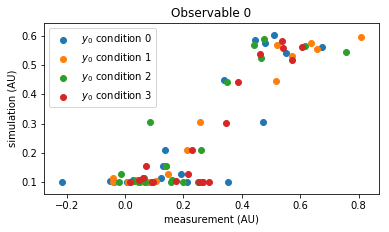

[0.24692785 0.45673752 0.41080699 0.44279896 0.54269522 0.5472063
 0.45422085 0.50442097 0.3679899  0.36420263 0.39503536 0.37443086
 0.44222864 0.50008826 0.53091069 0.54893563 0.69643748 0.81386897
 0.53418117 0.56816564] [0.40001201 0.40002485 0.40005142 0.40010638 0.40022008 0.40045519
 0.40094108 0.40194388 0.40400791 0.40823234 0.41677856 0.43365935
 0.46541273 0.51957158 0.59613448 0.67244237 0.70385163 0.67332559
 0.6118992  0.55105793]
[0.46943513 0.59024881 0.30380227 0.37300195 0.32747276 0.38175043
 0.41795182 0.50270297 0.37967032 0.52535214 0.34584468 0.28369024
 0.58125965 0.41117981 0.62973431 0.70019681 0.66071359 0.57583087
 0.43617843 0.54255725] [0.40001201 0.40002485 0.40005142 0.40010638 0.40022008 0.40045518
 0.40094104 0.4019437  0.40400712 0.408229   0.41676453 0.43360126
 0.46518047 0.51870412 0.59328126 0.66494041 0.68984586 0.65401746
 0.58852157 0.52627263]
[0.39792144 0.45838312 0.53344083 0.50597192 0.40993534 0.42287748
 0.43758464 0.33336713 0.40844684 

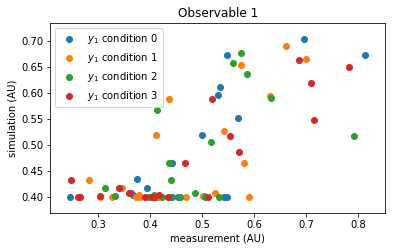

[ 0.69485574  0.72627388  0.77908642  0.63809311  0.68303241  0.75966319
  0.70661843  0.80309469  0.69183801  0.62222988  0.78175945  0.60073625
  0.47474187  0.43191077  0.26346558  0.15106956  0.2778331   0.0765422
  0.27569146 -0.09704166] [0.69997929 0.69995715 0.69991134 0.69981657 0.69962051 0.69921503
 0.69837688 0.6966462  0.69308044 0.68576731 0.6709101  0.6413158
 0.58474465 0.48556579 0.34057653 0.1941878  0.11833602 0.09829815
 0.08521122 0.07320934]
[ 0.94745576  0.59793025  0.54670806  0.77436429  0.67603564  0.54399339
  0.74790909  0.8216325   0.74576214  0.84144661  0.82683416  0.81624084
  0.76619003  0.40103618  0.23596159 -0.01055022  0.32458153  0.03032914
 -0.08466848 -0.02097045] [0.69997859 0.6999557  0.69990835 0.69981037 0.69960769 0.69918851
 0.69832208 0.6965331  0.69284764 0.68529081 0.66994606 0.63941144
 0.58116257 0.47946128 0.33196315 0.18519582 0.11092021 0.09133552
 0.07810679 0.06644797]
[ 0.71086693  0.61069088  0.92707075  0.59962152  0.45835732  

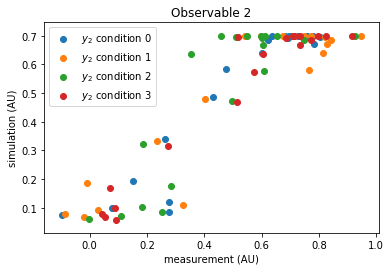

[0.27802839 0.2442628  0.20047829 0.13720158 0.14077162 0.34866577
 0.13598189 0.17920623 0.20485733 0.15558651 0.14919098 0.33880899
 0.48632569 0.71046899 0.91776209 1.00787713 1.28405214 1.17449804
 0.95193897 0.98350151] [0.19131092 0.19134999 0.19143083 0.19159808 0.19194409 0.19265978
 0.19413959 0.197197   0.20350385 0.21647049 0.24294273 0.29617395
 0.39963963 0.58525477 0.85805454 1.1010929  1.15474689 1.11875967
 1.07869223 1.03856099]
[ 0.19015107  0.21010075  0.18889452  0.0658286   0.27598123  0.15798509
  0.12185337 -0.08295271  0.30818869  0.23721661  0.2349646   0.40760183
  0.54890347  0.48942753  0.72387819  0.8638735   1.18849743  1.1740759
  0.91333689  0.89780587] [0.19131092 0.19134999 0.19143083 0.19159808 0.19194408 0.19265976
 0.19413951 0.19719665 0.20350235 0.21646411 0.24291582 0.29606233
 0.39919363 0.58361711 0.85310147 1.09095774 1.14190812 1.10428193
 1.06146781 1.01992692]
[0.32410629 0.27501911 0.34301668 0.28912099 0.08903736 0.26893223
 0.34179311 0.

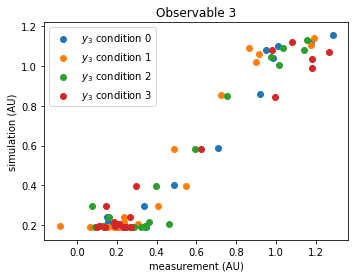

[3.3800185  3.40034792 3.40150952 3.37622779 3.38037098 3.37540823
 3.3828729  3.48298825 3.3212023  3.39852775 3.27874848 3.46015362
 3.29871746 3.51738048 3.54915459 3.71992379 3.85560714 3.57202695
 3.79298007 3.56748708] [3.40516447 3.40517731 3.40520388 3.40525884 3.40537254 3.40560766
 3.40609354 3.40709634 3.40916037 3.4133848  3.42193103 3.43881181
 3.47056519 3.52472404 3.60128695 3.67759484 3.70900409 3.67847806
 3.61705167 3.55621039]
[4.38998397 4.41927764 4.30560142 4.42552052 4.42896173 4.48860866
 4.52224161 4.48363079 4.3486529  4.57380791 4.4556163  4.31048213
 4.54105408 4.55877601 4.61619857 4.69090045 4.7716002  4.71100213
 4.50606696 4.49173669] [4.39824508 4.39825792 4.39828449 4.39833945 4.39845314 4.39868825
 4.3991741  4.40017677 4.40224019 4.40646207 4.4149976  4.43183433
 4.46341353 4.51693719 4.59151433 4.66317347 4.68807893 4.65225052
 4.58675464 4.5245057 ]
[3.22245133 3.51067689 3.51732536 3.30236883 3.45802124 3.46031147
 3.58616031 3.43313594 3.53772997

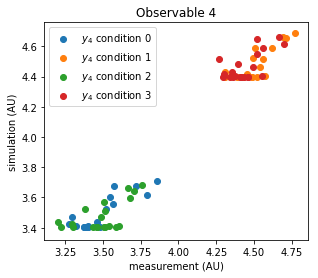

[ 0.13970171  0.50644592  0.3202079   0.14052583  0.15212017 -0.2493509
 -0.02008638  0.1293201   0.29912141  0.00284632  0.35813639  0.21970587
  0.32614425  0.30188574  0.87908836  0.49288721  0.43664726  0.42697984
  0.56226575  0.44919928] [0.10001911 0.10003953 0.10008179 0.10016923 0.10035013 0.1007243
 0.10149796 0.1030964  0.10639368 0.11317276 0.12701269 0.15484246
 0.20893527 0.30597656 0.44859878 0.57566147 0.60371226 0.58489782
 0.56395019 0.54296921]
[ 0.21170598  0.33664109  0.17421755 -0.008877    0.11108252  0.15715859
  0.12399861  0.19435185  0.02304884 -0.41092615  0.41174002  0.23352228
  0.2390642   0.386018    0.40709445  0.52679778  0.77816749  0.69641856
  0.36549298  1.00674743] [0.10001911 0.10003953 0.10008179 0.10016923 0.10035013 0.10072429
 0.10149791 0.10309622 0.1063929  0.11316942 0.12699862 0.1547841
 0.20870209 0.30512038 0.44600927 0.57036271 0.59700004 0.57732872
 0.55494511 0.53322715]
[ 0.211185   -0.18851965  0.04752748  0.38306261  0.19080738  0

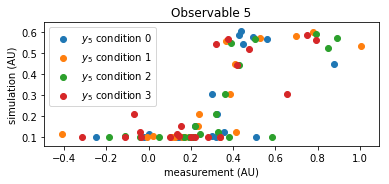

[ 0.15916003  0.24572667  0.13673315  0.08511784  0.30448755  0.1873423
  0.20808639  0.03428187 -0.00352889  0.05088907 -0.00308514  0.08619144
  0.16566547  0.17372748  0.54619772  0.48540189  0.692316    0.56832874
  0.65116308  0.53625814] [0.10001731 0.10003581 0.1000741  0.10015332 0.1003172  0.10065618
 0.10135707 0.10280514 0.10579212 0.11193289 0.12446893 0.14967962
 0.19874021 0.28729426 0.42067524 0.54910307 0.58479205 0.56211392
 0.53378973 0.49676698]
[ 0.01569991  0.05223609  0.12703311  0.25635269  0.07222441 -0.03215521
  0.22822665  0.06133688  0.21676408 -0.07208313  0.06568774  0.42708264
  0.19211152  0.41463521  0.36713655  0.53678856  0.53570787  0.529725
  0.69157481  0.57167857] [0.10001731 0.10003581 0.1000741  0.10015332 0.1003172  0.10065617
 0.10135702 0.10280495 0.10579134 0.1119296  0.12445502 0.1496219
 0.19850895 0.28643773 0.4180173  0.54337853 0.57744861 0.55451922
 0.52501446 0.48696673]
[ 0.21630449  0.21041788  0.12879859  0.15839563  0.20429899  0.

[0.30590642 0.49965401 0.50238943 0.44918854 0.43728716 0.27251288
 0.41184502 0.50110778 0.32008826 0.30322644 0.24900593 0.33571027
 0.59813284 0.59706209 0.62115041 0.70890531 0.72159643 0.61255767
 0.7545004  0.56442351] [0.40001223 0.40002531 0.40005236 0.40010833 0.40022412 0.40046357
 0.40095846 0.40198007 0.40408375 0.40839333 0.41712852 0.43445097
 0.46730053 0.52423824 0.60709478 0.69365131 0.73486755 0.7049077
 0.62810217 0.52884535]
[0.3212127  0.23099052 0.36652016 0.43201178 0.7312585  0.43115497
 0.22538538 0.39425023 0.19213055 0.33588268 0.5274961  0.53931789
 0.53727566 0.6161248  0.54762985 0.69751756 0.69081911 0.63203555
 0.7762776  0.47860425] [0.40001223 0.40002531 0.40005236 0.40010833 0.40022412 0.40046356
 0.40095842 0.40197989 0.40408297 0.40839003 0.41711464 0.43439348
 0.46707014 0.52337419 0.60423279 0.68604362 0.7205999  0.68595346
 0.60606322 0.50554077]
[0.46259014 0.53885938 0.46011908 0.33340699 0.35479401 0.34837128
 0.36652841 0.52607043 0.40859914 

[ 0.72677626  0.62408195  0.63482079  0.62296573  0.66568478  0.69232537
  0.70291275  0.73017854  0.79311289  0.73234464  0.64140407  0.70769762
  0.63247444  0.26797573  0.29846662  0.18896596  0.07578989  0.20676793
 -0.14981219  0.06616002] [0.69997935 0.69995727 0.69991159 0.69981708 0.69962157 0.69921722
 0.69838136 0.69665522 0.69309807 0.68579941 0.67095789 0.64133597
 0.58446178 0.4837303  0.33288148 0.17232452 0.08230055 0.06102024
 0.05100787 0.03964877]
[0.75674704 0.61324412 0.6240055  0.7394278  0.62996087 0.7538084
 0.8179365  0.72901968 0.7555966  0.78058184 0.65261254 0.70008186
 0.60545314 0.64107609 0.3147367  0.0938295  0.39931685 0.02759383
 0.04235241 0.11154846] [0.69997865 0.69995582 0.6999086  0.69981088 0.69960875 0.6991907
 0.69832655 0.69654211 0.69286525 0.68532286 0.66999364 0.63943091
 0.58087809 0.47763026 0.32435968 0.16393134 0.07665596 0.05668399
 0.04686335 0.03594841]
[ 0.54684505  0.76202841  0.63454694  0.52282946  0.74909427  0.82314922
  0.67404

[0.1907933  0.27209824 0.36951398 0.19435857 0.30535819 0.2125448
 0.12866825 0.13808969 0.1310186  0.20997028 0.25936197 0.35389469
 0.3946488  0.54022183 0.88766994 0.89368331 1.22642582 1.20625354
 1.04191499 0.87967847] [0.20029614 0.2003332  0.20040988 0.20056852 0.20089671 0.20157555
 0.20297916 0.20587909 0.21186086 0.22415847 0.24926332 0.29975062
 0.39800009 0.57533974 0.84245046 1.09964193 1.17111323 1.12569767
 1.06897521 0.99483292]
[0.27025777 0.15696504 0.27267956 0.09491388 0.34569364 0.07575023
 0.3410928  0.42575072 0.12007057 0.09069459 0.23550071 0.28054735
 0.3471489  0.56462285 0.88973668 1.29142636 1.28231037 1.01887848
 1.00955116 1.02859774] [0.20029614 0.2003332  0.20040988 0.20056852 0.20089671 0.20157553
 0.20297908 0.20587872 0.21185931 0.22415187 0.24923547 0.29963503
 0.39753696 0.57362444 0.83712763 1.08817789 1.15640714 1.11048841
 1.05140173 0.97520678]
[0.16023189 0.33302386 0.14000213 0.29214868 0.13408901 0.23601536
 0.44759844 0.23268647 0.29378687 

[3.45636505 3.36158784 3.28803153 3.28735994 3.62803645 3.36101359
 3.59995358 3.29787714 3.57466182 3.26396289 3.34658484 3.36716998
 3.36903788 3.41745726 3.76811338 3.80473749 3.6146522  3.75378181
 3.61339223 3.51102235] [3.41038639 3.41039946 3.41042652 3.41048249 3.41059828 3.41083772
 3.41133261 3.41235422 3.4144579  3.41876748 3.42750267 3.44482513
 3.47767469 3.5346124  3.61746893 3.70402546 3.7452417  3.71528185
 3.63847633 3.53921951]
[4.4168258  4.3776654  4.58133642 4.43338947 4.50199516 4.34303138
 4.36113614 4.37122702 4.36408939 4.53347271 4.44150925 4.15750504
 4.42459644 4.36561356 4.62423081 4.52954237 4.75000243 4.66072994
 4.49191862 4.61692196] [4.4004976  4.40051068 4.40053773 4.4005937  4.40070949 4.40094893
 4.40144378 4.40246526 4.40456834 4.4088754  4.41760001 4.43487885
 4.46755551 4.52385956 4.60471816 4.68652899 4.72108527 4.68643883
 4.60654858 4.50602614]
[3.62741405 3.46485784 3.35562352 3.40852883 3.40170222 3.41905511
 3.37809158 3.28792095 3.38880487

[-0.05934166 -0.0988532   0.28480478  0.34572821  0.01784008  0.27936917
 -0.02845237  0.3339602  -0.33672364  0.23935972  0.00517389  0.29777997
  0.32299148  0.14099866  0.44992062  0.51511182  0.20151359  0.33985172
  0.67430935  0.52078272] [0.10001731 0.10003581 0.1000741  0.10015332 0.1003172  0.10065618
 0.10135707 0.10280514 0.10579212 0.11193289 0.12446893 0.14967962
 0.19874021 0.28729426 0.42067524 0.54910307 0.58479205 0.56211392
 0.53378973 0.49676698]
[-0.11870422 -0.08337182  0.22028344 -0.21066544  0.10850223  0.30406927
  0.1077829  -0.42711758 -0.10048488 -0.05173862 -0.00664722 -0.12865003
  0.37605088  0.28025466  0.29192848  0.73544086  0.5302705   0.31543237
  0.77101693  0.77270274] [0.10001731 0.10003581 0.1000741  0.10015332 0.1003172  0.10065617
 0.10135702 0.10280495 0.10579134 0.1119296  0.12445502 0.1496219
 0.19850895 0.28643773 0.4180173  0.54337853 0.57744861 0.55451922
 0.52501446 0.48696673]
[-0.10064796 -0.16643379  0.23198312  0.16802696  0.34288318 

In [24]:
def plotCorrelation(ymes, ysim):
    for iy in range(ysim.shape[2]):
        fig, ax = plt.subplots()
        for icondition in range(ysim.shape[0]):
            x = ymes[icondition, :, iy]
            y = ysim[icondition, :, iy]
            print(x, y)
            ax.scatter(x, y, label='$y_%d$ condition %d' % (iy, icondition))
        plt.xlabel('measurement (AU)')
        plt.ylabel('simulation (AU)')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title('Observable %d' % iy)
        plt.legend()
        plt.show()
        
plotCorrelation(ymes, ysim)

In [25]:
def plotTrajectoryFit(ymes, ysim, timepoints):
    for icondition in range(ysim.shape[0]):
        fig, ax = plt.subplots()
        for iy in range(ysim.shape[2]):
            ax.plot(timepoints, ysim[icondition, :, iy], label='$y_%d$ sim' % (iy), alpha=0.7, c='C%d'%iy)
            ax.plot(timepoints, ymes[icondition, :, iy], label='$y_%d$ mes' % (iy), linestyle='dotted', c='C%d'%iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.title('Condition %d' %icondition)
        plt.legend()
        plt.show()

plotTrajectoryFit(ymes, ysim, timepoints)

## Hierarchical optimization

In [26]:
!../../../misc/optimizationOptions.py example_data.h5 -s hierarchicalOptimization 1
!../../../misc/optimizationOptions.py example_data.h5 -s numStarts 1
!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/max_iter 100
!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/acceptable_obj_change_tol 1e-5
!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/acceptable_tol 1e-5
!../../../misc/optimizationOptions.py example_data.h5 -s retryOptimization 0
!../../../misc/optimizationOptions.py example_data.h5


                               optimizer            0
                hierarchicalOptimization            1
                               numStarts            1
                       retryOptimization            0
                ceres/max_num_iterations          100
                         fmincon/MaxIter          100
                            fmincon/TolX        1e-08
                          fmincon/TolFun            0
                     fmincon/MaxFunEvals   10000000.0
                       fmincon/algorithm b'interior-point'
                         fmincon/GradObj        b'on'
                         fmincon/display      b'iter'
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
   ipopt/watchdog_shortened_iter_trigger            0
                          ipopt/max_iter          100
         ipopt/acc

                               optimizer            0
                hierarchicalOptimization            1
                               numStarts            1
                       retryOptimization            0
                ceres/max_num_iterations          100
                         fmincon/MaxIter          100
                            fmincon/TolX        1e-08
                          fmincon/TolFun            0
                     fmincon/MaxFunEvals   10000000.0
                       fmincon/algorithm b'interior-point'
                         fmincon/GradObj        b'on'
                         fmincon/display      b'iter'
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
   ipopt/watchdog_shortened_iter_trigger            0
                          ipopt/max_iter          100
         ipopt/acc

In [27]:
# gradient check 
!PARPE_NO_DEBUG=1 ../../../build/amici/examples/steadystate/example_steadystate_multi -t gradient_check -o deletemegc/ example_data.h5


HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-08-12 13:10:51] [INF] [-1/]     0 g:      950.039  fd_c:      950.037  Δ/fd_c: 2.511318e-06  f:      48982.7
[2018-08-12 13:10:51] [WRN] [-1/]     1 g:      -7.3194  fd_c:     -7.32543  Δ/fd_c: -8.240526e-04  f:      48982.7
[2018-08-12 13:10:51] [WRN] [-1/]     2 g:     -33.1087  fd_c:     -33.1122  Δ/fd_c: -1.044981e-04  f:      48982.7
[2018-08-12 13:10:51] [INF] [-1/]     3 g:      3291.56  fd_c:      3291.56  Δ/fd_c: 7.041228e-07  f:      48982.7
[2018-08-12 13:10:51] [INF] [-1/]     4 g:       220132  fd_c:       220132  Δ/fd_c: 1.285397e-08  f:      48982.7
[2018-08-12 13:10:51] [INF] [-1/] Walltime on master: 0.274837s, CPU time of all processes: 0.464620s


HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma


[2018-08-23 09:09:38] [WRN] [-1/]     0 g:      1182.96  fd_c:       1182.9  Δ/fd_c: 5.663004e-05  f:      1873.05


[2018-08-23 09:09:38] [WRN] [-1/]     1 g:     -1718.89  fd_c:     -1718.92  Δ/fd_c: -1.713036e-05  f:      1873.05
[2018-08-23 09:09:38] [WRN] [-1/]     2 g:     -13.5639  fd_c:     -13.5711  Δ/fd_c: -5.325210e-04  f:      1873.05


[2018-08-23 09:09:38] [WRN] [-1/]     3 g:       2302.2  fd_c:       2302.3  Δ/fd_c: -4.609920e-05  f:      1873.05
[2018-08-23 09:09:38] [WRN] [-1/]     4 g:     -250.125  fd_c:      -250.09  Δ/fd_c: 1.409542e-04  f:      1873.05
[2018-08-23 09:09:38] [INF] [-1/] Walltime on master: 0.557696s, CPU time of all processes: 0.268978s


In [28]:
# optimization
!PARPE_NO_DEBUG=1 mpiexec -n 4 ../../../build/amici/examples/steadystate/example_steadystate_multi  -o deletemehierarchical/ example_data.h5


[2018-08-23 09:09:47] [INF] [0/paul-ubuntu] Running with 4 MPI processes.
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma


HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-08-23 09:09:47] [INF] [0/paul-ubuntu] Reading random initial theta 0 from /optimizationOptions/randomStarts
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma

List of user-set options:

                                    Name   Value                used
                         acceptable_iter = 1                     yes
               acceptable_obj_change_tol = 1e-05                 yes
                          acceptable_tol = 1e-05                 yes
                   hessian_approximation = limited-memory        yes
              limited_memory_update_type = bfgs                  yes
                                max_iter = 100                   yes
                             print_level = 5                     yes
                      print_user_options = yes                   yes
                                 

Total number of variables............................:        5
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

[2018-08-23 09:09:47] [INF] [0/paul-ubuntu] [o0i0] iter: 0 cost: -362.545 time_iter: wall: 0.294113s cpu: 0.543743s time_optim: wall: 0.294113s cpu: 0.543743s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -3.6254511e+02 0.00e+00 1.31e+01   0.0 0.00e+00    -  0.00e+00 0.00e+00   0


[2018-08-23 09:09:48] [INF] [0/paul-ubuntu] [o0i1] iter: 1 cost: -362.599 time_iter: wall: 0.829933s cpu: 1.08278s time_optim: wall: 1.12405s cpu: 1.62652s
   1 -3.6259942e+02 0.00e+00 9.06e+00   0.9 9.20e+00    -  5.97e-01 1.05e-03f 10


[2018-08-23 09:09:49] [INF] [0/paul-ubuntu] [o0i2] iter: 2 cost: -362.633 time_iter: wall: 0.330466s cpu: 0.51997s time_optim: wall: 1.45451s cpu: 2.14649s
   2 -3.6263281e+02 0.00e+00 2.36e+00  -1.3 2.38e-03    -  9.94e-01 1.00e+00f  1


[2018-08-23 09:09:49] [INF] [0/paul-ubuntu] [o0i3] iter: 3 cost: -362.638 time_iter: wall: 0.344881s cpu: 0.624804s time_optim: wall: 1.7994s cpu: 2.77129s
   3 -3.6263762e+02 0.00e+00 1.55e+00  -3.0 1.42e-03    -  9.99e-01 1.00e+00f  1


[2018-08-23 09:09:49] [INF] [0/paul-ubuntu] [o0i4] iter: 4 cost: -362.652 time_iter: wall: 0.312911s cpu: 0.569814s time_optim: wall: 2.11231s cpu: 3.34111s
   4 -3.6265227e+02 0.00e+00 2.86e+00  -4.8 5.11e-03    -  1.00e+00 1.00e+00f  1


[2018-08-23 09:09:50] [INF] [0/paul-ubuntu] [o0i5] iter: 5 cost: -362.664 time_iter: wall: 0.377376s cpu: 0.627294s time_optim: wall: 2.48968s cpu: 3.9684s
   5 -3.6266449e+02 0.00e+00 4.66e+00  -6.5 1.82e-02    -  1.00e+00 5.00e-01f  2


[2018-08-23 09:09:50] [INF] [0/paul-ubuntu] [o0i6] iter: 6 cost: -362.702 time_iter: wall: 0.311612s cpu: 0.581423s time_optim: wall: 2.8013s cpu: 4.54982s
   6 -3.6270208e+02 0.00e+00 6.11e+00  -8.2 3.04e-02    -  1.00e+00 1.00e+00f  1


[2018-08-23 09:09:50] [INF] [0/paul-ubuntu] [o0i7] iter: 7 cost: -362.719 time_iter: wall: 0.487594s cpu: 0.847983s time_optim: wall: 3.28889s cpu: 5.39781s
   7 -3.6271904e+02 0.00e+00 5.52e+00  -9.8 3.72e-02    -  1.00e+00 5.00e-01f  2


[2018-08-23 09:09:51] [INF] [0/paul-ubuntu] [o0i8] iter: 8 cost: -362.736 time_iter: wall: 0.325881s cpu: 0.585619s time_optim: wall: 3.61477s cpu: 5.98343s
   8 -3.6273566e+02 0.00e+00 4.32e-01 -11.0 4.83e-03    -  1.00e+00 1.00e+00f  1


[2018-08-23 09:09:51] [INF] [0/paul-ubuntu] [o0i9] iter: 9 cost: -362.736 time_iter: wall: 0.375287s cpu: 0.717145s time_optim: wall: 3.99006s cpu: 6.70057s
   9 -3.6273646e+02 0.00e+00 2.29e-01 -11.0 2.65e-03    -  1.00e+00 1.00e+00f  1


[2018-08-23 09:09:51] [INF] [0/paul-ubuntu] [o0i10] iter: 10 cost: -362.738 time_iter: wall: 0.310977s cpu: 0.546925s time_optim: wall: 4.30104s cpu: 7.2475s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.6273842e+02 0.00e+00 3.91e-01 -11.0 5.11e-03    -  1.00e+00 1.00e+00f  1


[2018-08-23 09:09:52] [INF] [0/paul-ubuntu] [o0i11] iter: 11 cost: -362.741 time_iter: wall: 0.321722s cpu: 0.6256s time_optim: wall: 4.62276s cpu: 7.8731s
  11 -3.6274085e+02 0.00e+00 2.01e+00 -11.0 1.71e-02    -  1.00e+00 1.00e+00f  1


[2018-08-23 09:09:52] [INF] [0/paul-ubuntu] [o0i12] iter: 12 cost: -362.742 time_iter: wall: 0.474695s cpu: 0.741042s time_optim: wall: 5.09745s cpu: 8.61414s
  12 -3.6274202e+02 0.00e+00 3.05e-01 -11.0 8.73e-02    -  1.00e+00 1.25e-01f  4

[2018-08-23 09:09:53] [INF] [0/paul-ubuntu] [o0i13] iter: 13 cost: -362.742 time_iter: wall: 0.507483s cpu: 0.696493s time_optim: wall: 5.60494s cpu: 9.31063s
  13 -3.6274215e+02 0.00e+00 4.24e-01 -11.0 2.83e-02    -  1.00e+00 1.25e-01f  4


[2018-08-23 09:09:53] [INF] [0/paul-ubuntu] [o0i14] iter: 14 cost: -362.742 time_iter: wall: 0.543888s cpu: 0.802895s time_optim: wall: 6.14883s cpu: 10.1135s
  14 -3.6274220e+02 0.00e+00 1.46e-01 -11.0 3.06e-02    -  1.00e+00 6.25e-02f  5


[2018-08-23 09:09:54] [INF] [0/paul-ubuntu] [o0i15] iter: 15 cost: -362.743 time_iter: wall: 0.276609s cpu: 0.514819s time_optim: wall: 6.42544s cpu: 10.6283s
  15 -3.6274280e+02 0.00e+00 3.89e-02 -11.0 1.07e-02    -  1.00e+00 1.00e+00f  1


[2018-08-23 09:09:54] [INF] [0/paul-ubuntu] [o0i16] iter: 16 cost: -362.743 time_iter: wall: 0.553918s cpu: 0.825802s time_optim: wall: 6.97935s cpu: 11.4541s
  16 -3.6274280e+02 0.00e+00 1.51e-02 -11.0 2.98e-03    -  1.00e+00 3.12e-02f  6


[2018-08-23 09:09:54] [INF] [0/paul-ubuntu] [o0i17] iter: 17 cost: -362.743 time_iter: wall: 0.300186s cpu: 0.507206s time_optim: wall: 7.27954s cpu: 11.9614s
  17 -3.6274280e+02 0.00e+00 1.44e-03 -11.0 8.63e-04    -  1.00e+00 1.00e+00f  1


[2018-08-23 09:09:55] [INF] [0/paul-ubuntu] [o0i18] iter: 18 cost: -362.743 time_iter: wall: 0.353935s cpu: 0.546012s time_optim: wall: 7.63348s cpu: 12.5074s
  18 -3.6274280e+02 0.00e+00 1.61e-03 -11.0 2.36e-05    -  1.00e+00 5.00e-01f  2


[2018-08-23 09:09:55] [INF] [0/paul-ubuntu] [o0i19] iter: 19 cost: -362.743 time_iter: wall: 0.474129s cpu: 0.701851s time_optim: wall: 8.10761s cpu: 13.2092s
  19 -3.6274280e+02 0.00e+00 3.60e-04 -11.0 8.13e-05    -  1.00e+00 1.25e-01f  4

[2018-08-23 09:09:56] [INF] [0/paul-ubuntu] [o0i20] iter: 20 cost: -362.743 time_iter: wall: 0.452985s cpu: 0.676975s time_optim: wall: 8.56059s cpu: 13.8862s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -3.6274280e+02 0.00e+00 1.57e-03 -11.0 1.25e-04    -  1.00e+00 1.25e-01f  4


[2018-08-23 09:09:56] [INF] [0/paul-ubuntu] [o0i21] iter: 21 cost: -362.743 time_iter: wall: 0.469384s cpu: 0.675802s time_optim: wall: 9.02998s cpu: 14.562s
  21 -3.6274280e+02 0.00e+00 5.00e-04 -11.0 1.84e-04    -  1.00e+00 6.25e-02f  5


[2018-08-23 09:09:56] [INF] [0/paul-ubuntu] [o0i22] iter: 22 cost: -362.743 time_iter: wall: 0.328505s cpu: 0.627346s time_optim: wall: 9.35848s cpu: 15.1893s
  22 -3.6274280e+02 0.00e+00 9.85e-05 -11.0 1.61e-05    -  1.00e+00 1.00e+00f  1


[2018-08-23 09:09:57] [INF] [0/paul-ubuntu] [o0i23] iter: 23 cost: -362.743 time_iter: wall: 0.494818s cpu: 0.66558s time_optim: wall: 9.8533s cpu: 15.8549s
  23 -3.6274280e+02 0.00e+00 1.04e-04 -11.0 7.65e-06    -  1.00e+00 3.12e-02f  6


[2018-08-23 09:09:57] [INF] [0/paul-ubuntu] [o0i24] iter: 24 cost: -362.743 time_iter: wall: 0.305711s cpu: 0.513126s time_optim: wall: 10.159s cpu: 16.368s
  24 -3.6274280e+02 0.00e+00 3.71e-07 -11.0 9.39e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 24

                                   (scaled)                 (unscaled)
Objective...............:  -3.6274280472465375e+02   -3.6274280472465375e+02
Dual infeasibility......:   3.7075054231151046e-07    3.7075054231151046e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0000000000003971e-11    1.0000000000003971e-11
Overall NLP error.......:   3.7075054231151046e-07    3.7075054231151046e-07


Number of objective function evaluations             = 115
Number of objective gradient evaluations             = 25
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian eva

[2018-08-23 09:09:59] [INF] [0/paul-ubuntu] Walltime on master: 12.552605s, CPU time of all processes: 5.988010s
[2018-08-23 09:09:59] [INF] [0/paul-ubuntu] Sent termination signal to workers.


In [30]:
filename = 'deletemehierarchical/_rank00000.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])    
trajectory

array([[-362.54511276, -362.59941571, -362.63281092, -362.63762407,
        -362.65227376, -362.6644902 , -362.70207913, -362.7190383 ,
        -362.73566421, -362.73646023, -362.73841555, -362.74084963,
        -362.74202489, -362.74215433, -362.7422029 , -362.7427991 ,
        -362.74280026, -362.74280472, -362.74280472, -362.74280472,
        -362.74280472, -362.74280472, -362.74280472, -362.74280472,
        -362.74280472]])

array([[-362.54511276, -362.59941571, -362.63281092, -362.63762407,
        -362.65227376, -362.6644902 , -362.70207913, -362.7190383 ,
        -362.73566421, -362.73646023, -362.73841555, -362.74084963,
        -362.74202489, -362.74215433, -362.7422029 , -362.7427991 ,
        -362.74280026, -362.74280472, -362.74280472, -362.74280472,
        -362.74280472, -362.74280472, -362.74280472, -362.74280472,
        -362.74280472]])

In [31]:
compareResults('deletemehierarchical/_rank00000.h5', -expectedLlh)

#  __Exp___ __Act___ __Err___ _RelErr___
0: 1.000000 0.908622 -0.091378 -0.091378
1: 0.500000 0.443363 -0.056637 -0.113274
2: 0.400000 0.377745 -0.022255 -0.055639
3: 2.000000 1.975561 -0.024439 -0.012220
4: 0.100000 0.081736 -0.018264 -0.182642
5: 2.000000 2.002610 0.002610 0.001305
6: 3.000000 3.010373 0.010373 0.003458
7: 0.200000 0.207911 0.007911 0.039553
8: 4.000000 4.000484 0.000484 0.000121
Status: 4
Cost: -362.742805 (expected: -0.000000)


In [32]:
list(model.getParameterNames())

['p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'scaling_x1',
 'offset_x2',
 'observable_x1withsigma_sigma']

['', '', '', '', '', '', '', '']

In [33]:
!rm simh.h5
!../../../build/amici/examples/steadystate/example_steadystate_multi_simulator deletemehierarchical/_rank00000.h5 / simh.h5 / --at-optimum

rm: cannot remove 'simh.h5': No such file or directory


Running for start 0


In [34]:
with h5py.File('simh.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

(4, 20, 6)
(4, 20, 6)


(4, 20, 6)
(4, 20, 6)


In [35]:
plotCorrelation(ymes, ysim)

[ 0.15916003  0.24572667  0.13673315  0.08511784  0.30448755  0.1873423
  0.20808639  0.03428187 -0.00352889  0.05088907 -0.00308514  0.08619144
  0.16566547  0.17372748  0.54619772  0.48540189  0.692316    0.56832874
  0.65116308  0.53625814] [0.10001731 0.10003581 0.1000741  0.10015332 0.1003172  0.10065618
 0.10135708 0.10280515 0.10579216 0.11193298 0.1244691  0.14967996
 0.19874087 0.2872954  0.42067678 0.54910406 0.58479191 0.5621137
 0.53378981 0.49676755]
[ 0.01569991  0.05223609  0.12703311  0.25635269  0.07222441 -0.03215521
  0.22822665  0.06133688  0.21676408 -0.07208313  0.06568774  0.42708264
  0.19211152  0.41463521  0.36713655  0.53678856  0.53570787  0.529725
  0.69157481  0.57167857] [0.10001731 0.10003581 0.1000741  0.10015332 0.1003172  0.10065617
 0.10135703 0.10280497 0.10579138 0.11192968 0.12445519 0.14962224
 0.19850961 0.28643887 0.41801883 0.54337954 0.5774485  0.55451903
 0.52501455 0.48696729]
[ 0.21630449  0.21041788  0.12879859  0.15839563  0.20429899  0.

[0.30590642 0.49965401 0.50238943 0.44918854 0.43728716 0.27251288
 0.41184502 0.50110778 0.32008826 0.30322644 0.24900593 0.33571027
 0.59813284 0.59706209 0.62115041 0.70890531 0.72159643 0.61255767
 0.7545004  0.56442351] [0.40001223 0.40002531 0.40005236 0.40010834 0.40022412 0.40046357
 0.40095846 0.40198008 0.40408377 0.40839338 0.41712862 0.43445118
 0.46730092 0.52423891 0.60709579 0.69365264 0.73486905 0.70490931
 0.62810422 0.5288482 ]
[0.3212127  0.23099052 0.36652016 0.43201178 0.7312585  0.43115497
 0.22538538 0.39425023 0.19213055 0.33588268 0.5274961  0.53931789
 0.53727566 0.6161248  0.54762985 0.69751756 0.69081911 0.63203555
 0.7762776  0.47860425] [0.40001223 0.40002531 0.40005236 0.40010833 0.40022412 0.40046356
 0.40095842 0.4019799  0.404083   0.40839009 0.41711475 0.43439368
 0.46707053 0.52337486 0.60423379 0.68604492 0.72060137 0.68595505
 0.60606519 0.50554349]
[0.46259014 0.53885938 0.46011908 0.33340699 0.35479401 0.34837128
 0.36652841 0.52607043 0.40859914

[ 0.72677626  0.62408195  0.63482079  0.62296573  0.66568478  0.69232537
  0.70291275  0.73017854  0.79311289  0.73234464  0.64140407  0.70769762
  0.63247444  0.26797573  0.29846662  0.18896596  0.07578989  0.20676793
 -0.14981219  0.06616002] [0.69997935 0.69995727 0.69991159 0.69981708 0.69962157 0.69921722
 0.69838135 0.69665521 0.69309805 0.68579935 0.67095777 0.64133574
 0.58446135 0.4837296  0.3328806  0.17232399 0.0823007  0.06102063
 0.05100829 0.03964923]
[0.75674704 0.61324412 0.6240055  0.7394278  0.62996087 0.7538084
 0.8179365  0.72901968 0.7555966  0.78058184 0.65261254 0.70008186
 0.60545314 0.64107609 0.3147367  0.0938295  0.39931685 0.02759383
 0.04235241 0.11154846] [0.69997865 0.69995582 0.69990859 0.69981088 0.69960875 0.6991907
 0.69832655 0.6965421  0.69286523 0.6853228  0.66999352 0.63943068
 0.58087766 0.47762956 0.32435883 0.16393084 0.07665613 0.05668438
 0.04686374 0.03594882]
[ 0.54684505  0.76202841  0.63454694  0.52282946  0.74909427  0.82314922
  0.67404

[0.1907933  0.27209824 0.36951398 0.19435857 0.30535819 0.2125448
 0.12866825 0.13808969 0.1310186  0.20997028 0.25936197 0.35389469
 0.3946488  0.54022183 0.88766994 0.89368331 1.22642582 1.20625354
 1.04191499 0.87967847] [0.20029562 0.20033268 0.20040935 0.20056799 0.20089619 0.20157504
 0.20297865 0.20587859 0.21186039 0.22415805 0.24926301 0.29975052
 0.39800036 0.57534052 0.84245134 1.09964105 1.17110986 1.12569427
 1.06897257 0.99483144]
[0.27025777 0.15696504 0.27267956 0.09491388 0.34569364 0.07575023
 0.3410928  0.42575072 0.12007057 0.09069459 0.23550071 0.28054735
 0.3471489  0.56462285 0.88973668 1.29142636 1.28231037 1.01887848
 1.00955116 1.02859774] [0.20029562 0.20033268 0.20040935 0.20056799 0.20089618 0.20157502
 0.20297856 0.20587822 0.21185884 0.22415145 0.24923516 0.29963493
 0.39753724 0.57362522 0.83712851 1.08817705 1.15640389 1.1104851
 1.05139915 0.97520535]
[0.16023189 0.33302386 0.14000213 0.29214868 0.13408901 0.23601536
 0.44759844 0.23268647 0.29378687 0

[3.45636505 3.36158784 3.28803153 3.28735994 3.62803645 3.36101359
 3.59995358 3.29787714 3.57466182 3.26396289 3.34658484 3.36716998
 3.36903788 3.41745726 3.76811338 3.80473749 3.6146522  3.75378181
 3.61339223 3.51102235] [3.41038542 3.41039849 3.41042555 3.41048152 3.41059731 3.41083676
 3.41133165 3.41235327 3.41445696 3.41876656 3.42750181 3.44482437
 3.47767411 3.5346121  3.61746898 3.70402583 3.74524223 3.7152825
 3.6384774  3.53922138]
[4.4168258  4.3776654  4.58133642 4.43338947 4.50199516 4.34303138
 4.36113614 4.37122702 4.36408939 4.53347271 4.44150925 4.15750504
 4.42459644 4.36561356 4.62423081 4.52954237 4.75000243 4.66072994
 4.49191862 4.61692196] [4.40049657 4.40050965 4.4005367  4.40059268 4.40070846 4.4009479
 4.40144276 4.40246424 4.40456734 4.40887443 4.41759909 4.43487803
 4.46755487 4.5238592  4.60471814 4.68652926 4.72108571 4.68643939
 4.60654953 4.50602783]
[3.62741405 3.46485784 3.35562352 3.40852883 3.40170222 3.41905511
 3.37809158 3.28792095 3.38880487 3

[-0.05934166 -0.0988532   0.28480478  0.34572821  0.01784008  0.27936917
 -0.02845237  0.3339602  -0.33672364  0.23935972  0.00517389  0.29777997
  0.32299148  0.14099866  0.44992062  0.51511182  0.20151359  0.33985172
  0.67430935  0.52078272] [0.10001731 0.10003581 0.1000741  0.10015332 0.1003172  0.10065618
 0.10135708 0.10280515 0.10579216 0.11193298 0.1244691  0.14967996
 0.19874087 0.2872954  0.42067678 0.54910406 0.58479191 0.5621137
 0.53378981 0.49676755]
[-0.11870422 -0.08337182  0.22028344 -0.21066544  0.10850223  0.30406927
  0.1077829  -0.42711758 -0.10048488 -0.05173862 -0.00664722 -0.12865003
  0.37605088  0.28025466  0.29192848  0.73544086  0.5302705   0.31543237
  0.77101693  0.77270274] [0.10001731 0.10003581 0.1000741  0.10015332 0.1003172  0.10065617
 0.10135703 0.10280497 0.10579138 0.11192968 0.12445519 0.14962224
 0.19850961 0.28643887 0.41801883 0.54337954 0.5774485  0.55451903
 0.52501455 0.48696729]
[-0.10064796 -0.16643379  0.23198312  0.16802696  0.34288318 

In [36]:
plotTrajectoryFit(ymes, ysim, timepoints)

## Ceres

In [37]:
!cp example_data.h5 example_data_ceres.h5
!../../../misc/optimizationOptions.py example_data_ceres.h5 -s optimizer 1
!mpiexec -n 4 ../../../build/amici/examples/steadystate/example_steadystate_multi  -o deletemeceres/ example_data_ceres.h5


[2018-08-23 09:12:05] [DBG] [3/paul-ubuntu] Rank 3/4 running on paul-ubuntu.
[2018-08-23 09:12:05] [DBG] [3/paul-ubuntu] Seeding RNG with 1535008325
[2018-08-23 09:12:05] [DBG] [1/paul-ubuntu] Rank 1/4 running on paul-ubuntu.
[2018-08-23 09:12:05] [DBG] [2/paul-ubuntu] Rank 2/4 running on paul-ubuntu.
[2018-08-23 09:12:05] [DBG] [1/paul-ubuntu] Seeding RNG with 1535008325
[2018-08-23 09:12:05] [DBG] [2/paul-ubuntu] Seeding RNG with 1535008325
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-08-23 09:12:05] [INF] [0/paul-ubuntu] Running with 4 MPI processes.
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-08-23 09:12:05] [DBG] [0/paul-ubuntu] Rank 0/4 running on paul-ubuntu.
[2018-08-23 09:12:05] [DBG] [0/paul-ubuntu] Seeding RNG with 1535008325
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierachicalOptimizationW


[2018-08-23 09:12:05] [DBG] [1/paul-ubuntu] [o0i0c1] Result for 1: -15921 (0) (0.0007s-)
[2018-08-23 09:12:05] [DBG] [1/paul-ubuntu] [o0i0c2] Result for 1: -9165.46 (0) (0.0007s-)
[2018-08-23 09:12:05] [DBG] [1/paul-ubuntu] [o0i0c3] Result for 1: -16148.1 (0) (0.0009s-)
[2018-08-23 09:12:05] [DBG] [1/paul-ubuntu] Message received after waiting 0.000006s.
[2018-08-23 09:12:05] [DBG] [2/paul-ubuntu] Message received after waiting 0.061114s.
[2018-08-23 09:12:05] [DBG] [3/paul-ubuntu] Message received after waiting 0.053563s.


[2018-08-23 09:12:05] [DBG] [1/paul-ubuntu] [o0i0c0] Result for 2: 96.7284 (0) (0.0509s+)
[2018-08-23 09:12:05] [DBG] [3/paul-ubuntu] [o0i0c2] Result for 4: 99.3546 (0) (0.0628s+)
[2018-08-23 09:12:05] [DBG] [2/paul-ubuntu] [o0i0c1] Result for 3: 79.973 (0) (0.0618s+)


[2018-08-23 09:12:05] [DBG] [3/paul-ubuntu] Message received after waiting 0.012330s.


[2018-08-23 09:12:05] [DBG] [3/paul-ubuntu] [o0i0c3] Result for 5: 86.4891 (0) (0.0689s+)


[2018-08-23 09:12:05] [INF] [0/paul-ubuntu] [o0i0] iter: 0 cost: -362.545 time_iter: wall: 0.259683s cpu: 0.498577s time_optim: wall: 0.259684s cpu: 0.498577s
callbacks.cc:105    0: f:-3.625451e+02 d: 0.00e+00 g: 1.31e+01 h: 0.00e+00 s: 0.00e+00 e:  0 it: 2.55e-01 tt: 2.55e-01
[2018-08-23 09:12:05] [DBG] [1/paul-ubuntu] Message received after waiting 0.114249s.
[2018-08-23 09:12:05] [DBG] [1/paul-ubuntu] [o0i1c0] Result for 6: -10234.3 (0) (0.0007s-)
[2018-08-23 09:12:05] [DBG] [1/paul-ubuntu] [o0i1c1] Result for 6: -17414.8 (0) (0.0008s-)
[2018-08-23 09:12:05] [DBG] [1/paul-ubuntu] [o0i1c2] Result for 6: -10332 (0) (0.0008s-)
[2018-08-23 09:12:05] [DBG] [1/paul-ubuntu] [o0i1c3] Result for 6: -17643.4 (0) (0.0008s-)


[2018-08-23 09:12:05] [DBG] [1/paul-ubuntu] Message received after waiting 0.000007s.
[2018-08-23 09:12:05] [DBG] [2/paul-ubuntu] Message received after waiting 0.135263s.
[2018-08-23 09:12:05] [DBG] [3/paul-ubuntu] Message received after waiting 0.044140s.


[2018-08-23 09:12:05] [DBG] [1/paul-ubuntu] [o0i1c0] Result for 7: -238.697 (0) (0.0347s+)
[2018-08-23 09:12:05] [DBG] [2/paul-ubuntu] [o0i1c1] Result for 8: -239.305 (0) (0.0601s+)
[2018-08-23 09:12:05] [DBG] [3/paul-ubuntu] [o0i1c2] Result for 9: -207.905 (0) (0.0689s+)


[2018-08-23 09:12:05] [DBG] [2/paul-ubuntu] Message received after waiting 0.030006s.


[2018-08-23 09:12:05] [DBG] [2/paul-ubuntu] [o0i1c3] Result for 10: -242.616 (0) (0.0474s+)


[2018-08-23 09:12:05] [DBG] [1/paul-ubuntu] Message received after waiting 0.126236s.
[2018-08-23 09:12:05] [DBG] [1/paul-ubuntu] [o0i1c0] Result for 11: -8999.08 (0) (0.0007s-)
[2018-08-23 09:12:05] [DBG] [1/paul-ubuntu] [o0i1c1] Result for 11: -15931 (0) (0.0030s-)
[2018-08-23 09:12:05] [DBG] [1/paul-ubuntu] [o0i1c2] Result for 11: -9172.61 (0) (0.0008s-)
[2018-08-23 09:12:05] [DBG] [1/paul-ubuntu] [o0i1c3] Result for 11: -16158.2 (0) (0.0007s-)
[2018-08-23 09:12:05] [DBG] [1/paul-ubuntu] Message received after waiting 0.003866s.
[2018-08-23 09:12:05] [DBG] [2/paul-ubuntu] Message received after waiting 0.039419s.
[2018-08-23 09:12:05] [DBG] [3/paul-ubuntu] Message received after waiting 0.141810s.


[2018-08-23 09:12:05] [DBG] [2/paul-ubuntu] [o0i1c1] Result for 13: 80.0634 (0) (0.0352s+)


[2018-08-23 09:12:05] [DBG] [1/paul-ubuntu] [o0i1c0] Result for 12: 96.7416 (0) (0.0420s+)
[2018-08-23 09:12:05] [DBG] [3/paul-ubuntu] [o0i1c2] Result for 14: 99.4267 (0) (0.0694s+)


[2018-08-23 09:12:05] [DBG] [2/paul-ubuntu] Message received after waiting 0.032704s.


[2018-08-23 09:12:06] [DBG] [2/paul-ubuntu] [o0i1c3] Result for 15: 86.3848 (0) (0.0638s+)


[2018-08-23 09:12:06] [INF] [0/paul-ubuntu] [o0i1] iter: 1 cost: -362.617 time_iter: wall: 0.536239s cpu: 0.953483s time_optim: wall: 0.795923s cpu: 1.45206s
callbacks.cc:105    1: f:-3.626166e+02 d: 7.15e-02 g: 5.93e+00 h: 8.46e-03 s: 4.85e-04 e:  2 it: 5.35e-01 tt: 7.93e-01
[2018-08-23 09:12:06] [DBG] [2/paul-ubuntu] Message received after waiting 0.008640s.
[2018-08-23 09:12:06] [DBG] [2/paul-ubuntu] [o0i2c0] Result for 16: -8983.68 (0) (0.0066s-)
[2018-08-23 09:12:06] [DBG] [2/paul-ubuntu] [o0i2c1] Result for 16: -15911.3 (0) (0.0049s-)
[2018-08-23 09:12:06] [DBG] [2/paul-ubuntu] [o0i2c2] Result for 16: -9157.86 (0) (0.0007s-)


[2018-08-23 09:12:06] [DBG] [2/paul-ubuntu] [o0i2c3] Result for 16: -16139.3 (0) (0.0079s-)
[2018-08-23 09:12:06] [DBG] [2/paul-ubuntu] Message received after waiting 0.000005s.
[2018-08-23 09:12:06] [DBG] [1/paul-ubuntu] Message received after waiting 0.142872s.
[2018-08-23 09:12:06] [DBG] [3/paul-ubuntu] Message received after waiting 0.181799s.
[2018-08-23 09:12:06] [DBG] [3/paul-ubuntu] [o0i2c2] Result for 19: 98.9494 (0) (0.0098s+)


[2018-08-23 09:12:06] [DBG] [2/paul-ubuntu] [o0i2c0] Result for 17: 96.9001 (0) (0.0573s+)
[2018-08-23 09:12:06] [DBG] [1/paul-ubuntu] [o0i2c1] Result for 18: 80.2997 (0) (0.0771s+)


[2018-08-23 09:12:06] [DBG] [3/paul-ubuntu] Message received after waiting 0.031311s.


[2018-08-23 09:12:06] [DBG] [3/paul-ubuntu] [o0i2c3] Result for 20: 86.3012 (0) (0.0814s+)


[2018-08-23 09:12:06] [DBG] [3/paul-ubuntu] Message received after waiting 0.036186s.
[2018-08-23 09:12:06] [DBG] [3/paul-ubuntu] [o0i2c0] Result for 21: -8995.5 (0) (0.0007s-)
[2018-08-23 09:12:06] [DBG] [3/paul-ubuntu] [o0i2c1] Result for 21: -15926.4 (0) (0.0007s-)
[2018-08-23 09:12:06] [DBG] [3/paul-ubuntu] [o0i2c2] Result for 21: -9169.18 (0) (0.0007s-)
[2018-08-23 09:12:06] [DBG] [3/paul-ubuntu] [o0i2c3] Result for 21: -16153.8 (0) (0.0016s-)


[2018-08-23 09:12:06] [DBG] [1/paul-ubuntu] Message received after waiting 0.204623s.
[2018-08-23 09:12:06] [DBG] [3/paul-ubuntu] Message received after waiting 0.000323s.
[2018-08-23 09:12:06] [DBG] [2/paul-ubuntu] Message received after waiting 0.189189s.


[2018-08-23 09:12:06] [DBG] [1/paul-ubuntu] [o0i2c1] Result for 23: 80.1316 (0) (0.0591s+)
[2018-08-23 09:12:06] [DBG] [3/paul-ubuntu] [o0i2c0] Result for 22: 96.7919 (0) (0.0616s+)
[2018-08-23 09:12:06] [DBG] [2/paul-ubuntu] [o0i2c2] Result for 24: 99.3306 (0) (0.0767s+)


[2018-08-23 09:12:06] [DBG] [3/paul-ubuntu] Message received after waiting 0.023337s.


[2018-08-23 09:12:06] [DBG] [3/paul-ubuntu] [o0i2c3] Result for 25: 86.379 (0) (0.0632s+)


callbacks.cc:105    2: f:-3.626331e+02 d: 1.65e-02 g: 2.61e+00 h: 5.41e-03 s: 7.77e-04 e:  2 it: 6.22e-01 tt: 1.42e+00
[2018-08-23 09:12:06] [INF] [0/paul-ubuntu] [o0i2] iter: 2 cost: -362.633 time_iter: wall: 0.622637s cpu: 1.10686s time_optim: wall: 1.41856s cpu: 2.55892s
[2018-08-23 09:12:06] [DBG] [3/paul-ubuntu] Message received after waiting 0.015292s.
[2018-08-23 09:12:06] [DBG] [3/paul-ubuntu] [o0i3c0] Result for 26: -8997.85 (0) (0.0008s-)
[2018-08-23 09:12:06] [DBG] [3/paul-ubuntu] [o0i3c1] Result for 26: -15929.2 (0) (0.0008s-)
[2018-08-23 09:12:06] [DBG] [3/paul-ubuntu] [o0i3c2] Result for 26: -9171.58 (0) (0.0008s-)
[2018-08-23 09:12:06] [DBG] [3/paul-ubuntu] [o0i3c3] Result for 26: -16156.2 (0) (0.0008s-)


[2018-08-23 09:12:06] [DBG] [3/paul-ubuntu] Message received after waiting 0.000008s.
[2018-08-23 09:12:06] [DBG] [1/paul-ubuntu] Message received after waiting 0.193310s.
[2018-08-23 09:12:06] [DBG] [2/paul-ubuntu] Message received after waiting 0.189912s.
[2018-08-23 09:12:06] [DBG] [2/paul-ubuntu] [o0i3c2] Result for 29: 99.1671 (0) (0.0423s+)


[2018-08-23 09:12:06] [DBG] [1/paul-ubuntu] [o0i3c1] Result for 28: 80.1268 (0) (0.0689s+)
[2018-08-23 09:12:06] [DBG] [3/paul-ubuntu] [o0i3c0] Result for 27: 96.7727 (0) (0.0804s+)


[2018-08-23 09:12:06] [DBG] [2/paul-ubuntu] Message received after waiting 0.014156s.


[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] [o0i3c3] Result for 30: 86.5814 (0) (0.0858s+)
callbacks.cc:105    3: f:-3.626480e+02 d: 1.49e-02 g: 2.13e+00 h: 1.01e-02 s: 2.19e-03 e:  1 it: 3.15e-01 tt: 1.73e+00


[2018-08-23 09:12:07] [INF] [0/paul-ubuntu] [o0i3] iter: 3 cost: -362.648 time_iter: wall: 0.315574s cpu: 0.590961s time_optim: wall: 1.73413s cpu: 3.14988s
[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] Message received after waiting 0.016252s.
[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] [o0i4c0] Result for 31: -8996.93 (0) (0.0046s-)
[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] [o0i4c1] Result for 31: -15928.1 (0) (0.0007s-)
[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] [o0i4c2] Result for 31: -9170.6 (0) (0.0007s-)
[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] [o0i4c3] Result for 31: -16155 (0) (0.0008s-)


[2018-08-23 09:12:07] [DBG] [1/paul-ubuntu] Message received after waiting 0.184214s.
[2018-08-23 09:12:07] [DBG] [3/paul-ubuntu] Message received after waiting 0.181362s.
[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] Message received after waiting 0.000009s.


[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] [o0i4c0] Result for 32: 96.8192 (0) (0.0297s+)
[2018-08-23 09:12:07] [DBG] [3/paul-ubuntu] [o0i4c2] Result for 34: 99.2393 (0) (0.0636s+)
[2018-08-23 09:12:07] [DBG] [1/paul-ubuntu] [o0i4c1] Result for 33: 80.0605 (0) (0.0639s+)


[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] Message received after waiting 0.016400s.


[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] [o0i4c3] Result for 35: 86.5561 (0) (0.0372s+)


callbacks.cc:105    4: f:-3.626752e+02 d: 2.71e-02 g: 1.88e+00 h: 1.42e-02 s: 4.00e-03 e:  1 it: 3.07e-01 tt: 2.04e+00
[2018-08-23 09:12:07] [INF] [0/paul-ubuntu] [o0i4] iter: 4 cost: -362.675 time_iter: wall: 0.313297s cpu: 0.500796s time_optim: wall: 2.04743s cpu: 3.65068s
[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] Message received after waiting 0.010582s.
[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] [o0i5c0] Result for 36: -8998.48 (0) (0.0045s-)


[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] [o0i5c1] Result for 36: -15930.1 (0) (0.0008s-)
[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] [o0i5c2] Result for 36: -9171.81 (0) (0.0008s-)
[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] [o0i5c3] Result for 36: -16156.6 (0) (0.0008s-)
[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] Message received after waiting 0.000007s.
[2018-08-23 09:12:07] [DBG] [1/paul-ubuntu] Message received after waiting 0.186408s.
[2018-08-23 09:12:07] [DBG] [3/paul-ubuntu] Message received after waiting 0.190967s.


[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] [o0i5c0] Result for 37: 96.7968 (0) (0.0550s+)
[2018-08-23 09:12:07] [DBG] [3/paul-ubuntu] [o0i5c2] Result for 39: 99.2444 (0) (0.0698s+)
[2018-08-23 09:12:07] [DBG] [1/paul-ubuntu] [o0i5c1] Result for 38: 79.9675 (0) (0.0804s+)


[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] Message received after waiting 0.009785s.


[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] [o0i5c3] Result for 40: 86.6769 (0) (0.0461s+)


callbacks.cc:105    5: f:-3.626857e+02 d: 1.05e-02 g: 1.80e+00 h: 8.60e-02 s: 2.16e-01 e:  1 it: 2.97e-01 tt: 2.34e+00
[2018-08-23 09:12:07] [INF] [0/paul-ubuntu] [o0i5] iter: 5 cost: -362.686 time_iter: wall: 0.298313s cpu: 0.547637s time_optim: wall: 2.34575s cpu: 4.19832s
[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] Message received after waiting 0.013349s.
[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] [o0i6c0] Result for 41: -8997.28 (0) (0.0009s-)
[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] [o0i6c1] Result for 41: -15928.6 (0) (0.0089s-)


[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] [o0i6c2] Result for 41: -9170.6 (0) (0.0007s-)
[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] [o0i6c3] Result for 41: -16155.1 (0) (0.0008s-)
[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] Message received after waiting 0.003881s.
[2018-08-23 09:12:07] [DBG] [1/paul-ubuntu] Message received after waiting 0.180691s.
[2018-08-23 09:12:07] [DBG] [3/paul-ubuntu] Message received after waiting 0.166969s.


[2018-08-23 09:12:07] [DBG] [2/paul-ubuntu] [o0i6c0] Result for 42: 96.8395 (0) (0.0364s+)
[2018-08-23 09:12:07] [DBG] [1/paul-ubuntu] [o0i6c1] Result for 43: 79.9193 (0) (0.0617s+)
[2018-08-23 09:12:07] [DBG] [3/paul-ubuntu] [o0i6c2] Result for 44: 99.2991 (0) (0.0720s+)


[2018-08-23 09:12:07] [DBG] [3/paul-ubuntu] Message received after waiting 0.034789s.


[2018-08-23 09:12:07] [DBG] [3/paul-ubuntu] [o0i6c3] Result for 45: 86.6469 (0) (0.0607s+)


callbacks.cc:105    6: f:-3.627047e+02 d: 1.90e-02 g: 1.40e+00 h: 1.19e-02 s: 1.21e-01 e:  1 it: 3.11e-01 tt: 2.65e+00
[2018-08-23 09:12:07] [INF] [0/paul-ubuntu] [o0i6] iter: 6 cost: -362.705 time_iter: wall: 0.313017s cpu: 0.540881s time_optim: wall: 2.65876s cpu: 4.7392s
[2018-08-23 09:12:07] [DBG] [3/paul-ubuntu] Message received after waiting 0.016401s.
[2018-08-23 09:12:07] [DBG] [3/paul-ubuntu] [o0i7c0] Result for 46: -8995.19 (0) (0.0007s-)
[2018-08-23 09:12:07] [DBG] [3/paul-ubuntu] [o0i7c1] Result for 46: -15926 (0) (0.0007s-)
[2018-08-23 09:12:08] [DBG] [3/paul-ubuntu] [o0i7c2] Result for 46: -9168.46 (0) (0.0087s-)


[2018-08-23 09:12:08] [DBG] [3/paul-ubuntu] [o0i7c3] Result for 46: -16152.4 (0) (0.0058s-)
[2018-08-23 09:12:08] [DBG] [1/paul-ubuntu] Message received after waiting 0.208215s.
[2018-08-23 09:12:08] [DBG] [3/paul-ubuntu] Message received after waiting 0.000005s.
[2018-08-23 09:12:08] [DBG] [2/paul-ubuntu] Message received after waiting 0.198420s.


[2018-08-23 09:12:08] [DBG] [3/paul-ubuntu] [o0i7c0] Result for 47: 96.9232 (0) (0.0398s+)
[2018-08-23 09:12:08] [DBG] [2/paul-ubuntu] [o0i7c2] Result for 49: 99.4308 (0) (0.0610s+)
[2018-08-23 09:12:08] [DBG] [1/paul-ubuntu] [o0i7c1] Result for 48: 79.8088 (0) (0.0682s+)


[2018-08-23 09:12:08] [DBG] [3/paul-ubuntu] Message received after waiting 0.011788s.


[2018-08-23 09:12:08] [DBG] [3/paul-ubuntu] [o0i7c3] Result for 50: 86.5704 (0) (0.0671s+)


callbacks.cc:105    7: f:-3.627331e+02 d: 2.84e-02 g: 6.81e-01 h: 2.63e-02 s: 5.20e-01 e:  1 it: 2.89e-01 tt: 2.95e+00
[2018-08-23 09:12:08] [INF] [0/paul-ubuntu] [o0i7] iter: 7 cost: -362.733 time_iter: wall: 0.29398s cpu: 0.523664s time_optim: wall: 2.95274s cpu: 5.26286s


[2018-08-23 09:12:08] [DBG] [3/paul-ubuntu] Message received after waiting 0.028579s.
[2018-08-23 09:12:08] [DBG] [3/paul-ubuntu] [o0i8c0] Result for 51: -8993.23 (0) (0.0009s-)
[2018-08-23 09:12:08] [DBG] [3/paul-ubuntu] [o0i8c1] Result for 51: -15923.5 (0) (0.0007s-)
[2018-08-23 09:12:08] [DBG] [3/paul-ubuntu] [o0i8c2] Result for 51: -9166.44 (0) (0.0023s-)
[2018-08-23 09:12:08] [DBG] [3/paul-ubuntu] [o0i8c3] Result for 51: -16149.9 (0) (0.0008s-)
[2018-08-23 09:12:08] [DBG] [3/paul-ubuntu] Message received after waiting 0.000762s.
[2018-08-23 09:12:08] [DBG] [2/paul-ubuntu] Message received after waiting 0.187113s.
[2018-08-23 09:12:08] [DBG] [1/paul-ubuntu] Message received after waiting 0.184717s.


[2018-08-23 09:12:08] [DBG] [3/paul-ubuntu] [o0i8c0] Result for 52: 97.0007 (0) (0.0517s+)
[2018-08-23 09:12:08] [DBG] [2/paul-ubuntu] [o0i8c2] Result for 54: 99.5565 (0) (0.0780s+)
[2018-08-23 09:12:08] [DBG] [1/paul-ubuntu] [o0i8c1] Result for 53: 79.6922 (0) (0.1076s+)


[2018-08-23 09:12:08] [DBG] [2/paul-ubuntu] Message received after waiting 0.027781s.


[2018-08-23 09:12:08] [DBG] [2/paul-ubuntu] [o0i8c3] Result for 55: 86.4934 (0) (0.0565s+)


callbacks.cc:105    8: f:-3.627428e+02 d: 9.65e-03 g: 5.67e-02 h: 2.59e-02 s: 1.00e+00 e:  1 it: 3.13e-01 tt: 3.26e+00
[2018-08-23 09:12:08] [INF] [0/paul-ubuntu] [o0i8] iter: 8 cost: -362.743 time_iter: wall: 0.313655s cpu: 0.60592s time_optim: wall: 3.2664s cpu: 5.86878s
[2018-08-23 09:12:08] [DBG] [2/paul-ubuntu] Message received after waiting 0.006440s.
[2018-08-23 09:12:08] [DBG] [2/paul-ubuntu] [o0i9c0] Result for 56: -8993.18 (0) (0.0007s-)
[2018-08-23 09:12:08] [DBG] [2/paul-ubuntu] [o0i9c1] Result for 56: -15923.4 (0) (0.0007s-)


[2018-08-23 09:12:08] [DBG] [2/paul-ubuntu] [o0i9c2] Result for 56: -9166.38 (0) (0.0008s-)
[2018-08-23 09:12:08] [DBG] [2/paul-ubuntu] [o0i9c3] Result for 56: -16149.8 (0) (0.0008s-)
[2018-08-23 09:12:08] [DBG] [2/paul-ubuntu] Message received after waiting 0.000006s.
[2018-08-23 09:12:08] [DBG] [1/paul-ubuntu] Message received after waiting 0.175989s.
[2018-08-23 09:12:08] [DBG] [3/paul-ubuntu] Message received after waiting 0.168933s.


[2018-08-23 09:12:08] [DBG] [2/paul-ubuntu] [o0i9c0] Result for 57: 97.0039 (0) (0.0445s+)
[2018-08-23 09:12:08] [DBG] [3/paul-ubuntu] [o0i9c2] Result for 59: 99.5604 (0) (0.0601s+)
[2018-08-23 09:12:08] [DBG] [1/paul-ubuntu] [o0i9c1] Result for 58: 79.6858 (0) (0.0748s+)


[2018-08-23 09:12:08] [DBG] [3/paul-ubuntu] Message received after waiting 0.029854s.


[2018-08-23 09:12:08] [DBG] [3/paul-ubuntu] [o0i9c3] Result for 60: 86.4927 (0) (0.0703s+)


callbacks.cc:105    9: f:-3.627428e+02 d: 2.35e-05 g: 7.48e-03 h: 1.28e-03 s: 1.00e+00 e:  1 it: 2.63e-01 tt: 3.53e+00
[2018-08-23 09:12:08] [INF] [0/paul-ubuntu] [o0i9] iter: 9 cost: -362.743 time_iter: wall: 0.263639s cpu: 0.511374s time_optim: wall: 3.53004s cpu: 6.38016s


[2018-08-23 09:12:08] [DBG] [3/paul-ubuntu] Message received after waiting 0.038836s.
[2018-08-23 09:12:08] [DBG] [3/paul-ubuntu] [o0i10c0] Result for 61: -8993.18 (0) (0.0008s-)
[2018-08-23 09:12:08] [DBG] [3/paul-ubuntu] [o0i10c1] Result for 61: -15923.4 (0) (0.0008s-)
[2018-08-23 09:12:08] [DBG] [3/paul-ubuntu] [o0i10c2] Result for 61: -9166.38 (0) (0.0009s-)
[2018-08-23 09:12:08] [DBG] [3/paul-ubuntu] [o0i10c3] Result for 61: -16149.8 (0) (0.0053s-)
[2018-08-23 09:12:08] [DBG] [1/paul-ubuntu] Message received after waiting 0.182901s.


[2018-08-23 09:12:08] [DBG] [3/paul-ubuntu] Message received after waiting 0.000005s.
[2018-08-23 09:12:08] [DBG] [2/paul-ubuntu] Message received after waiting 0.175572s.


[2018-08-23 09:12:08] [DBG] [2/paul-ubuntu] [o0i10c2] Result for 64: 99.5607 (0) (0.0685s+)
[2018-08-23 09:12:09] [DBG] [1/paul-ubuntu] [o0i10c1] Result for 63: 79.6854 (0) (0.0715s+)
[2018-08-23 09:12:09] [DBG] [3/paul-ubuntu] [o0i10c0] Result for 62: 97.004 (0) (0.0817s+)


[2018-08-23 09:12:09] [DBG] [3/paul-ubuntu] Message received after waiting 0.029125s.


[2018-08-23 09:12:09] [DBG] [3/paul-ubuntu] [o0i10c3] Result for 65: 86.4927 (0) (0.0554s+)


callbacks.cc:105   10: f:-3.627428e+02 d: 1.08e-07 g: 2.38e-03 h: 8.86e-05 s: 1.00e+00 e:  1 it: 3.60e-01 tt: 3.89e+00
[2018-08-23 09:12:09] [INF] [0/paul-ubuntu] [o0i10] iter: 10 cost: -362.743 time_iter: wall: 0.360571s cpu: 0.63588s time_optim: wall: 3.89061s cpu: 7.01604s
[2018-08-23 09:12:09] [DBG] [3/paul-ubuntu] Message received after waiting 0.010307s.
[2018-08-23 09:12:09] [DBG] [3/paul-ubuntu] [o0i11c0] Result for 66: -8993.18 (0) (0.0022s-)
[2018-08-23 09:12:09] [DBG] [3/paul-ubuntu] [o0i11c1] Result for 66: -15923.4 (0) (0.0007s-)
[2018-08-23 09:12:09] [DBG] [3/paul-ubuntu] [o0i11c2] Result for 66: -9166.38 (0) (0.0008s-)
[2018-08-23 09:12:09] [DBG] [3/paul-ubuntu] [o0i11c3] Result for 66: -16149.8 (0) (0.0008s-)


[2018-08-23 09:12:09] [DBG] [3/paul-ubuntu] Message received after waiting 0.000008s.
[2018-08-23 09:12:09] [DBG] [1/paul-ubuntu] Message received after waiting 0.196969s.
[2018-08-23 09:12:09] [DBG] [2/paul-ubuntu] Message received after waiting 0.198476s.


[2018-08-23 09:12:09] [DBG] [1/paul-ubuntu] [o0i11c1] Result for 68: 79.6853 (0) (0.0470s+)
[2018-08-23 09:12:09] [DBG] [2/paul-ubuntu] [o0i11c2] Result for 69: 99.5608 (0) (0.0630s+)
[2018-08-23 09:12:09] [DBG] [3/paul-ubuntu] [o0i11c0] Result for 67: 97.004 (0) (0.0729s+)


[2018-08-23 09:12:09] [DBG] [2/paul-ubuntu] Message received after waiting 0.043059s.


[2018-08-23 09:12:09] [DBG] [2/paul-ubuntu] [o0i11c3] Result for 70: 86.4928 (0) (0.0458s+)


[2018-08-23 09:12:09] [INF] [0/paul-ubuntu] [o0i11] iter: 11 cost: -362.743 time_iter: wall: 0.267541s cpu: 0.494823s time_optim: wall: 4.15815s cpu: 7.51086s
callbacks.cc:105   11: f:-3.627428e+02 d: 1.30e-08 g: 1.68e-04 h: 4.34e-05 s: 1.00e+00 e:  1 it: 2.67e-01 tt: 4.15e+00
[2018-08-23 09:12:09] [DBG] [2/paul-ubuntu] Message received after waiting 0.035877s.
[2018-08-23 09:12:09] [DBG] [2/paul-ubuntu] [o0i12c0] Result for 71: -8993.18 (0) (0.0008s-)


[2018-08-23 09:12:09] [DBG] [2/paul-ubuntu] [o0i12c1] Result for 71: -15923.4 (0) (0.0008s-)
[2018-08-23 09:12:09] [DBG] [2/paul-ubuntu] [o0i12c2] Result for 71: -9166.38 (0) (0.0007s-)
[2018-08-23 09:12:09] [DBG] [2/paul-ubuntu] [o0i12c3] Result for 71: -16149.8 (0) (0.0061s-)
[2018-08-23 09:12:09] [DBG] [1/paul-ubuntu] Message received after waiting 0.179488s.
[2018-08-23 09:12:09] [DBG] [2/paul-ubuntu] Message received after waiting 0.000299s.
[2018-08-23 09:12:09] [DBG] [3/paul-ubuntu] Message received after waiting 0.167386s.


[2018-08-23 09:12:09] [DBG] [2/paul-ubuntu] [o0i12c0] Result for 72: 97.004 (0) (0.0605s+)


[2018-08-23 09:12:09] [DBG] [1/paul-ubuntu] [o0i12c1] Result for 73: 79.6853 (0) (0.0750s+)
[2018-08-23 09:12:09] [DBG] [3/paul-ubuntu] [o0i12c2] Result for 74: 99.5608 (0) (0.0950s+)


[2018-08-23 09:12:09] [DBG] [2/paul-ubuntu] Message received after waiting 0.009087s.


[2018-08-23 09:12:09] [DBG] [2/paul-ubuntu] [o0i12c3] Result for 75: 86.4928 (0) (0.0686s+)


callbacks.cc:105   12: f:-3.627428e+02 d: 1.79e-10 g: 1.49e-05 h: 3.57e-06 s: 1.00e+00 e:  1 it: 3.69e-01 tt: 4.52e+00
[2018-08-23 09:12:09] [INF] [0/paul-ubuntu] [o0i12] iter: 12 cost: -362.743 time_iter: wall: 0.369375s cpu: 0.666421s time_optim: wall: 4.52753s cpu: 8.17728s
[2018-08-23 09:12:09] [DBG] [2/paul-ubuntu] Message received after waiting 0.024825s.
[2018-08-23 09:12:09] [DBG] [2/paul-ubuntu] [o0i13c0] Result for 76: -8993.18 (0) (0.0070s-)


[2018-08-23 09:12:09] [DBG] [2/paul-ubuntu] [o0i13c1] Result for 76: -15923.4 (0) (0.0008s-)
[2018-08-23 09:12:09] [DBG] [2/paul-ubuntu] [o0i13c2] Result for 76: -9166.38 (0) (0.0011s-)
[2018-08-23 09:12:09] [DBG] [2/paul-ubuntu] [o0i13c3] Result for 76: -16149.8 (0) (0.0008s-)
[2018-08-23 09:12:09] [DBG] [2/paul-ubuntu] Message received after waiting 0.000994s.
[2018-08-23 09:12:09] [DBG] [1/paul-ubuntu] Message received after waiting 0.239028s.
[2018-08-23 09:12:09] [DBG] [3/paul-ubuntu] Message received after waiting 0.236871s.


[2018-08-23 09:12:09] [DBG] [1/paul-ubuntu] [o0i13c1] Result for 78: 79.6853 (0) (0.0442s+)
[2018-08-23 09:12:09] [DBG] [2/paul-ubuntu] [o0i13c0] Result for 77: 97.004 (0) (0.0601s+)
[2018-08-23 09:12:09] [DBG] [3/paul-ubuntu] [o0i13c2] Result for 79: 99.5608 (0) (0.0480s+)


[2018-08-23 09:12:10] [DBG] [1/paul-ubuntu] Message received after waiting 0.032200s.


[2018-08-23 09:12:10] [DBG] [1/paul-ubuntu] [o0i13c3] Result for 80: 86.4928 (0) (0.0574s+)
callbacks.cc:105   13: f:-3.627428e+02 d: 5.57e-12 g: 4.10e-07 h: 2.44e-07 s: 1.00e+00 e:  1 it: 2.83e-01 tt: 4.81e+00
[2018-08-23 09:12:10] [INF] [0/paul-ubuntu] [o0i13] iter: 13 cost: -362.743 time_iter: wall: 0.284551s cpu: 0.492018s time_optim: wall: 4.81208s cpu: 8.6693s


[2018-08-23 09:12:10] [DBG] [1/paul-ubuntu] Message received after waiting 0.040431s.
[2018-08-23 09:12:10] [DBG] [1/paul-ubuntu] [o0i14c0] Result for 81: -8993.18 (0) (0.0008s-)
[2018-08-23 09:12:10] [DBG] [1/paul-ubuntu] [o0i14c1] Result for 81: -15923.4 (0) (0.0010s-)
[2018-08-23 09:12:10] [DBG] [1/paul-ubuntu] [o0i14c2] Result for 81: -9166.38 (0) (0.0009s-)
[2018-08-23 09:12:10] [DBG] [1/paul-ubuntu] [o0i14c3] Result for 81: -16149.8 (0) (0.0078s-)


[2018-08-23 09:12:10] [DBG] [1/paul-ubuntu] Message received after waiting 0.000010s.
[2018-08-23 09:12:10] [DBG] [2/paul-ubuntu] Message received after waiting 0.178712s.
[2018-08-23 09:12:10] [DBG] [3/paul-ubuntu] Message received after waiting 0.156171s.


[2018-08-23 09:12:10] [DBG] [1/paul-ubuntu] [o0i14c0] Result for 82: 97.004 (0) (0.0656s+)
[2018-08-23 09:12:10] [DBG] [2/paul-ubuntu] [o0i14c1] Result for 83: 79.6853 (0) (0.0856s+)
[2018-08-23 09:12:10] [DBG] [3/paul-ubuntu] [o0i14c2] Result for 84: 99.5608 (0) (0.0811s+)


[2018-08-23 09:12:10] [DBG] [1/paul-ubuntu] Message received after waiting 0.018305s.


[2018-08-23 09:12:10] [DBG] [1/paul-ubuntu] [o0i14c3] Result for 85: 86.4928 (0) (0.0500s+)


[2018-08-23 09:12:10] [DBG] [1/paul-ubuntu] Message received after waiting 0.015664s.
[2018-08-23 09:12:10] [DBG] [1/paul-ubuntu] [o0i14c0] Result for 86: -8993.18 (0) (0.0047s-)
[2018-08-23 09:12:10] [DBG] [1/paul-ubuntu] [o0i14c1] Result for 86: -15923.4 (0) (0.0084s-)
[2018-08-23 09:12:10] [DBG] [1/paul-ubuntu] [o0i14c2] Result for 86: -9166.38 (0) (0.0008s-)
[2018-08-23 09:12:10] [DBG] [1/paul-ubuntu] [o0i14c3] Result for 86: -16149.8 (0) (0.0011s-)
[2018-08-23 09:12:10] [DBG] [1/paul-ubuntu] Message received after waiting 0.000005s.


[2018-08-23 09:12:10] [DBG] [2/paul-ubuntu] Message received after waiting 0.172057s.
[2018-08-23 09:12:10] [DBG] [3/paul-ubuntu] Message received after waiting 0.169632s.


[2018-08-23 09:12:10] [DBG] [1/paul-ubuntu] [o0i14c0] Result for 87: 97.004 (0) (0.0692s+)
[2018-08-23 09:12:10] [DBG] [2/paul-ubuntu] [o0i14c1] Result for 88: 79.6853 (0) (0.0726s+)
[2018-08-23 09:12:10] [DBG] [3/paul-ubuntu] [o0i14c2] Result for 89: 99.5608 (0) (0.0793s+)


[2018-08-23 09:12:10] [DBG] [1/paul-ubuntu] Message received after waiting 0.011071s.


[2018-08-23 09:12:10] [DBG] [1/paul-ubuntu] [o0i14c3] Result for 90: 86.4928 (0) (0.0552s+)


line_search.cc:758 Line search failed: Wolfe zoom bracket width: 0.00000e+00 too small with descent_direction_max_norm: 7.99573e-09.
line_search_minimizer.cc:413 Terminating: Parameter tolerance reached. Relative step_norm: 0.000000e+00 <= 1.000000e-08.
[2018-08-23 09:12:10] [INF] [0/paul-ubuntu] [o0i14] Optimizer status 0, final llh: -3.627428e+02, time: wall: 5.440182 cpu: 9.853734.


[2018-08-23 09:12:11] [DBG] [0/paul-ubuntu] Thread ms #0 finished successfully


[2018-08-23 09:12:12] [DBG] [0/paul-ubuntu] runParallelMultiStartOptimization finished
[2018-08-23 09:12:12] [INF] [0/paul-ubuntu] Walltime on master: 7.253745s, CPU time of all processes: 3.896450s
[2018-08-23 09:12:12] [INF] [0/paul-ubuntu] Sent termination signal to workers.


In [38]:
compareResults('deletemeceres/_rank00000.h5', -expectedLlh)

#  __Exp___ __Act___ __Err___ _RelErr___
0: 1.000000 0.908622 -0.091378 -0.091378
1: 0.500000 0.443363 -0.056637 -0.113274
2: 0.400000 0.377745 -0.022255 -0.055639
3: 2.000000 1.975561 -0.024439 -0.012220
4: 0.100000 0.081736 -0.018264 -0.182642
5: 2.000000 2.002610 0.002610 0.001305
6: 3.000000 3.010373 0.010373 0.003458
7: 0.200000 0.207911 0.007911 0.039553
8: 4.000000 4.000484 0.000484 0.000121
Status: 0
Cost: -362.742805 (expected: -0.000000)


# TODO

## preeequilibration
## different optimizers
## improve timing

In [39]:
list(model.getParameterNames())

['p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'scaling_x1',
 'offset_x2',
 'observable_x1withsigma_sigma']

['', '', '', '', '', '', '', '']